Simply debias BERT by optimizing the log odds ratio

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
import matplotlib.pyplot as plt
from overrides import overrides
%matplotlib inline

In [3]:
import sys
sys.path.append("../lib")

In [4]:
lr = 5e-5
weight_reg = 1e-4
train_file = "gender_occ_pos_w_probs_train.txt"
val_file = "gender_occ_pos_w_probs_val.txt"

In [5]:
# Parameters
train_file = "gender_occ_neg_w_probs_train.txt"
val_file = "gender_occ_neg_w_probs_val.txt"
lr = 1e-05


In [6]:
from bert_utils import Config, BertPreprocessor
config = Config(
    model_type="bert-base-uncased",
    max_seq_len=24,
    batch_size=32,
    bias_weight=1., # technically unnecessary, but for easier debugging
    consistency_weight=1.,
    lr=lr,
    weight_reg=weight_reg,
    disable_dropout=True,
    init_probs_precomputed=True,
    testing=True,
    remove_prior_bias=True,
    epochs=3,
    train_file=train_file,
    val_file=val_file,
)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
T = TypeVar("T")
TensorDict = Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]]

In [9]:
processor = BertPreprocessor(config.model_type, config.max_seq_len)

In [10]:
DATA_ROOT = Path("../data")
MODEL_SAVE_DIR = Path("../weights")

Read the model in here

In [11]:
from pytorch_pretrained_bert import BertConfig, BertForMaskedLM
masked_lm = BertForMaskedLM.from_pretrained(config.model_type)
masked_lm.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
       

Dropout might be causing the model to be more uncertain, attributing lower probs to the correct sentence: disabling might help with logit explosion

In [12]:
if config.disable_dropout:
    def disable_dropout(mod):
        if hasattr(mod, "named_children"):
            for nm, child in mod.named_children():
                if "dropout" in nm: child.p = 0. # forcibly set to 0
                disable_dropout(child)
    disable_dropout(masked_lm)

In [13]:
masked_lm

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.0)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.0)
            )
          )
          (intermediate): BertIntermediate(
       

Freeze positional embeddings

In [14]:
masked_lm.bert.embeddings.position_embeddings.requires_grad = False
masked_lm.bert.embeddings.token_type_embeddings.requires_grad = False

Freeze layer norm

In [15]:
for k, v in masked_lm.named_parameters():
    if "LayerNorm" in k: v.requires_grad = False

# The Dataset

In [16]:
from allennlp.data.token_indexers import PretrainedBertIndexer

def flatten(x: List[List[T]]) -> List[T]:
        return [item for sublist in x for item in sublist]

token_indexer = PretrainedBertIndexer(
    pretrained_model=config.model_type,
    max_pieces=config.max_seq_len,
    do_lowercase=True,
 )

def tokenizer(s: str):
    maxlen = config.max_seq_len - 2
    toks = token_indexer.wordpiece_tokenizer(s)[:maxlen]
    return toks

In [17]:
def to_np(t): return t.detach().cpu().numpy()

def to_words(arr):
    if len(arr.shape) > 1:
        return [to_words(a) for a in arr]
    else:
        arr = to_np(arr)
        return " ".join([itot(i) for i in arr])

In [18]:
rev_vocab = {v: k for k, v in token_indexer.vocab.items()}

def ttoi(t: str): return token_indexer.vocab[t]
def itot(i: int): return rev_vocab[i]

In [19]:
from allennlp.data.vocabulary import Vocabulary
global_vocab = Vocabulary()

### Dataset

In [20]:
import csv
from allennlp.data import DatasetReader, Instance, Token
from allennlp.data.fields import (TextField, SequenceLabelField, LabelField, 
                                  MetadataField, ArrayField)

class BertTextField(TextField):
    @overrides
    def get_padding_lengths(self): # consistent padding lengths
        pad_lengths = super().get_padding_lengths()
        for k in pad_lengths.keys():
            pad_lengths[k] = config.max_seq_len
        return pad_lengths

class LongArrayField(ArrayField):
    @overrides
    def as_tensor(self, padding_lengths: Dict[str, int]) -> torch.Tensor:
        tensor = torch.from_numpy(self.array)
        return tensor
    
class FloatArrayField(ArrayField):
    @overrides
    def as_tensor(self, padding_lengths: Dict[str, int]) -> torch.FloatTensor:
        tensor = torch.FloatTensor(self.array)
        return tensor

class DebiasingDatasetReader(DatasetReader):
    def __init__(self, tokenizer, token_indexers, 
                 init_probs_precomputed: bool=False,
                 remove_prior_bias: bool=False,
                 ) -> None:
        super().__init__(lazy=False)
        self.tokenizer = tokenizer
        self.token_indexers = token_indexers
        self.vocab = token_indexers["tokens"].vocab
        self._init_probs_precomputed = init_probs_precomputed
        self._remove_prior_bias = remove_prior_bias

    def _proc(self, x):
        if x == "[MASK]" or x == "[PAD]": return x
        else: return x.lower()
        
    @overrides
    def text_to_instance(self, tokens: List[str], w1: str, w2: str, 
                         p1: Optional[float], p2: Optional[float],
                         desired_bias: Optional[float],
                        ) -> Instance:
        fields = {}
        input_toks = [Token(self._proc(x)) for x in tokens]
        fields["input"] = BertTextField(input_toks, self.token_indexers)        
        # take [CLS] token into account
        mask_position = tokens.index("[MASK]") + 1
        fields["mask_positions"] = LongArrayField(
            np.array(mask_position, dtype=np.int64),
         )
        fields["target_ids"] = LongArrayField(np.array([
            self.vocab[w1], self.vocab[w2],
        ], dtype=np.int64))
                
        if self._init_probs_precomputed:
            fields["initial_prob_sum"] = FloatArrayField(np.array(p1 + p2, dtype=np.float32))
        else:
            with torch.no_grad():
                bert_input = (self.token_indexers["tokens"]
                              .tokens_to_indices(input_toks, global_vocab, "tokens"))
                token_ids = torch.LongTensor(bert_input["tokens"]).unsqueeze(0)
                probs = masked_lm(token_ids)[0, mask_position, :].detach().numpy()
                probs = (probs - probs.max())
                probs = probs.exp() / probs.exp().sum()
                fields["initial_prob_sum"] = \
                    FloatArrayField(np.array(probs[self.vocab[w1]] + probs[self.vocab[w2]],
                               dtype=np.float32))
            
        if self._remove_prior_bias:
            fields["desired_bias"] = \
                FloatArrayField(np.array(desired_bias, dtype=np.float32))
        
        return Instance(fields)
    
    @overrides
    def _read(self, file_path: str) -> Iterator[Instance]:
        p1, p2 = 0., 0.
        with open(file_path, "rt") as f:
            reader = csv.reader(f)
            next(reader) # skip header
            for row in reader:
                if self._init_probs_precomputed: 
                    sentence, w1, w2, tgt, p1, p2, prior_bias, bias_score = row
                else: sentence, w1, w2, tgt = row
                yield self.text_to_instance(
                    self.tokenizer(sentence), 
                    w1, w2, # words
                    float(p1), float(p2), # initial probs
                    float(prior_bias), # prior bias
                )

In [21]:
reader = DebiasingDatasetReader(tokenizer=tokenizer, 
                                token_indexers={"tokens": token_indexer},
                                init_probs_precomputed=config.init_probs_precomputed,
                                remove_prior_bias=config.remove_prior_bias)
train_ds, val_ds = (reader.read(DATA_ROOT / fname) for fname in [config.train_file, config.val_file])

0it [00:00, ?it/s]

2557it [00:00, 15406.21it/s]

3936it [00:00, 16990.79it/s]


0it [00:00, ?it/s]

444it [00:00, 23633.18it/s]

In [22]:
vars(train_ds[0].fields["input"])

{'tokens': [[MASK], is, absent, ##mind, ##ed],
 '_token_indexers': {'tokens': <allennlp.data.token_indexers.wordpiece_indexer.PretrainedBertIndexer at 0x1a30e9bdd8>},
 '_indexed_tokens': None,
 '_indexer_name_to_indexed_token': None}

### Data Iterator

In [23]:
from allennlp.data.iterators import BasicIterator

iterator = BasicIterator(
        batch_size=config.batch_size, 
    )
iterator.index_with(global_vocab)

Sanity check

In [24]:
batch = next(iter(iterator(train_ds)))

In [25]:
batch

{'input': {'tokens': tensor([[  101,   103,  2003,  4895, 22780,  3993,   102,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003, 13971,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  6034,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  9132, 18743,  2098,   102,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  9951,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           

# Model and Loss

### The loss function

In [26]:
def mse_loss(x, y, desired=0): return ((x - y - desired) ** 2).mean()
def mae_loss(x, y, desired=0): return (x - y - desired).abs().mean()
class HingeLoss(nn.Module):
    def __init__(self, margin: float=0.1):
        super().__init__()
        self.margin = margin
    def forward(self, x, y, desired=0.):
        return torch.relu((x - y - desired).abs().mean() - self.margin)

In [27]:
def neg_likelihood(ll, # (batch, )
               initial_prob_sum, # (batch, )
     ):
    """log likelihood of either of the target ids being chosen"""
    return -ll.mean()

class LogitConsistency(nn.Module):
    def __init__(self, distance: Callable):
        super().__init__()
        self._distance = distance
    
    def forward(self, ll, # (batch, )
                initial_prob_sum, # (batch, )
               ):
        """
        Constrains prob sum put on two words to be roughly equal
        TODO: Provide some probabilistic/statistical interpretation
        """
        d = self._distance(ll, initial_prob_sum.log())
        return d

In [28]:
from allennlp.training.metrics import Metric
class TotalProbDiff(Metric):
    def __init__(self):
        super().__init__()
        self._total = 0
        self._n_obs = 0
        
    def __call__(self, ll, initial_prob_sum):
        self._total += (ll.exp() - initial_prob_sum).mean().item()
        self._n_obs += 1
        
    def get_metric(self, reset: bool=False):
        mtrc = self._total / self._n_obs
        if reset: self.reset()
        return mtrc
    
    def reset(self):
        self._total = 0
        self._n_obs = 0

In [29]:
class BiasLoss(nn.Module):
    """
    Returns the deviation of the log odds ratio from its desired value.
    Denoting the probs as p and q there are several options available:
        - MSE(log p, log q)
        - Max-margin loss
    Most processing takes place here because there is a lot of shared heavy processing required
    (e.g. computing partition function)
    TODO: Add option to set the optimal log odds ratio
    TODO: Ensure the logits do not change significantly
    """
    def __init__(self, loss_func: Callable=mae_loss,
                 consistency_loss_func: Callable=LogitConsistency(mae_loss),
                 bias_weight: float=1.,
                 consistency_weight: float=1.):
        super().__init__()
        self.loss_func = loss_func
        self._consistency_loss = consistency_loss_func
        self.consistency_weight = consistency_weight
        self.bias_weight = bias_weight
        self._total_prob_diff = TotalProbDiff()
    
    @staticmethod
    def _log_likelihood(logits, # (batch, V)
                        target_logits, # (batch, )
                       ) -> torch.FloatTensor: # (batch, )
        max_logits = logits.max(1, keepdim=True)[0] # (batch, )
        log_exp_sum_logits = ((logits - max_logits).exp()
                              .sum(1).log()) # (batch, )
        # these logits should never be masked
        log_exp_sum_correct_logits = ((target_logits - max_logits).exp()
                                      .sum(1).log()) # (batch, )
        return log_exp_sum_correct_logits - log_exp_sum_logits
        
    def forward(self, logits: torch.FloatTensor, # (batch, seq, V)
                mask_positions: torch.LongTensor, # (batch, )
                target_ids: torch.LongTensor, # (batch, 2)
                initial_prob_sum: torch.FloatTensor, # (batch, )
                desired_bias: torch.FloatTensor=None,
               ) -> torch.FloatTensor:
        """
        input_ids: Numericalized tokens
        mask_position: Positions of mask tokens
        target_ids: Ids of target tokens to compute log odds on
        padding_mask: padding positions
        """
        bs, seq = logits.size(0), logits.size(1)

        # Gather the logits for at the masked positions
        # TODO: More efficient implementation?
        # Gather copies the data to create a new tensor which we would rather avoid
        sel = (mask_positions.unsqueeze(1)
                .unsqueeze(2).expand(bs, 1, logits.size(2))) # (batch, 1, V)
        logits_at_masked_positions = logits.gather(1, sel).squeeze(1) # (batch, V)
        
        # Gather the logits for the target ids
        sel = target_ids
        target_logits_at_masked_positions = logits_at_masked_positions.gather(1, sel).squeeze(1) # (batch, 2)
        
        bias_loss = self.loss_func(
            target_logits_at_masked_positions[:, 0], # male logits
            target_logits_at_masked_positions[:, 1], # female logits
            desired=desired_bias if desired_bias is not None else 0.,
         )
        
        # compute log likelihood of either of the target ids being observed
        ll = self._log_likelihood(logits_at_masked_positions,
                                  target_logits_at_masked_positions)
        
        # enforce consistency between prior probabilities and current probabilities
        consistency_loss = self._consistency_loss(
            ll, initial_prob_sum,
         )
        out_dict = {}
        out_dict["bias_loss"] = bias_loss * self.bias_weight
        out_dict["consistency_loss"] = consistency_loss * self.consistency_weight
        out_dict["loss"] = out_dict["bias_loss"] + out_dict["consistency_loss"]
        out_dict["total_prob_diff"] = self._total_prob_diff(ll, initial_prob_sum)
        return out_dict

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        return {"total_prob_diff": self._total_prob_diff.get_metric(reset)}

Sanity checks

In [30]:
to_words(batch["input"]["tokens"])

['[CLS] [MASK] is un ##grate ##ful [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is lazy [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is extreme [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is shorts ##ight ##ed [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is ridiculous [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is frightening [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is bland [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [31]:
batch

{'input': {'tokens': tensor([[  101,   103,  2003,  4895, 22780,  3993,   102,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003, 13971,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  6034,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  9132, 18743,  2098,   102,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003,  9951,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           

In [32]:
bias_loss = BiasLoss()
logits = masked_lm(batch["input"]["tokens"])
bias_loss(logits, batch["mask_positions"], batch["target_ids"],
          batch["initial_prob_sum"])

{'bias_loss': tensor(0.9400, grad_fn=<MulBackward0>),
 'consistency_loss': tensor(1.7248e-06, grad_fn=<MulBackward0>),
 'loss': tensor(0.9400, grad_fn=<AddBackward0>),
 'total_prob_diff': None}

In [33]:
probs = torch.softmax(logits[:, 1, :], 1)

In [34]:
sentence, w1, w2 = "[MASK] is a nurse", "he", "she"

tokens = tokenizer(sentence)
mask_position = tokens.index("[MASK]") + 1
input_toks = [Token(w) for w in tokens]
bert_input = (token_indexer.tokens_to_indices(input_toks, global_vocab, "tokens"))
token_ids = torch.LongTensor(bert_input["tokens"]).unsqueeze(0)

In [35]:
probs[:, token_indexer.vocab[w1]] + probs[:, token_indexer.vocab[w2]]

tensor([0.2928, 0.1014, 0.0472, 0.5111, 0.0347, 0.0551, 0.0843, 0.3569, 0.4088,
        0.2257, 0.0718, 0.1255, 0.0857, 0.0865, 0.0832, 0.2417, 0.1171, 0.0201,
        0.2518, 0.0808, 0.0222, 0.0639, 0.0619, 0.0203, 0.1593, 0.1022, 0.3046,
        0.0601, 0.1941, 0.0113, 0.1577, 0.2872], grad_fn=<AddBackward0>)

In [36]:
batch["initial_prob_sum"]

tensor([1.5906e-04, 5.8348e-04, 5.7573e-05, 1.3538e-03, 3.4719e-04, 3.3360e-05,
        2.2039e-04, 2.7831e-04, 4.6239e-05, 5.3079e-06, 1.1392e-04, 1.4405e-04,
        6.3061e-05, 1.3838e-04, 8.3180e-02, 8.4160e-05, 1.1236e-04, 1.8476e-05,
        1.7132e-04, 6.1164e-05, 2.9838e-05, 2.1219e-05, 3.8979e-05, 3.0615e-04,
        6.1502e-04, 1.1537e-04, 1.2049e-04, 5.5989e-05, 1.9409e-01, 5.5449e-05,
        8.0157e-05, 1.1612e-04])

### The allennlp model (for training)

In [37]:
from copy import deepcopy

In [38]:
from allennlp.models import Model

class BERT(Model):
    def __init__(self, vocab, bert_for_masked_lm, 
                 loss: nn.Module=BiasLoss()):
        super().__init__(vocab)
        self.bert_for_masked_lm = bert_for_masked_lm
        self.loss = loss
    
    def forward(self, 
                input: TensorDict,
                mask_positions: torch.LongTensor,
                target_ids: torch.LongTensor,
                initial_prob_sum: torch.FloatTensor,
                desired_bias: torch.FloatTensor=None,
            ) -> TensorDict:
        logits = self.bert_for_masked_lm(input["tokens"])
        # most of processing takes place in loss func
        out_dict = self.loss(logits, mask_positions, 
                             target_ids, initial_prob_sum,
                             desired_bias=desired_bias,
                            )
        out_dict["logits"] = logits
        return out_dict
    
    def get_metrics(self, reset: bool=False):
        return self.loss.get_metrics()

In [39]:
logit_distance = mae_loss

loss = BiasLoss(
    loss_func=logit_distance,
    consistency_loss_func=LogitConsistency(logit_distance),
    bias_weight=config.bias_weight,
    consistency_weight=config.consistency_weight,
)
model = BERT(global_vocab, masked_lm, loss=loss)

In [40]:
init_dict = dict(model.state_dict())

In [41]:
model.load_state_dict(init_dict)

In [42]:
orig_weights = {k: deepcopy(v) for k, v in model.named_parameters()}

### Bias scores before

In [43]:
masked_lm.eval()
logits = masked_lm(processor.to_bert_model_input("[MASK] is a housemaid"))[0, 1]

In [44]:
logits[ttoi("he")]

tensor(8.1598, grad_fn=<SelectBackward>)

In [45]:
logits[ttoi("she")]

tensor(8.8144, grad_fn=<SelectBackward>)

In [46]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [47]:
probs[ttoi("he")]

tensor(0.2187, grad_fn=<SelectBackward>)

In [48]:
probs[ttoi("she")]

tensor(0.4208, grad_fn=<SelectBackward>)

For word not in vocab

In [49]:
logits = masked_lm(processor.to_bert_model_input("[MASK] is a slut"))[0, 1]

In [50]:
logits[ttoi("he")]

tensor(7.7761, grad_fn=<SelectBackward>)

In [51]:
logits[ttoi("she")]

tensor(8.8424, grad_fn=<SelectBackward>)

In [52]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [53]:
probs[ttoi("he")]

tensor(0.1566, grad_fn=<SelectBackward>)

In [54]:
probs[ttoi("she")]

tensor(0.4547, grad_fn=<SelectBackward>)

### Probability distribution for unrelated sentence

In [55]:
def print_topk_preds(masked_sentence, k=5, strlen=30):
    mask_idx = [x.text for x in processor.tokenize(masked_sentence)].index("[MASK]") + 1
    logits = masked_lm(processor.to_bert_model_input(masked_sentence))
    probs = torch.softmax(logits.squeeze(0), 1)
    topk = []
    for p, id_ in zip(*probs[mask_idx, :].topk(k)):
        topk.append(("%.4f" % p.item(), itot(id_.item())))
    print("\n".join([f"{masked_sentence.replace('[MASK]', w)}:{' ' * (strlen - len(w) - len(p))}{p}" for p, w in topk]))

In [56]:
print_topk_preds("i ride my [MASK] to work")

i ride my bike to work:                    0.6130
i ride my motorcycle to work:              0.0891
i ride my car to work:                     0.0659
i ride my bus to work:                     0.0620
i ride my bicycle to work:                 0.0207


In [57]:
print_topk_preds("the [MASK] wagged its tail")

the dog wagged its tail:                     0.3024
the cat wagged its tail:                     0.0879
the bird wagged its tail:                    0.0463
the wolf wagged its tail:                    0.0325
the creature wagged its tail:                0.0312


In [58]:
print_topk_preds("the fish [MASK] through the water")

the fish swam through the water:                    0.1042
the fish flew through the water:                    0.0561
the fish sailed through the water:                  0.0507
the fish ran through the water:                     0.0467
the fish raced through the water:                   0.0463


# Confirming Bias Scores Before

### Train

In [59]:
def compute_bias_score(row):
    sentence, fword, mword, prior_bias = [row[k] for k in ["sentence", "fword", "mword", "prior_bias"]]
    mask_pos = tokenizer(sentence).index("[MASK]") + 1
    logits = masked_lm(processor.to_bert_model_input(sentence)).squeeze(0)
    i1,i2 = ttoi(fword),ttoi(mword)
    log_odds = logits[mask_pos, i1] - logits[mask_pos, i2]
    bias_correction = prior_bias
    return (log_odds - bias_correction).item()

In [60]:
df_train = pd.read_csv(DATA_ROOT / config.train_file)

(array([  21.,   93.,  227.,  638., 1103., 1040.,  633.,  161.,   16.,
           4.]),
 array([-2.66629672, -2.18687122, -1.70744572, -1.22802022, -0.74859471,
        -0.26916921,  0.21025629,  0.68968179,  1.16910729,  1.6485328 ,
         2.1279583 ]),
 <a list of 10 Patch objects>)

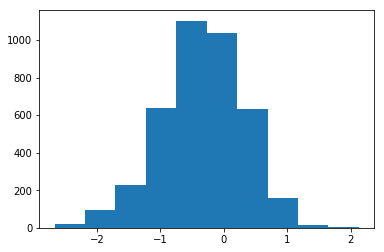

In [61]:
plt.hist(df_train["original_bias_score"])

### Dev

In [62]:
df_val = pd.read_csv(DATA_ROOT / config.val_file)

(array([  3.,  17.,  30.,  78., 128., 109.,  63.,  12.,   2.,   2.]),
 array([-2.48443317, -2.01897317, -1.55351317, -1.08805317, -0.62259316,
        -0.15713316,  0.30832684,  0.77378684,  1.23924685,  1.70470685,
         2.17016685]),
 <a list of 10 Patch objects>)

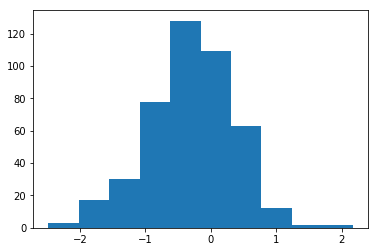

In [63]:
plt.hist(df_val["original_bias_score"])

# Training Loop

In [64]:
from allennlp.training import Callback

In [65]:
from copy import deepcopy

class StatisticRecorder(Callback):
    def __init__(self, orig_weights, rec_periods=1):
        self.rec_periods = rec_periods
        self.norms = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        self.grad_magnitudes = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        self._orig_weights = orig_weights
        self.change_magnitudes = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        
    def on_batch_end(self, data):
        if (data['batches_this_epoch'] + 1) % self.rec_periods == 0:
            with torch.no_grad():
                for k, p in self.trainer.model.named_parameters():
                    if p.requires_grad and p.grad is not None:
                        Z = torch.norm(p).item()
                        self.norms[k].append(Z)
                        self.grad_magnitudes[k].append((torch.norm(p.grad) / Z).item())
                        self.change_magnitudes[k].append((torch.norm(p - self._orig_weights[k]) / Z).item())

In [66]:
class WeightDeviationRegularizor(Callback):
    def __init__(self, orig_weights, weight=1e-4, l1=True):
        self.orig_weights = orig_weights
        self.weight = weight
        self.l1 = l1
        
    def get_reg_term(self, now, orig):
        if self.l1:
            return torch.where(now < orig, torch.ones_like(now), -torch.ones_like(now))
        else:
            return (orig - now)
        
    def on_backward_end(self, data):
        lr = config.lr
        with torch.no_grad():
            for name, param in self.trainer.model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    reg_term = self.weight * lr * self.get_reg_term(param.data, orig_weights[name])
                    param.data.add_(reg_term)

In [67]:
from collections import defaultdict
class LossMonitor(Callback):
    def __init__(self):
        super().__init__()
        self.logs = defaultdict(list)
    def on_forward_end(self, payload):
        for k, v in payload.items():
            if "loss" in k: self.logs[k].append(v.item())

In [68]:
stat_rec = StatisticRecorder(orig_weights, rec_periods=1)
wdd = WeightDeviationRegularizor(orig_weights, weight=config.weight_reg)
monitor = LossMonitor()

In [69]:
def use(name: str):
    if "LayerNorm" in name: return False
    if "position_embeddings" in name: return False
    if "token_type" in name: return False
    return True

In [70]:
filtered_params = [p for name, p in model.named_parameters() if use(name)]

In [71]:
optimizer = torch.optim.Adam(filtered_params, lr=config.lr, weight_decay=0.)

In [72]:
from allennlp.training.learning_rate_schedulers import SlantedTriangular, CosineWithRestarts
# use slanted triangular lr scheduler to prevent initial spike in consistency loss
lr_sched = SlantedTriangular(optimizer, 
                             num_epochs=config.epochs, 
                             num_steps_per_epoch=iterator.get_num_batches(train_ds))

In [73]:
from allennlp.training import TrainerWithCallbacks

trainer = TrainerWithCallbacks(
    model=model,
    optimizer=optimizer,
    iterator=iterator,
    train_dataset=train_ds,
    validation_dataset=val_ds,
    callbacks=[stat_rec, wdd, monitor],
    learning_rate_scheduler=lr_sched,
    #     serialization_dir=DATA_ROOT / "debias_ckpts",
    cuda_device=0 if torch.cuda.is_available() else -1,
    num_epochs=config.epochs,
)

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled


In [74]:
trainer.train()

  0%|          | 0/123 [00:00<?, ?it/s]

total_prob_diff: 0.0000, loss: 0.5626 ||:   1%|          | 1/123 [00:07<14:40,  7.22s/it]

total_prob_diff: 0.0000, loss: 0.5582 ||:   2%|▏         | 2/123 [00:13<14:08,  7.01s/it]

total_prob_diff: -0.0002, loss: 0.5657 ||:   2%|▏         | 3/123 [00:20<13:38,  6.82s/it]

total_prob_diff: -0.0003, loss: 0.5675 ||:   3%|▎         | 4/123 [00:26<13:17,  6.70s/it]

total_prob_diff: -0.0002, loss: 0.5903 ||:   4%|▍         | 5/123 [00:34<13:39,  6.94s/it]

total_prob_diff: 0.0001, loss: 0.5903 ||:   5%|▍         | 6/123 [00:42<14:14,  7.30s/it] 

total_prob_diff: -0.0001, loss: 0.5911 ||:   6%|▌         | 7/123 [00:49<14:00,  7.24s/it]

total_prob_diff: -0.0001, loss: 0.5841 ||:   7%|▋         | 8/123 [00:56<13:50,  7.22s/it]

total_prob_diff: -0.0001, loss: 0.5709 ||:   7%|▋         | 9/123 [01:03<13:42,  7.21s/it]

total_prob_diff: -0.0002, loss: 0.5606 ||:   8%|▊         | 10/123 [01:10<13:31,  7.18s/it]

total_prob_diff: -0.0002, loss: 0.5500 ||:   9%|▉         | 11/123 [01:17<13:23,  7.17s/it]

total_prob_diff: -0.0001, loss: 0.5463 ||:  10%|▉         | 12/123 [01:25<13:14,  7.16s/it]

total_prob_diff: -0.0001, loss: 0.5420 ||:  11%|█         | 13/123 [01:32<13:04,  7.13s/it]

total_prob_diff: -0.0001, loss: 0.5373 ||:  11%|█▏        | 14/123 [01:39<12:55,  7.11s/it]

total_prob_diff: -0.0000, loss: 0.5336 ||:  12%|█▏        | 15/123 [01:45<12:37,  7.01s/it]

total_prob_diff: -0.0001, loss: 0.5311 ||:  13%|█▎        | 16/123 [01:52<12:17,  6.89s/it]

total_prob_diff: -0.0001, loss: 0.5289 ||:  14%|█▍        | 17/123 [01:59<12:01,  6.80s/it]

total_prob_diff: -0.0001, loss: 0.5235 ||:  15%|█▍        | 18/123 [02:05<11:50,  6.77s/it]

total_prob_diff: -0.0004, loss: 0.5249 ||:  15%|█▌        | 19/123 [02:13<12:01,  6.93s/it]

total_prob_diff: -0.0004, loss: 0.5260 ||:  16%|█▋        | 20/123 [02:23<13:41,  7.98s/it]

total_prob_diff: -0.0004, loss: 0.5211 ||:  17%|█▋        | 21/123 [02:34<15:04,  8.87s/it]

total_prob_diff: 0.0000, loss: 0.5227 ||:  18%|█▊        | 22/123 [02:45<16:07,  9.58s/it] 

total_prob_diff: 0.0001, loss: 0.5206 ||:  19%|█▊        | 23/123 [02:56<16:31,  9.91s/it]

total_prob_diff: 0.0002, loss: 0.5248 ||:  20%|█▉        | 24/123 [03:06<16:38, 10.08s/it]

total_prob_diff: 0.0002, loss: 0.5202 ||:  20%|██        | 25/123 [03:18<17:03, 10.44s/it]

total_prob_diff: 0.0002, loss: 0.5210 ||:  21%|██        | 26/123 [03:29<17:14, 10.67s/it]

total_prob_diff: 0.0000, loss: 0.5231 ||:  22%|██▏       | 27/123 [03:41<17:52, 11.17s/it]

total_prob_diff: 0.0001, loss: 0.5226 ||:  23%|██▎       | 28/123 [03:55<18:45, 11.85s/it]

total_prob_diff: -0.0005, loss: 0.5252 ||:  24%|██▎       | 29/123 [04:08<19:09, 12.23s/it]

total_prob_diff: -0.0010, loss: 0.5245 ||:  24%|██▍       | 30/123 [04:22<19:39, 12.69s/it]

total_prob_diff: -0.0010, loss: 0.5221 ||:  25%|██▌       | 31/123 [04:35<20:00, 13.05s/it]

total_prob_diff: -0.0010, loss: 0.5197 ||:  26%|██▌       | 32/123 [04:50<20:20, 13.41s/it]

total_prob_diff: -0.0009, loss: 0.5174 ||:  27%|██▋       | 33/123 [05:04<20:26, 13.63s/it]

total_prob_diff: -0.0009, loss: 0.5180 ||:  28%|██▊       | 34/123 [05:18<20:38, 13.91s/it]

total_prob_diff: -0.0008, loss: 0.5201 ||:  28%|██▊       | 35/123 [05:34<20:57, 14.29s/it]

total_prob_diff: -0.0008, loss: 0.5212 ||:  29%|██▉       | 36/123 [05:48<20:57, 14.45s/it]

total_prob_diff: -0.0007, loss: 0.5211 ||:  30%|███       | 37/123 [06:03<20:33, 14.34s/it]

total_prob_diff: -0.0007, loss: 0.5215 ||:  31%|███       | 38/123 [06:16<20:08, 14.21s/it]

total_prob_diff: -0.0007, loss: 0.5210 ||:  32%|███▏      | 39/123 [06:30<19:40, 14.06s/it]

total_prob_diff: -0.0007, loss: 0.5195 ||:  33%|███▎      | 40/123 [06:44<19:22, 14.00s/it]

total_prob_diff: -0.0007, loss: 0.5207 ||:  33%|███▎      | 41/123 [06:58<19:09, 14.02s/it]

total_prob_diff: -0.0006, loss: 0.5222 ||:  34%|███▍      | 42/123 [07:12<18:52, 13.98s/it]

total_prob_diff: -0.0007, loss: 0.5238 ||:  35%|███▍      | 43/123 [07:28<19:26, 14.58s/it]

total_prob_diff: -0.0008, loss: 0.5237 ||:  36%|███▌      | 44/123 [07:42<19:03, 14.47s/it]

total_prob_diff: -0.0007, loss: 0.5243 ||:  37%|███▋      | 45/123 [07:56<18:42, 14.39s/it]

total_prob_diff: -0.0006, loss: 0.5227 ||:  37%|███▋      | 46/123 [08:10<18:16, 14.24s/it]

total_prob_diff: -0.0006, loss: 0.5224 ||:  38%|███▊      | 47/123 [08:24<17:48, 14.06s/it]

total_prob_diff: -0.0006, loss: 0.5220 ||:  39%|███▉      | 48/123 [08:37<17:16, 13.81s/it]

total_prob_diff: -0.0006, loss: 0.5221 ||:  40%|███▉      | 49/123 [08:49<16:24, 13.30s/it]

total_prob_diff: -0.0006, loss: 0.5226 ||:  41%|████      | 50/123 [09:01<15:40, 12.88s/it]

total_prob_diff: -0.0006, loss: 0.5204 ||:  41%|████▏     | 51/123 [09:14<15:16, 12.73s/it]

total_prob_diff: -0.0006, loss: 0.5212 ||:  42%|████▏     | 52/123 [09:27<15:24, 13.02s/it]

total_prob_diff: -0.0006, loss: 0.5200 ||:  43%|████▎     | 53/123 [09:41<15:21, 13.17s/it]

total_prob_diff: -0.0006, loss: 0.5189 ||:  44%|████▍     | 54/123 [09:54<15:16, 13.28s/it]

total_prob_diff: -0.0006, loss: 0.5189 ||:  45%|████▍     | 55/123 [10:09<15:30, 13.68s/it]

total_prob_diff: -0.0007, loss: 0.5168 ||:  46%|████▌     | 56/123 [10:22<15:11, 13.60s/it]

total_prob_diff: -0.0007, loss: 0.5149 ||:  46%|████▋     | 57/123 [10:36<14:55, 13.57s/it]

total_prob_diff: -0.0007, loss: 0.5154 ||:  47%|████▋     | 58/123 [10:51<15:14, 14.07s/it]

total_prob_diff: -0.0006, loss: 0.5157 ||:  48%|████▊     | 59/123 [11:07<15:28, 14.51s/it]

total_prob_diff: -0.0006, loss: 0.5146 ||:  49%|████▉     | 60/123 [11:20<14:56, 14.23s/it]

total_prob_diff: -0.0006, loss: 0.5140 ||:  50%|████▉     | 61/123 [11:33<14:08, 13.69s/it]

total_prob_diff: -0.0005, loss: 0.5125 ||:  50%|█████     | 62/123 [11:45<13:30, 13.28s/it]

total_prob_diff: -0.0005, loss: 0.5127 ||:  51%|█████     | 63/123 [11:59<13:38, 13.64s/it]

total_prob_diff: -0.0005, loss: 0.5115 ||:  52%|█████▏    | 64/123 [12:12<13:10, 13.40s/it]

total_prob_diff: -0.0005, loss: 0.5108 ||:  53%|█████▎    | 65/123 [12:26<12:56, 13.38s/it]

total_prob_diff: -0.0005, loss: 0.5089 ||:  54%|█████▎    | 66/123 [12:39<12:38, 13.30s/it]

total_prob_diff: -0.0005, loss: 0.5107 ||:  54%|█████▍    | 67/123 [12:51<12:10, 13.05s/it]

total_prob_diff: -0.0006, loss: 0.5092 ||:  55%|█████▌    | 68/123 [13:03<11:39, 12.72s/it]

total_prob_diff: -0.0006, loss: 0.5089 ||:  56%|█████▌    | 69/123 [13:14<11:04, 12.31s/it]

total_prob_diff: -0.0006, loss: 0.5075 ||:  57%|█████▋    | 70/123 [13:27<10:52, 12.31s/it]

total_prob_diff: -0.0007, loss: 0.5065 ||:  58%|█████▊    | 71/123 [13:38<10:25, 12.02s/it]

total_prob_diff: -0.0006, loss: 0.5062 ||:  59%|█████▊    | 72/123 [13:48<09:41, 11.40s/it]

total_prob_diff: -0.0006, loss: 0.5074 ||:  59%|█████▉    | 73/123 [13:56<08:41, 10.44s/it]

total_prob_diff: -0.0006, loss: 0.5056 ||:  60%|██████    | 74/123 [14:04<07:56,  9.73s/it]

total_prob_diff: -0.0006, loss: 0.5035 ||:  61%|██████    | 75/123 [14:12<07:23,  9.23s/it]

total_prob_diff: -0.0007, loss: 0.5028 ||:  62%|██████▏   | 76/123 [14:21<07:06,  9.08s/it]

total_prob_diff: -0.0007, loss: 0.5021 ||:  63%|██████▎   | 77/123 [14:30<06:48,  8.88s/it]

total_prob_diff: -0.0007, loss: 0.5015 ||:  63%|██████▎   | 78/123 [14:38<06:33,  8.74s/it]

total_prob_diff: -0.0007, loss: 0.4990 ||:  64%|██████▍   | 79/123 [14:49<06:59,  9.53s/it]

total_prob_diff: -0.0007, loss: 0.4980 ||:  65%|██████▌   | 80/123 [15:01<07:19, 10.23s/it]

total_prob_diff: -0.0007, loss: 0.4962 ||:  66%|██████▌   | 81/123 [15:13<07:24, 10.58s/it]

total_prob_diff: -0.0006, loss: 0.4957 ||:  67%|██████▋   | 82/123 [15:24<07:23, 10.82s/it]

total_prob_diff: -0.0007, loss: 0.4950 ||:  67%|██████▋   | 83/123 [15:35<07:14, 10.87s/it]

total_prob_diff: -0.0007, loss: 0.4938 ||:  68%|██████▊   | 84/123 [15:46<07:04, 10.87s/it]

total_prob_diff: -0.0006, loss: 0.4927 ||:  69%|██████▉   | 85/123 [15:57<06:52, 10.84s/it]

total_prob_diff: -0.0006, loss: 0.4919 ||:  70%|██████▉   | 86/123 [16:07<06:39, 10.79s/it]

total_prob_diff: -0.0007, loss: 0.4917 ||:  71%|███████   | 87/123 [16:18<06:29, 10.83s/it]

total_prob_diff: -0.0007, loss: 0.4911 ||:  72%|███████▏  | 88/123 [16:29<06:19, 10.84s/it]

total_prob_diff: -0.0007, loss: 0.4913 ||:  72%|███████▏  | 89/123 [16:40<06:13, 10.98s/it]

total_prob_diff: -0.0006, loss: 0.4906 ||:  73%|███████▎  | 90/123 [16:52<06:08, 11.17s/it]

total_prob_diff: -0.0007, loss: 0.4893 ||:  74%|███████▍  | 91/123 [17:03<05:58, 11.21s/it]

total_prob_diff: -0.0007, loss: 0.4888 ||:  75%|███████▍  | 92/123 [17:15<05:52, 11.36s/it]

total_prob_diff: -0.0007, loss: 0.4882 ||:  76%|███████▌  | 93/123 [17:26<05:40, 11.33s/it]

total_prob_diff: -0.0008, loss: 0.4873 ||:  76%|███████▋  | 94/123 [17:37<05:27, 11.29s/it]

total_prob_diff: -0.0007, loss: 0.4866 ||:  77%|███████▋  | 95/123 [17:49<05:22, 11.51s/it]

total_prob_diff: -0.0007, loss: 0.4864 ||:  78%|███████▊  | 96/123 [18:01<05:09, 11.45s/it]

total_prob_diff: -0.0007, loss: 0.4857 ||:  79%|███████▉  | 97/123 [18:12<04:55, 11.36s/it]

total_prob_diff: -0.0007, loss: 0.4845 ||:  80%|███████▉  | 98/123 [18:23<04:40, 11.20s/it]

total_prob_diff: -0.0007, loss: 0.4835 ||:  80%|████████  | 99/123 [18:34<04:28, 11.18s/it]

total_prob_diff: -0.0007, loss: 0.4828 ||:  81%|████████▏ | 100/123 [18:46<04:24, 11.49s/it]

total_prob_diff: -0.0008, loss: 0.4820 ||:  82%|████████▏ | 101/123 [18:57<04:10, 11.38s/it]

total_prob_diff: -0.0008, loss: 0.4820 ||:  83%|████████▎ | 102/123 [19:06<03:41, 10.54s/it]

total_prob_diff: -0.0008, loss: 0.4814 ||:  84%|████████▎ | 103/123 [19:14<03:15,  9.76s/it]

total_prob_diff: -0.0008, loss: 0.4804 ||:  85%|████████▍ | 104/123 [19:22<02:55,  9.23s/it]

total_prob_diff: -0.0009, loss: 0.4798 ||:  85%|████████▌ | 105/123 [19:33<02:58,  9.89s/it]

total_prob_diff: -0.0009, loss: 0.4800 ||:  86%|████████▌ | 106/123 [19:44<02:55, 10.31s/it]

total_prob_diff: -0.0010, loss: 0.4793 ||:  87%|████████▋ | 107/123 [19:55<02:45, 10.36s/it]

total_prob_diff: -0.0009, loss: 0.4788 ||:  88%|████████▊ | 108/123 [20:03<02:26,  9.74s/it]

total_prob_diff: -0.0010, loss: 0.4778 ||:  89%|████████▊ | 109/123 [20:11<02:08,  9.18s/it]

total_prob_diff: -0.0009, loss: 0.4779 ||:  89%|████████▉ | 110/123 [20:19<01:55,  8.88s/it]

total_prob_diff: -0.0009, loss: 0.4774 ||:  90%|█████████ | 111/123 [20:27<01:43,  8.60s/it]

total_prob_diff: -0.0009, loss: 0.4764 ||:  91%|█████████ | 112/123 [20:35<01:31,  8.36s/it]

total_prob_diff: -0.0009, loss: 0.4755 ||:  92%|█████████▏| 113/123 [20:43<01:23,  8.39s/it]

total_prob_diff: -0.0010, loss: 0.4751 ||:  93%|█████████▎| 114/123 [20:52<01:15,  8.34s/it]

total_prob_diff: -0.0010, loss: 0.4742 ||:  93%|█████████▎| 115/123 [21:00<01:07,  8.42s/it]

total_prob_diff: -0.0010, loss: 0.4729 ||:  94%|█████████▍| 116/123 [21:08<00:58,  8.30s/it]

total_prob_diff: -0.0010, loss: 0.4721 ||:  95%|█████████▌| 117/123 [21:16<00:48,  8.02s/it]

total_prob_diff: -0.0010, loss: 0.4714 ||:  96%|█████████▌| 118/123 [21:23<00:38,  7.78s/it]

total_prob_diff: -0.0010, loss: 0.4698 ||:  97%|█████████▋| 119/123 [21:30<00:30,  7.60s/it]

total_prob_diff: -0.0010, loss: 0.4691 ||:  98%|█████████▊| 120/123 [21:38<00:23,  7.69s/it]

total_prob_diff: -0.0010, loss: 0.4682 ||:  98%|█████████▊| 121/123 [21:45<00:15,  7.59s/it]

total_prob_diff: -0.0010, loss: 0.4673 ||:  99%|█████████▉| 122/123 [21:52<00:07,  7.43s/it]

total_prob_diff: -0.0010, loss: 0.4665 ||: 100%|██████████| 123/123 [21:59<00:00,  7.23s/it]


  0%|          | 0/14 [00:00<?, ?it/s]

total_prob_diff: -0.0010, loss: 0.4202 ||:   7%|▋         | 1/14 [00:01<00:17,  1.35s/it]

total_prob_diff: -0.0010, loss: 0.4270 ||:  14%|█▍        | 2/14 [00:02<00:16,  1.38s/it]

total_prob_diff: -0.0010, loss: 0.4692 ||:  21%|██▏       | 3/14 [00:04<00:15,  1.41s/it]

total_prob_diff: -0.0010, loss: 0.4658 ||:  29%|██▊       | 4/14 [00:05<00:14,  1.45s/it]

total_prob_diff: -0.0010, loss: 0.4504 ||:  36%|███▌      | 5/14 [00:07<00:13,  1.48s/it]

total_prob_diff: -0.0009, loss: 0.4144 ||:  43%|████▎     | 6/14 [00:08<00:12,  1.51s/it]

total_prob_diff: -0.0009, loss: 0.4163 ||:  50%|█████     | 7/14 [00:10<00:10,  1.53s/it]

total_prob_diff: -0.0009, loss: 0.4124 ||:  57%|█████▋    | 8/14 [00:12<00:09,  1.54s/it]

total_prob_diff: -0.0009, loss: 0.4022 ||:  64%|██████▍   | 9/14 [00:13<00:07,  1.55s/it]

total_prob_diff: -0.0009, loss: 0.3889 ||:  71%|███████▏  | 10/14 [00:15<00:06,  1.57s/it]

total_prob_diff: -0.0009, loss: 0.3892 ||:  79%|███████▊  | 11/14 [00:16<00:04,  1.57s/it]

total_prob_diff: -0.0009, loss: 0.3819 ||:  86%|████████▌ | 12/14 [00:18<00:03,  1.55s/it]

total_prob_diff: -0.0009, loss: 0.3851 ||:  93%|█████████▎| 13/14 [00:19<00:01,  1.56s/it]

total_prob_diff: -0.0009, loss: 0.3821 ||: 100%|██████████| 14/14 [00:21<00:00,  1.50s/it]


  0%|          | 0/123 [00:00<?, ?it/s]

total_prob_diff: -0.0009, loss: 0.3230 ||:   1%|          | 1/123 [00:08<16:21,  8.05s/it]

total_prob_diff: -0.0009, loss: 0.3351 ||:   2%|▏         | 2/123 [00:14<15:34,  7.72s/it]

total_prob_diff: -0.0009, loss: 0.3258 ||:   2%|▏         | 3/123 [00:21<14:49,  7.41s/it]

total_prob_diff: -0.0009, loss: 0.3172 ||:   3%|▎         | 4/123 [00:28<14:20,  7.23s/it]

total_prob_diff: -0.0009, loss: 0.3151 ||:   4%|▍         | 5/123 [00:35<14:09,  7.20s/it]

total_prob_diff: -0.0009, loss: 0.3194 ||:   5%|▍         | 6/123 [00:42<13:51,  7.11s/it]

total_prob_diff: -0.0009, loss: 0.3251 ||:   6%|▌         | 7/123 [00:49<13:35,  7.03s/it]

total_prob_diff: -0.0008, loss: 0.3243 ||:   7%|▋         | 8/123 [00:56<13:25,  7.00s/it]

total_prob_diff: -0.0008, loss: 0.3220 ||:   7%|▋         | 9/123 [01:03<13:28,  7.10s/it]

total_prob_diff: -0.0008, loss: 0.3228 ||:   8%|▊         | 10/123 [01:10<13:18,  7.07s/it]

total_prob_diff: -0.0008, loss: 0.3195 ||:   9%|▉         | 11/123 [01:17<12:59,  6.96s/it]

total_prob_diff: -0.0008, loss: 0.3182 ||:  10%|▉         | 12/123 [01:24<12:47,  6.92s/it]

total_prob_diff: -0.0009, loss: 0.3274 ||:  11%|█         | 13/123 [01:30<12:37,  6.89s/it]

total_prob_diff: -0.0009, loss: 0.3286 ||:  11%|█▏        | 14/123 [01:38<12:39,  6.96s/it]

total_prob_diff: -0.0009, loss: 0.3289 ||:  12%|█▏        | 15/123 [01:45<12:34,  6.99s/it]

total_prob_diff: -0.0009, loss: 0.3279 ||:  13%|█▎        | 16/123 [01:52<12:25,  6.97s/it]

total_prob_diff: -0.0009, loss: 0.3274 ||:  14%|█▍        | 17/123 [01:59<12:19,  6.98s/it]

total_prob_diff: -0.0009, loss: 0.3284 ||:  15%|█▍        | 18/123 [02:05<12:10,  6.95s/it]

total_prob_diff: -0.0008, loss: 0.3330 ||:  15%|█▌        | 19/123 [02:12<11:58,  6.91s/it]

total_prob_diff: -0.0008, loss: 0.3336 ||:  16%|█▋        | 20/123 [02:19<11:46,  6.86s/it]

total_prob_diff: -0.0009, loss: 0.3329 ||:  17%|█▋        | 21/123 [02:26<11:45,  6.92s/it]

total_prob_diff: -0.0008, loss: 0.3296 ||:  18%|█▊        | 22/123 [02:33<11:33,  6.87s/it]

total_prob_diff: -0.0008, loss: 0.3300 ||:  19%|█▊        | 23/123 [02:40<11:25,  6.86s/it]

total_prob_diff: -0.0009, loss: 0.3302 ||:  20%|█▉        | 24/123 [02:46<11:11,  6.78s/it]

total_prob_diff: -0.0009, loss: 0.3282 ||:  20%|██        | 25/123 [02:53<11:02,  6.77s/it]

total_prob_diff: -0.0009, loss: 0.3276 ||:  21%|██        | 26/123 [03:00<10:53,  6.73s/it]

total_prob_diff: -0.0009, loss: 0.3272 ||:  22%|██▏       | 27/123 [03:06<10:40,  6.67s/it]

total_prob_diff: -0.0009, loss: 0.3280 ||:  23%|██▎       | 28/123 [03:13<10:41,  6.75s/it]

total_prob_diff: -0.0009, loss: 0.3297 ||:  24%|██▎       | 29/123 [03:20<10:38,  6.79s/it]

total_prob_diff: -0.0008, loss: 0.3299 ||:  24%|██▍       | 30/123 [03:27<10:30,  6.78s/it]

total_prob_diff: -0.0008, loss: 0.3287 ||:  25%|██▌       | 31/123 [03:33<10:22,  6.76s/it]

total_prob_diff: -0.0008, loss: 0.3288 ||:  26%|██▌       | 32/123 [03:40<10:19,  6.80s/it]

total_prob_diff: -0.0008, loss: 0.3288 ||:  27%|██▋       | 33/123 [03:48<10:26,  6.96s/it]

total_prob_diff: -0.0008, loss: 0.3296 ||:  28%|██▊       | 34/123 [03:55<10:17,  6.93s/it]

total_prob_diff: -0.0008, loss: 0.3293 ||:  28%|██▊       | 35/123 [04:01<10:05,  6.88s/it]

total_prob_diff: -0.0008, loss: 0.3286 ||:  29%|██▉       | 36/123 [04:09<10:10,  7.02s/it]

total_prob_diff: -0.0008, loss: 0.3279 ||:  30%|███       | 37/123 [04:15<09:55,  6.93s/it]

total_prob_diff: -0.0008, loss: 0.3267 ||:  31%|███       | 38/123 [04:22<09:33,  6.75s/it]

total_prob_diff: -0.0008, loss: 0.3263 ||:  32%|███▏      | 39/123 [04:28<09:15,  6.61s/it]

total_prob_diff: -0.0008, loss: 0.3275 ||:  33%|███▎      | 40/123 [04:35<09:10,  6.63s/it]

total_prob_diff: -0.0008, loss: 0.3277 ||:  33%|███▎      | 41/123 [04:41<09:00,  6.60s/it]

total_prob_diff: -0.0008, loss: 0.3280 ||:  34%|███▍      | 42/123 [04:48<09:00,  6.67s/it]

total_prob_diff: -0.0008, loss: 0.3275 ||:  35%|███▍      | 43/123 [04:55<08:55,  6.70s/it]

total_prob_diff: -0.0008, loss: 0.3262 ||:  36%|███▌      | 44/123 [05:01<08:47,  6.68s/it]

total_prob_diff: -0.0008, loss: 0.3265 ||:  37%|███▋      | 45/123 [05:08<08:48,  6.77s/it]

total_prob_diff: -0.0008, loss: 0.3260 ||:  37%|███▋      | 46/123 [05:15<08:42,  6.78s/it]

total_prob_diff: -0.0008, loss: 0.3251 ||:  38%|███▊      | 47/123 [05:22<08:30,  6.72s/it]

total_prob_diff: -0.0008, loss: 0.3255 ||:  39%|███▉      | 48/123 [05:29<08:28,  6.77s/it]

total_prob_diff: -0.0008, loss: 0.3242 ||:  40%|███▉      | 49/123 [05:36<08:26,  6.84s/it]

total_prob_diff: -0.0008, loss: 0.3240 ||:  41%|████      | 50/123 [05:42<08:18,  6.82s/it]

total_prob_diff: -0.0008, loss: 0.3240 ||:  41%|████▏     | 51/123 [05:49<08:08,  6.79s/it]

total_prob_diff: -0.0008, loss: 0.3238 ||:  42%|████▏     | 52/123 [05:56<08:11,  6.92s/it]

total_prob_diff: -0.0008, loss: 0.3229 ||:  43%|████▎     | 53/123 [06:04<08:17,  7.11s/it]

total_prob_diff: -0.0008, loss: 0.3233 ||:  44%|████▍     | 54/123 [06:11<08:01,  6.98s/it]

total_prob_diff: -0.0008, loss: 0.3236 ||:  45%|████▍     | 55/123 [06:17<07:46,  6.85s/it]

total_prob_diff: -0.0008, loss: 0.3239 ||:  46%|████▌     | 56/123 [06:24<07:34,  6.78s/it]

total_prob_diff: -0.0008, loss: 0.3239 ||:  46%|████▋     | 57/123 [06:31<07:26,  6.77s/it]

total_prob_diff: -0.0008, loss: 0.3241 ||:  47%|████▋     | 58/123 [06:37<07:16,  6.71s/it]

total_prob_diff: -0.0008, loss: 0.3239 ||:  48%|████▊     | 59/123 [06:44<07:07,  6.67s/it]

total_prob_diff: -0.0008, loss: 0.3230 ||:  49%|████▉     | 60/123 [06:50<06:56,  6.61s/it]

total_prob_diff: -0.0008, loss: 0.3226 ||:  50%|████▉     | 61/123 [06:57<06:47,  6.57s/it]

total_prob_diff: -0.0008, loss: 0.3219 ||:  50%|█████     | 62/123 [07:03<06:40,  6.56s/it]

total_prob_diff: -0.0008, loss: 0.3215 ||:  51%|█████     | 63/123 [07:10<06:32,  6.54s/it]

total_prob_diff: -0.0008, loss: 0.3214 ||:  52%|█████▏    | 64/123 [07:16<06:25,  6.53s/it]

total_prob_diff: -0.0008, loss: 0.3213 ||:  53%|█████▎    | 65/123 [07:23<06:19,  6.54s/it]

total_prob_diff: -0.0008, loss: 0.3212 ||:  54%|█████▎    | 66/123 [07:30<06:17,  6.62s/it]

total_prob_diff: -0.0009, loss: 0.3206 ||:  54%|█████▍    | 67/123 [07:36<06:09,  6.59s/it]

total_prob_diff: -0.0008, loss: 0.3208 ||:  55%|█████▌    | 68/123 [07:43<06:00,  6.56s/it]

total_prob_diff: -0.0008, loss: 0.3202 ||:  56%|█████▌    | 69/123 [07:49<05:52,  6.54s/it]

total_prob_diff: -0.0008, loss: 0.3192 ||:  57%|█████▋    | 70/123 [07:56<05:46,  6.54s/it]

total_prob_diff: -0.0008, loss: 0.3198 ||:  58%|█████▊    | 71/123 [08:02<05:39,  6.53s/it]

total_prob_diff: -0.0008, loss: 0.3192 ||:  59%|█████▊    | 72/123 [08:09<05:32,  6.51s/it]

total_prob_diff: -0.0008, loss: 0.3192 ||:  59%|█████▉    | 73/123 [08:15<05:25,  6.52s/it]

total_prob_diff: -0.0008, loss: 0.3193 ||:  60%|██████    | 74/123 [08:22<05:18,  6.50s/it]

total_prob_diff: -0.0008, loss: 0.3187 ||:  61%|██████    | 75/123 [08:28<05:11,  6.49s/it]

total_prob_diff: -0.0008, loss: 0.3180 ||:  62%|██████▏   | 76/123 [08:35<05:04,  6.48s/it]

total_prob_diff: -0.0008, loss: 0.3179 ||:  63%|██████▎   | 77/123 [08:42<05:05,  6.64s/it]

total_prob_diff: -0.0008, loss: 0.3180 ||:  63%|██████▎   | 78/123 [08:48<04:57,  6.61s/it]

total_prob_diff: -0.0008, loss: 0.3176 ||:  64%|██████▍   | 79/123 [08:55<04:51,  6.62s/it]

total_prob_diff: -0.0008, loss: 0.3172 ||:  65%|██████▌   | 80/123 [09:01<04:42,  6.57s/it]

total_prob_diff: -0.0008, loss: 0.3175 ||:  66%|██████▌   | 81/123 [09:08<04:34,  6.54s/it]

total_prob_diff: -0.0008, loss: 0.3182 ||:  67%|██████▋   | 82/123 [09:14<04:27,  6.53s/it]

total_prob_diff: -0.0008, loss: 0.3175 ||:  67%|██████▋   | 83/123 [09:21<04:20,  6.51s/it]

total_prob_diff: -0.0008, loss: 0.3167 ||:  68%|██████▊   | 84/123 [09:27<04:16,  6.58s/it]

total_prob_diff: -0.0008, loss: 0.3164 ||:  69%|██████▉   | 85/123 [09:34<04:09,  6.56s/it]

total_prob_diff: -0.0008, loss: 0.3162 ||:  70%|██████▉   | 86/123 [09:40<04:01,  6.53s/it]

total_prob_diff: -0.0008, loss: 0.3156 ||:  71%|███████   | 87/123 [09:47<03:54,  6.52s/it]

total_prob_diff: -0.0008, loss: 0.3154 ||:  72%|███████▏  | 88/123 [09:53<03:48,  6.52s/it]

total_prob_diff: -0.0008, loss: 0.3158 ||:  72%|███████▏  | 89/123 [10:00<03:42,  6.53s/it]

total_prob_diff: -0.0008, loss: 0.3155 ||:  73%|███████▎  | 90/123 [10:06<03:35,  6.52s/it]

total_prob_diff: -0.0008, loss: 0.3155 ||:  74%|███████▍  | 91/123 [10:13<03:28,  6.51s/it]

total_prob_diff: -0.0008, loss: 0.3154 ||:  75%|███████▍  | 92/123 [10:19<03:21,  6.49s/it]

total_prob_diff: -0.0007, loss: 0.3154 ||:  76%|███████▌  | 93/123 [10:26<03:15,  6.50s/it]

total_prob_diff: -0.0008, loss: 0.3147 ||:  76%|███████▋  | 94/123 [10:33<03:09,  6.55s/it]

total_prob_diff: -0.0008, loss: 0.3145 ||:  77%|███████▋  | 95/123 [10:39<03:03,  6.56s/it]

total_prob_diff: -0.0008, loss: 0.3141 ||:  78%|███████▊  | 96/123 [10:46<02:57,  6.59s/it]

total_prob_diff: -0.0008, loss: 0.3134 ||:  79%|███████▉  | 97/123 [10:52<02:50,  6.57s/it]

total_prob_diff: -0.0007, loss: 0.3134 ||:  80%|███████▉  | 98/123 [10:59<02:44,  6.57s/it]

total_prob_diff: -0.0007, loss: 0.3124 ||:  80%|████████  | 99/123 [11:06<02:44,  6.84s/it]

total_prob_diff: -0.0008, loss: 0.3120 ||:  81%|████████▏ | 100/123 [11:13<02:36,  6.78s/it]

total_prob_diff: -0.0008, loss: 0.3115 ||:  82%|████████▏ | 101/123 [11:20<02:29,  6.80s/it]

total_prob_diff: -0.0008, loss: 0.3107 ||:  83%|████████▎ | 102/123 [11:27<02:22,  6.81s/it]

total_prob_diff: -0.0008, loss: 0.3105 ||:  84%|████████▎ | 103/123 [11:33<02:14,  6.73s/it]

total_prob_diff: -0.0008, loss: 0.3103 ||:  85%|████████▍ | 104/123 [11:40<02:07,  6.69s/it]

total_prob_diff: -0.0008, loss: 0.3098 ||:  85%|████████▌ | 105/123 [11:46<01:59,  6.66s/it]

total_prob_diff: -0.0008, loss: 0.3098 ||:  86%|████████▌ | 106/123 [11:53<01:52,  6.63s/it]

total_prob_diff: -0.0007, loss: 0.3097 ||:  87%|████████▋ | 107/123 [12:00<01:46,  6.63s/it]

total_prob_diff: -0.0008, loss: 0.3094 ||:  88%|████████▊ | 108/123 [12:06<01:38,  6.60s/it]

total_prob_diff: -0.0008, loss: 0.3091 ||:  89%|████████▊ | 109/123 [12:13<01:32,  6.57s/it]

total_prob_diff: -0.0008, loss: 0.3088 ||:  89%|████████▉ | 110/123 [12:19<01:25,  6.57s/it]

total_prob_diff: -0.0008, loss: 0.3092 ||:  90%|█████████ | 111/123 [12:26<01:19,  6.65s/it]

total_prob_diff: -0.0007, loss: 0.3087 ||:  91%|█████████ | 112/123 [12:33<01:12,  6.61s/it]

total_prob_diff: -0.0007, loss: 0.3082 ||:  92%|█████████▏| 113/123 [12:39<01:05,  6.58s/it]

total_prob_diff: -0.0008, loss: 0.3076 ||:  93%|█████████▎| 114/123 [12:46<00:59,  6.57s/it]

total_prob_diff: -0.0008, loss: 0.3077 ||:  93%|█████████▎| 115/123 [12:52<00:52,  6.57s/it]

total_prob_diff: -0.0008, loss: 0.3073 ||:  94%|█████████▍| 116/123 [12:59<00:45,  6.57s/it]

total_prob_diff: -0.0008, loss: 0.3072 ||:  95%|█████████▌| 117/123 [13:06<00:39,  6.65s/it]

total_prob_diff: -0.0008, loss: 0.3072 ||:  96%|█████████▌| 118/123 [13:12<00:33,  6.62s/it]

total_prob_diff: -0.0008, loss: 0.3065 ||:  97%|█████████▋| 119/123 [13:18<00:26,  6.56s/it]

total_prob_diff: -0.0008, loss: 0.3060 ||:  98%|█████████▊| 120/123 [13:25<00:19,  6.56s/it]

total_prob_diff: -0.0008, loss: 0.3057 ||:  98%|█████████▊| 121/123 [13:32<00:13,  6.63s/it]

total_prob_diff: -0.0008, loss: 0.3048 ||:  99%|█████████▉| 122/123 [13:38<00:06,  6.60s/it]

total_prob_diff: -0.0008, loss: 0.3043 ||: 100%|██████████| 123/123 [13:45<00:00,  6.58s/it]


  0%|          | 0/14 [00:00<?, ?it/s]

total_prob_diff: -0.0008, loss: 0.3201 ||:   7%|▋         | 1/14 [00:01<00:16,  1.27s/it]

total_prob_diff: -0.0008, loss: 0.3437 ||:  14%|█▍        | 2/14 [00:02<00:15,  1.28s/it]

total_prob_diff: -0.0008, loss: 0.3938 ||:  21%|██▏       | 3/14 [00:03<00:14,  1.30s/it]

total_prob_diff: -0.0008, loss: 0.3939 ||:  29%|██▊       | 4/14 [00:05<00:13,  1.34s/it]

total_prob_diff: -0.0008, loss: 0.3809 ||:  36%|███▌      | 5/14 [00:06<00:12,  1.37s/it]

total_prob_diff: -0.0008, loss: 0.3525 ||:  43%|████▎     | 6/14 [00:08<00:11,  1.39s/it]

total_prob_diff: -0.0008, loss: 0.3484 ||:  50%|█████     | 7/14 [00:09<00:09,  1.41s/it]

total_prob_diff: -0.0008, loss: 0.3468 ||:  57%|█████▋    | 8/14 [00:11<00:08,  1.42s/it]

total_prob_diff: -0.0008, loss: 0.3416 ||:  64%|██████▍   | 9/14 [00:12<00:07,  1.42s/it]

total_prob_diff: -0.0008, loss: 0.3325 ||:  71%|███████▏  | 10/14 [00:13<00:05,  1.42s/it]

total_prob_diff: -0.0008, loss: 0.3366 ||:  79%|███████▊  | 11/14 [00:15<00:04,  1.44s/it]

total_prob_diff: -0.0008, loss: 0.3303 ||:  86%|████████▌ | 12/14 [00:16<00:02,  1.45s/it]

total_prob_diff: -0.0008, loss: 0.3252 ||:  93%|█████████▎| 13/14 [00:18<00:01,  1.45s/it]

total_prob_diff: -0.0008, loss: 0.3254 ||: 100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


  0%|          | 0/123 [00:00<?, ?it/s]

total_prob_diff: -0.0008, loss: 0.2633 ||:   1%|          | 1/123 [00:07<15:06,  7.43s/it]

total_prob_diff: -0.0008, loss: 0.2420 ||:   2%|▏         | 2/123 [00:13<14:22,  7.13s/it]

total_prob_diff: -0.0008, loss: 0.2402 ||:   2%|▏         | 3/123 [00:20<13:54,  6.95s/it]

total_prob_diff: -0.0008, loss: 0.2336 ||:   3%|▎         | 4/123 [00:26<13:32,  6.83s/it]

total_prob_diff: -0.0008, loss: 0.2357 ||:   4%|▍         | 5/123 [00:33<13:16,  6.75s/it]

total_prob_diff: -0.0007, loss: 0.2401 ||:   5%|▍         | 6/123 [00:40<13:03,  6.70s/it]

total_prob_diff: -0.0007, loss: 0.2405 ||:   6%|▌         | 7/123 [00:46<12:49,  6.63s/it]

total_prob_diff: -0.0007, loss: 0.2420 ||:   7%|▋         | 8/123 [00:53<12:40,  6.61s/it]

total_prob_diff: -0.0007, loss: 0.2418 ||:   7%|▋         | 9/123 [00:59<12:33,  6.61s/it]

total_prob_diff: -0.0007, loss: 0.2487 ||:   8%|▊         | 10/123 [01:06<12:31,  6.65s/it]

total_prob_diff: -0.0007, loss: 0.2463 ||:   9%|▉         | 11/123 [01:13<12:21,  6.62s/it]

total_prob_diff: -0.0007, loss: 0.2471 ||:  10%|▉         | 12/123 [01:19<12:10,  6.58s/it]

total_prob_diff: -0.0007, loss: 0.2455 ||:  11%|█         | 13/123 [01:26<12:03,  6.58s/it]

total_prob_diff: -0.0007, loss: 0.2429 ||:  11%|█▏        | 14/123 [01:32<12:03,  6.63s/it]

total_prob_diff: -0.0007, loss: 0.2445 ||:  12%|█▏        | 15/123 [01:39<11:54,  6.61s/it]

total_prob_diff: -0.0007, loss: 0.2454 ||:  13%|█▎        | 16/123 [01:45<11:41,  6.56s/it]

total_prob_diff: -0.0007, loss: 0.2445 ||:  14%|█▍        | 17/123 [01:52<11:37,  6.58s/it]

total_prob_diff: -0.0007, loss: 0.2468 ||:  15%|█▍        | 18/123 [01:59<11:39,  6.66s/it]

total_prob_diff: -0.0007, loss: 0.2469 ||:  15%|█▌        | 19/123 [02:05<11:32,  6.66s/it]

total_prob_diff: -0.0007, loss: 0.2478 ||:  16%|█▋        | 20/123 [02:12<11:24,  6.65s/it]

total_prob_diff: -0.0007, loss: 0.2491 ||:  17%|█▋        | 21/123 [02:20<11:54,  7.00s/it]

total_prob_diff: -0.0007, loss: 0.2507 ||:  18%|█▊        | 22/123 [02:28<12:31,  7.44s/it]

total_prob_diff: -0.0007, loss: 0.2508 ||:  19%|█▊        | 23/123 [02:35<11:55,  7.16s/it]

total_prob_diff: -0.0007, loss: 0.2486 ||:  20%|█▉        | 24/123 [06:24<2:01:46, 73.80s/it]

total_prob_diff: -0.0007, loss: 0.2486 ||:  20%|██        | 25/123 [06:37<1:30:45, 55.56s/it]

total_prob_diff: -0.0007, loss: 0.2486 ||:  21%|██        | 26/123 [06:45<1:06:46, 41.30s/it]

total_prob_diff: -0.0007, loss: 0.2495 ||:  22%|██▏       | 27/123 [06:52<49:40, 31.05s/it]  

total_prob_diff: -0.0007, loss: 0.2498 ||:  23%|██▎       | 28/123 [07:00<37:55, 23.95s/it]

total_prob_diff: -0.0007, loss: 0.2496 ||:  24%|██▎       | 29/123 [07:08<29:58, 19.14s/it]

total_prob_diff: -0.0007, loss: 0.2481 ||:  24%|██▍       | 30/123 [07:15<24:10, 15.60s/it]

total_prob_diff: -0.0007, loss: 0.2475 ||:  25%|██▌       | 31/123 [07:22<19:55, 12.99s/it]

total_prob_diff: -0.0007, loss: 0.2459 ||:  26%|██▌       | 32/123 [07:29<16:56, 11.17s/it]

total_prob_diff: -0.0007, loss: 0.2453 ||:  27%|██▋       | 33/123 [07:35<14:42,  9.80s/it]

total_prob_diff: -0.0007, loss: 0.2454 ||:  28%|██▊       | 34/123 [07:42<13:09,  8.87s/it]

total_prob_diff: -0.0007, loss: 0.2442 ||:  28%|██▊       | 35/123 [07:49<12:12,  8.33s/it]

total_prob_diff: -0.0007, loss: 0.2436 ||:  29%|██▉       | 36/123 [07:56<11:24,  7.87s/it]

total_prob_diff: -0.0007, loss: 0.2432 ||:  30%|███       | 37/123 [08:04<11:14,  7.84s/it]

total_prob_diff: -0.0007, loss: 0.2440 ||:  31%|███       | 38/123 [08:11<10:41,  7.55s/it]

total_prob_diff: -0.0007, loss: 0.2440 ||:  32%|███▏      | 39/123 [08:17<10:13,  7.30s/it]

total_prob_diff: -0.0007, loss: 0.2438 ||:  33%|███▎      | 40/123 [08:24<09:54,  7.16s/it]

total_prob_diff: -0.0007, loss: 0.2431 ||:  33%|███▎      | 41/123 [08:31<09:39,  7.06s/it]

total_prob_diff: -0.0007, loss: 0.2434 ||:  34%|███▍      | 42/123 [08:38<09:30,  7.05s/it]

total_prob_diff: -0.0007, loss: 0.2431 ||:  35%|███▍      | 43/123 [08:45<09:10,  6.88s/it]

total_prob_diff: -0.0007, loss: 0.2437 ||:  36%|███▌      | 44/123 [08:51<08:50,  6.72s/it]

total_prob_diff: -0.0007, loss: 0.2426 ||:  37%|███▋      | 45/123 [08:57<08:35,  6.60s/it]

total_prob_diff: -0.0007, loss: 0.2426 ||:  37%|███▋      | 46/123 [09:04<08:22,  6.53s/it]

total_prob_diff: -0.0007, loss: 0.2433 ||:  38%|███▊      | 47/123 [09:10<08:11,  6.47s/it]

total_prob_diff: -0.0007, loss: 0.2434 ||:  39%|███▉      | 48/123 [09:17<08:14,  6.59s/it]

total_prob_diff: -0.0007, loss: 0.2434 ||:  40%|███▉      | 49/123 [09:24<08:20,  6.76s/it]

total_prob_diff: -0.0007, loss: 0.2423 ||:  41%|████      | 50/123 [09:31<08:30,  6.99s/it]

total_prob_diff: -0.0007, loss: 0.2420 ||:  41%|████▏     | 51/123 [09:38<08:15,  6.88s/it]

total_prob_diff: -0.0007, loss: 0.2421 ||:  42%|████▏     | 52/123 [09:45<08:00,  6.77s/it]

total_prob_diff: -0.0007, loss: 0.2407 ||:  43%|████▎     | 53/123 [09:52<07:59,  6.85s/it]

total_prob_diff: -0.0007, loss: 0.2407 ||:  44%|████▍     | 54/123 [09:59<08:05,  7.04s/it]

total_prob_diff: -0.0007, loss: 0.2403 ||:  45%|████▍     | 55/123 [10:06<07:52,  6.95s/it]

total_prob_diff: -0.0007, loss: 0.2400 ||:  46%|████▌     | 56/123 [10:13<07:40,  6.88s/it]

total_prob_diff: -0.0007, loss: 0.2404 ||:  46%|████▋     | 57/123 [10:19<07:25,  6.75s/it]

total_prob_diff: -0.0007, loss: 0.2406 ||:  47%|████▋     | 58/123 [10:25<07:12,  6.66s/it]

total_prob_diff: -0.0007, loss: 0.2412 ||:  48%|████▊     | 59/123 [10:32<07:07,  6.68s/it]

total_prob_diff: -0.0007, loss: 0.2406 ||:  49%|████▉     | 60/123 [10:39<06:56,  6.61s/it]

total_prob_diff: -0.0007, loss: 0.2407 ||:  50%|████▉     | 61/123 [10:45<06:48,  6.58s/it]

total_prob_diff: -0.0007, loss: 0.2409 ||:  50%|█████     | 62/123 [10:52<06:39,  6.54s/it]

total_prob_diff: -0.0007, loss: 0.2406 ||:  51%|█████     | 63/123 [10:58<06:30,  6.50s/it]

total_prob_diff: -0.0007, loss: 0.2407 ||:  52%|█████▏    | 64/123 [11:05<06:34,  6.69s/it]

total_prob_diff: -0.0007, loss: 0.2401 ||:  53%|█████▎    | 65/123 [11:12<06:29,  6.71s/it]

total_prob_diff: -0.0007, loss: 0.2395 ||:  54%|█████▎    | 66/123 [11:19<06:23,  6.74s/it]

total_prob_diff: -0.0007, loss: 0.2399 ||:  54%|█████▍    | 67/123 [11:25<06:17,  6.74s/it]

total_prob_diff: -0.0007, loss: 0.2401 ||:  55%|█████▌    | 68/123 [11:32<06:10,  6.74s/it]

total_prob_diff: -0.0007, loss: 0.2398 ||:  56%|█████▌    | 69/123 [11:39<06:02,  6.71s/it]

total_prob_diff: -0.0007, loss: 0.2398 ||:  57%|█████▋    | 70/123 [11:45<05:53,  6.68s/it]

total_prob_diff: -0.0007, loss: 0.2395 ||:  58%|█████▊    | 71/123 [11:52<05:46,  6.67s/it]

total_prob_diff: -0.0007, loss: 0.2387 ||:  59%|█████▊    | 72/123 [11:59<05:38,  6.64s/it]

total_prob_diff: -0.0007, loss: 0.2387 ||:  59%|█████▉    | 73/123 [12:05<05:31,  6.64s/it]

total_prob_diff: -0.0007, loss: 0.2395 ||:  60%|██████    | 74/123 [12:12<05:25,  6.65s/it]

total_prob_diff: -0.0007, loss: 0.2399 ||:  61%|██████    | 75/123 [12:19<05:18,  6.63s/it]

total_prob_diff: -0.0007, loss: 0.2400 ||:  62%|██████▏   | 76/123 [12:25<05:16,  6.73s/it]

total_prob_diff: -0.0007, loss: 0.2393 ||:  63%|██████▎   | 77/123 [12:32<05:09,  6.74s/it]

total_prob_diff: -0.0007, loss: 0.2388 ||:  63%|██████▎   | 78/123 [12:39<05:04,  6.76s/it]

total_prob_diff: -0.0007, loss: 0.2386 ||:  64%|██████▍   | 79/123 [12:46<05:00,  6.84s/it]

total_prob_diff: -0.0007, loss: 0.2386 ||:  65%|██████▌   | 80/123 [12:53<04:56,  6.88s/it]

total_prob_diff: -0.0007, loss: 0.2385 ||:  66%|██████▌   | 81/123 [13:00<04:51,  6.93s/it]

total_prob_diff: -0.0007, loss: 0.2385 ||:  67%|██████▋   | 82/123 [13:07<04:44,  6.95s/it]

total_prob_diff: -0.0007, loss: 0.2386 ||:  67%|██████▋   | 83/123 [13:14<04:36,  6.92s/it]

total_prob_diff: -0.0007, loss: 0.2377 ||:  68%|██████▊   | 84/123 [13:21<04:26,  6.84s/it]

total_prob_diff: -0.0007, loss: 0.2374 ||:  69%|██████▉   | 85/123 [13:27<04:16,  6.76s/it]

total_prob_diff: -0.0007, loss: 0.2372 ||:  70%|██████▉   | 86/123 [13:34<04:12,  6.83s/it]

total_prob_diff: -0.0007, loss: 0.2367 ||:  71%|███████   | 87/123 [13:41<04:04,  6.79s/it]

total_prob_diff: -0.0007, loss: 0.2366 ||:  72%|███████▏  | 88/123 [13:48<03:56,  6.75s/it]

total_prob_diff: -0.0007, loss: 0.2364 ||:  72%|███████▏  | 89/123 [13:54<03:48,  6.71s/it]

total_prob_diff: -0.0007, loss: 0.2361 ||:  73%|███████▎  | 90/123 [14:01<03:39,  6.65s/it]

total_prob_diff: -0.0007, loss: 0.2353 ||:  74%|███████▍  | 91/123 [14:07<03:31,  6.61s/it]

total_prob_diff: -0.0007, loss: 0.2349 ||:  75%|███████▍  | 92/123 [14:14<03:23,  6.58s/it]

total_prob_diff: -0.0007, loss: 0.2345 ||:  76%|███████▌  | 93/123 [14:20<03:16,  6.55s/it]

total_prob_diff: -0.0007, loss: 0.2342 ||:  76%|███████▋  | 94/123 [14:27<03:09,  6.55s/it]

total_prob_diff: -0.0007, loss: 0.2337 ||:  77%|███████▋  | 95/123 [14:33<03:05,  6.62s/it]

total_prob_diff: -0.0007, loss: 0.2334 ||:  78%|███████▊  | 96/123 [14:40<02:58,  6.62s/it]

total_prob_diff: -0.0007, loss: 0.2326 ||:  79%|███████▉  | 97/123 [14:47<02:53,  6.68s/it]

total_prob_diff: -0.0007, loss: 0.2327 ||:  80%|███████▉  | 98/123 [14:54<02:46,  6.67s/it]

total_prob_diff: -0.0007, loss: 0.2327 ||:  80%|████████  | 99/123 [15:00<02:41,  6.73s/it]

total_prob_diff: -0.0007, loss: 0.2328 ||:  81%|████████▏ | 100/123 [15:07<02:35,  6.75s/it]

total_prob_diff: -0.0007, loss: 0.2323 ||:  82%|████████▏ | 101/123 [15:14<02:27,  6.69s/it]

total_prob_diff: -0.0007, loss: 0.2321 ||:  83%|████████▎ | 102/123 [15:21<02:21,  6.73s/it]

total_prob_diff: -0.0007, loss: 0.2320 ||:  84%|████████▎ | 103/123 [15:27<02:15,  6.76s/it]

total_prob_diff: -0.0007, loss: 0.2321 ||:  85%|████████▍ | 104/123 [15:34<02:07,  6.70s/it]

total_prob_diff: -0.0007, loss: 0.2322 ||:  85%|████████▌ | 105/123 [15:41<01:59,  6.64s/it]

total_prob_diff: -0.0007, loss: 0.2324 ||:  86%|████████▌ | 106/123 [15:47<01:52,  6.60s/it]

total_prob_diff: -0.0007, loss: 0.2322 ||:  87%|████████▋ | 107/123 [15:54<01:45,  6.58s/it]

total_prob_diff: -0.0007, loss: 0.2319 ||:  88%|████████▊ | 108/123 [16:00<01:38,  6.55s/it]

total_prob_diff: -0.0007, loss: 0.2324 ||:  89%|████████▊ | 109/123 [16:07<01:31,  6.53s/it]

total_prob_diff: -0.0007, loss: 0.2321 ||:  89%|████████▉ | 110/123 [16:13<01:24,  6.52s/it]

total_prob_diff: -0.0007, loss: 0.2317 ||:  90%|█████████ | 111/123 [16:20<01:18,  6.52s/it]

total_prob_diff: -0.0007, loss: 0.2314 ||:  91%|█████████ | 112/123 [16:26<01:12,  6.55s/it]

total_prob_diff: -0.0007, loss: 0.2311 ||:  92%|█████████▏| 113/123 [16:33<01:06,  6.61s/it]

total_prob_diff: -0.0007, loss: 0.2309 ||:  93%|█████████▎| 114/123 [16:40<01:00,  6.68s/it]

total_prob_diff: -0.0007, loss: 0.2307 ||:  93%|█████████▎| 115/123 [16:47<00:53,  6.75s/it]

total_prob_diff: -0.0007, loss: 0.2305 ||:  94%|█████████▍| 116/123 [16:53<00:47,  6.74s/it]

total_prob_diff: -0.0007, loss: 0.2301 ||:  95%|█████████▌| 117/123 [17:00<00:40,  6.67s/it]

total_prob_diff: -0.0007, loss: 0.2299 ||:  96%|█████████▌| 118/123 [17:07<00:33,  6.67s/it]

total_prob_diff: -0.0007, loss: 0.2300 ||:  97%|█████████▋| 119/123 [17:13<00:26,  6.65s/it]

total_prob_diff: -0.0007, loss: 0.2295 ||:  98%|█████████▊| 120/123 [17:20<00:20,  6.75s/it]

total_prob_diff: -0.0007, loss: 0.2292 ||:  98%|█████████▊| 121/123 [17:28<00:14,  7.03s/it]

total_prob_diff: -0.0007, loss: 0.2288 ||:  99%|█████████▉| 122/123 [17:38<00:08,  8.01s/it]

total_prob_diff: -0.0007, loss: 0.2290 ||: 100%|██████████| 123/123 [17:47<00:00,  8.19s/it]


  0%|          | 0/14 [00:00<?, ?it/s]

total_prob_diff: -0.0007, loss: 0.3407 ||:   7%|▋         | 1/14 [00:02<00:29,  2.24s/it]

total_prob_diff: -0.0007, loss: 0.3396 ||:  14%|█▍        | 2/14 [00:04<00:27,  2.32s/it]

total_prob_diff: -0.0007, loss: 0.3884 ||:  21%|██▏       | 3/14 [00:07<00:26,  2.41s/it]

total_prob_diff: -0.0007, loss: 0.3797 ||:  29%|██▊       | 4/14 [00:09<00:23,  2.40s/it]

total_prob_diff: -0.0007, loss: 0.3577 ||:  36%|███▌      | 5/14 [00:11<00:20,  2.26s/it]

total_prob_diff: -0.0007, loss: 0.3378 ||:  43%|████▎     | 6/14 [00:13<00:17,  2.14s/it]

total_prob_diff: -0.0007, loss: 0.3352 ||:  50%|█████     | 7/14 [00:15<00:14,  2.04s/it]

total_prob_diff: -0.0007, loss: 0.3271 ||:  57%|█████▋    | 8/14 [00:17<00:12,  2.00s/it]

total_prob_diff: -0.0007, loss: 0.3151 ||:  64%|██████▍   | 9/14 [00:19<00:09,  1.95s/it]

total_prob_diff: -0.0007, loss: 0.3066 ||:  71%|███████▏  | 10/14 [00:20<00:07,  1.90s/it]

total_prob_diff: -0.0007, loss: 0.3035 ||:  79%|███████▊  | 11/14 [00:22<00:05,  1.89s/it]

total_prob_diff: -0.0007, loss: 0.2977 ||:  86%|████████▌ | 12/14 [00:25<00:04,  2.03s/it]

total_prob_diff: -0.0007, loss: 0.2917 ||:  93%|█████████▎| 13/14 [00:27<00:02,  2.16s/it]

total_prob_diff: -0.0007, loss: 0.2877 ||: 100%|██████████| 14/14 [00:29<00:00,  2.14s/it]

{'best_epoch': 2,
 'peak_cpu_memory_MB': 4969.906176,
 'training_duration': '00:54:43',
 'training_start_epoch': 0,
 'training_epochs': 2,
 'epoch': 2,
 'training_total_prob_diff': -0.0006789898097981528,
 'training_loss': 0.22903616629480347,
 'training_cpu_memory_MB': 4969.906176,
 'validation_total_prob_diff': -0.0006847994387568762,
 'validation_loss': 0.2877116171377046,
 'best_validation_total_prob_diff': -0.0006847994387568762,
 'best_validation_loss': 0.2877116171377046}

Analyzing changes

In [75]:
change_sorted_weights = sorted([(-v[-1], k) for k, v in stat_rec.change_magnitudes.items() if len(v) > 0])
{k.replace("bert_for_masked_lm.bert.encoder.", ""): -x for x, k in change_sorted_weights}

{'layer.11.attention.self.value.bias': 0.002837695647031069,
 'layer.11.attention.self.query.weight': 0.0026495640631765127,
 'layer.11.attention.self.key.weight': 0.0024977782741189003,
 'layer.11.intermediate.dense.weight': 0.002492660889402032,
 'layer.11.attention.output.dense.weight': 0.0024530014488846064,
 'layer.10.intermediate.dense.weight': 0.002273504389449954,
 'layer.10.attention.output.dense.weight': 0.0022108247503638268,
 'layer.11.attention.self.value.weight': 0.0021842659916728735,
 'layer.9.attention.output.dense.weight': 0.0021235146559774876,
 'layer.7.attention.output.dense.weight': 0.002015421399846673,
 'layer.9.intermediate.dense.weight': 0.00199561077170074,
 'layer.8.attention.output.dense.weight': 0.0019079349003732204,
 'layer.10.attention.self.value.weight': 0.0018936180276796222,
 'layer.9.attention.self.value.weight': 0.001815257128328085,
 'layer.10.attention.self.value.bias': 0.0017937690718099475,
 'layer.7.attention.self.value.weight': 0.001784920343

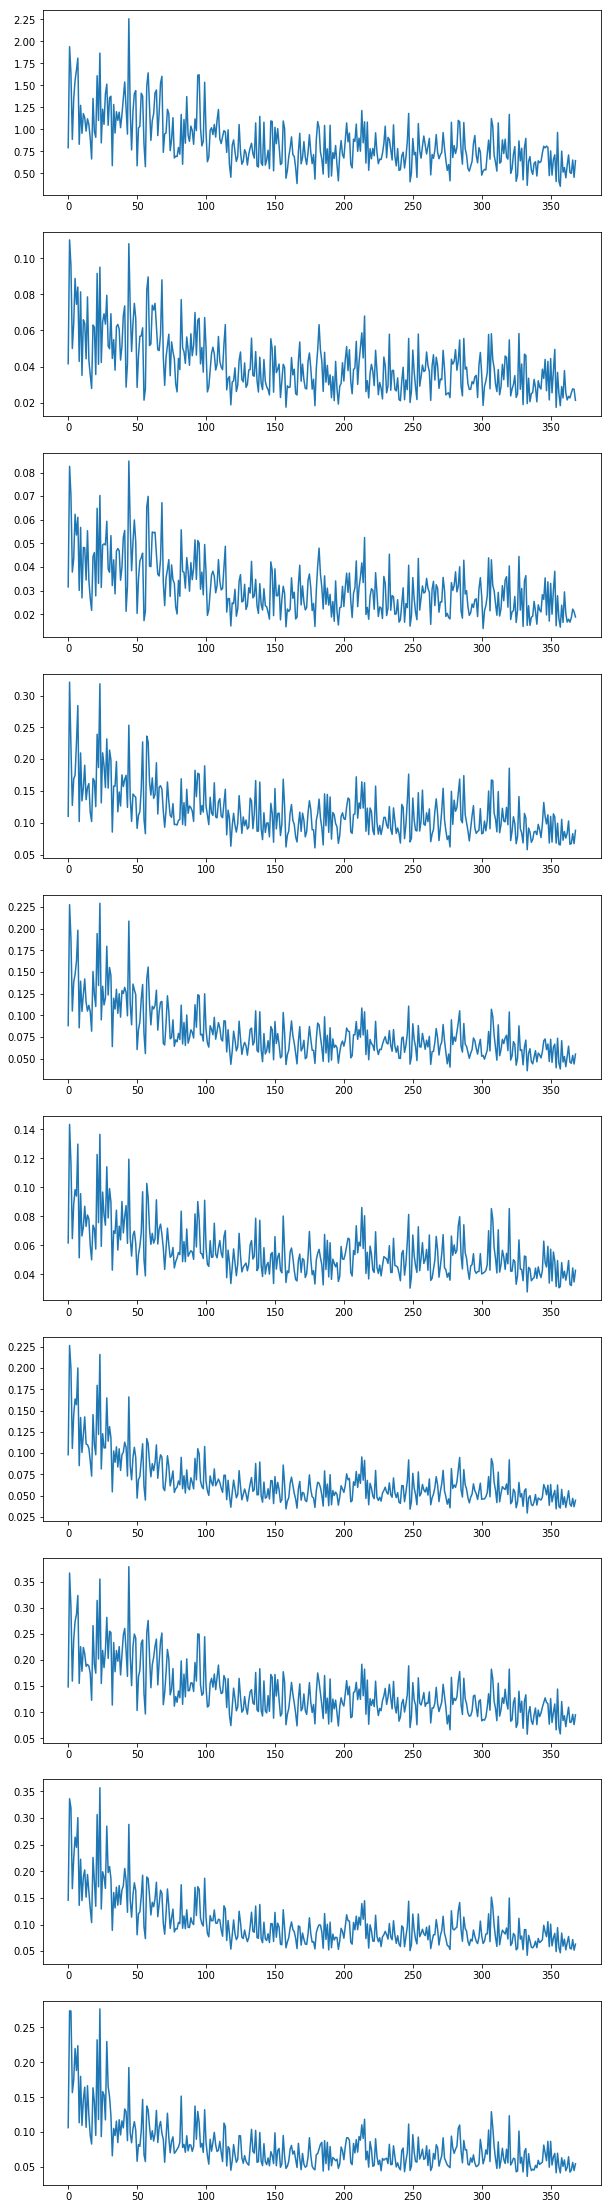

In [76]:
n = 10
fig = plt.figure(figsize=(10, n * 4))
for i, (_, k) in enumerate(change_sorted_weights[:n]):
    ax = fig.add_subplot(n, 1, i+1)
    ax.plot(stat_rec.grad_magnitudes[k])

### Change in loss breakdown

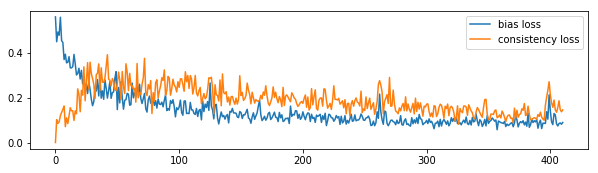

In [77]:
fig = plt.figure(figsize=(10, 30))
ax = fig.add_subplot(n, 1, 1)
ax.plot(monitor.logs["bias_loss"], label="bias loss")
ax.plot(monitor.logs["consistency_loss"], label="consistency loss")
ax.legend()

# Evaluate

Simple prediction

In [78]:
def get_preds(model, batch: TensorDict):
    return model(**batch)["logits"].argmax(2)

In [79]:
to_words(batch["input"]["tokens"])

['[CLS] [MASK] is un ##grate ##ful [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is lazy [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is extreme [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is shorts ##ight ##ed [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is ridiculous [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is frightening [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is bland [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [80]:
to_words(get_preds(model, batch))

['. he is un ##grate . . ᴬ ##32 ##32 ##32 ##32 ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##irus ##¨ ##¨',
 '. he is . . ᴬ ##32 ##32 ##cb ##32 ##32 ##32 ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##¨ ##¨ ##¨ ##00',
 '. it is . . ᴬ ##32 ##32 ##cb ##32 ##32 ##32 ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##irus ##¨ ##¨',
 '. he is self ##ight . . ᴬ ##cd ##32 ##32 ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##¨ ##irus ##¨ ##cb',
 '. this is . . ᴬ ##32 ##00 ##cb ##cb ##32 ##32 ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##¨ ##¨ ##¨ ##¨',
 '. this is . . ᴬ ##32 ##00 ##cb ##32 ##32 ##32 ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##¨ ##irus ##¦ ##cb',
 '. it is . . © ##32 ##32 ##cb ##32 ##32 ##32 ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##irus ##¨ ##¨',
 '. he is rep ##ent . . © ##32 ##32 ##32 latitude ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##irus ##¨ ##cb',
 '. he is gu ##lli ##ble . ᴬ ##32 ##32 ##32 ##32 ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##irus ##¨ ##cb',
 '. it is s ##

### Logits and bias

In [81]:
masked_lm.eval()
logits = masked_lm(processor.to_bert_model_input("[MASK] is a housemaid"))[0, 1]

In [82]:
logits[ttoi("he")]

tensor(8.4917, grad_fn=<SelectBackward>)

In [83]:
logits[ttoi("she")]

tensor(8.0130, grad_fn=<SelectBackward>)

Probabilities

In [84]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [85]:
probs[ttoi("he")]

tensor(0.3848, grad_fn=<SelectBackward>)

In [86]:
probs[ttoi("she")]

tensor(0.2384, grad_fn=<SelectBackward>)

##### For an example not in the vocabulary

In [87]:
logits = masked_lm(processor.to_bert_model_input("[MASK] is a slut"))[0, 1]

In [88]:
logits[ttoi("he")]

tensor(8.3359, grad_fn=<SelectBackward>)

In [89]:
logits[ttoi("she")]

tensor(7.8143, grad_fn=<SelectBackward>)

In [90]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [91]:
probs[ttoi("he")]

tensor(0.3646, grad_fn=<SelectBackward>)

In [92]:
probs[ttoi("she")]

tensor(0.2164, grad_fn=<SelectBackward>)

Changes to output distribution of unrelated sentences

In [93]:
print_topk_preds("i ride my [MASK] to work")

i ride my bike to work:                    0.5379
i ride my motorcycle to work:              0.0808
i ride my bus to work:                     0.0797
i ride my car to work:                     0.0713
i ride my bicycle to work:                 0.0248


In [94]:
print_topk_preds("the [MASK] wagged its tail")

the dog wagged its tail:                     0.2239
the cat wagged its tail:                     0.0882
the bird wagged its tail:                    0.0493
the creature wagged its tail:                0.0342
the wolf wagged its tail:                    0.0320


In [95]:
print_topk_preds("the fish [MASK] through the water")

the fish swam through the water:                    0.0985
the fish flew through the water:                    0.0597
the fish sailed through the water:                  0.0466
the fish ran through the water:                     0.0437
the fish raced through the water:                   0.0409


### Evaluation on bias score across the train and val set

In [96]:
from tqdm import tqdm
tqdm.pandas()

In [97]:
df_train["bias_score_after"] = df_train.progress_apply(compute_bias_score, axis=1)

  0%|          | 0/3936 [00:00<?, ?it/s]

  0%|          | 2/3936 [00:00<04:37, 14.20it/s]

  0%|          | 4/3936 [00:00<04:34, 14.35it/s]

  0%|          | 6/3936 [00:00<04:36, 14.24it/s]

  0%|          | 8/3936 [00:00<04:34, 14.31it/s]

  0%|          | 10/3936 [00:00<04:31, 14.46it/s]

  0%|          | 12/3936 [00:00<04:31, 14.43it/s]

  0%|          | 14/3936 [00:00<04:32, 14.41it/s]

  0%|          | 16/3936 [00:01<04:23, 14.88it/s]

  0%|          | 18/3936 [00:01<04:15, 15.31it/s]

  1%|          | 20/3936 [00:01<04:13, 15.45it/s]

  1%|          | 22/3936 [00:01<04:10, 15.64it/s]

  1%|          | 24/3936 [00:01<04:15, 15.32it/s]

  1%|          | 26/3936 [00:01<04:16, 15.25it/s]

  1%|          | 28/3936 [00:01<04:13, 15.41it/s]

  1%|          | 30/3936 [00:01<04:14, 15.35it/s]

  1%|          | 32/3936 [00:02<04:14, 15.33it/s]

  1%|          | 34/3936 [00:02<04:12, 15.47it/s]

  1%|          | 36/3936 [00:02<04:12, 15.46it/s]

  1%|          | 38/3936 [00:02<04:11, 15.47it/s]

  1%|          | 40/3936 [00:02<04:14, 15.28it/s]

  1%|          | 42/3936 [00:02<04:19, 14.99it/s]

  1%|          | 44/3936 [00:02<04:20, 14.96it/s]

  1%|          | 46/3936 [00:03<04:21, 14.86it/s]

  1%|          | 48/3936 [00:03<04:21, 14.86it/s]

  1%|▏         | 50/3936 [00:03<04:24, 14.68it/s]

  1%|▏         | 52/3936 [00:03<04:25, 14.65it/s]

  1%|▏         | 54/3936 [00:03<04:30, 14.38it/s]

  1%|▏         | 56/3936 [00:03<04:29, 14.42it/s]

  1%|▏         | 58/3936 [00:03<04:30, 14.33it/s]

  2%|▏         | 60/3936 [00:04<04:27, 14.50it/s]

  2%|▏         | 62/3936 [00:04<04:32, 14.20it/s]

  2%|▏         | 64/3936 [00:04<04:30, 14.32it/s]

  2%|▏         | 66/3936 [00:04<04:32, 14.22it/s]

  2%|▏         | 68/3936 [00:04<04:30, 14.29it/s]

  2%|▏         | 70/3936 [00:04<04:33, 14.14it/s]

  2%|▏         | 72/3936 [00:04<04:38, 13.89it/s]

  2%|▏         | 74/3936 [00:05<04:37, 13.93it/s]

  2%|▏         | 76/3936 [00:05<04:35, 14.00it/s]

  2%|▏         | 78/3936 [00:05<04:30, 14.28it/s]

  2%|▏         | 80/3936 [00:05<04:42, 13.67it/s]

  2%|▏         | 82/3936 [00:05<04:51, 13.23it/s]

  2%|▏         | 84/3936 [00:05<04:33, 14.08it/s]

  2%|▏         | 86/3936 [00:05<04:25, 14.51it/s]

  2%|▏         | 88/3936 [00:06<04:18, 14.87it/s]

  2%|▏         | 90/3936 [00:06<04:39, 13.76it/s]

  2%|▏         | 92/3936 [00:06<04:58, 12.88it/s]

  2%|▏         | 94/3936 [00:06<04:52, 13.15it/s]

  2%|▏         | 96/3936 [00:06<04:51, 13.16it/s]

  2%|▏         | 98/3936 [00:06<04:50, 13.21it/s]

  3%|▎         | 100/3936 [00:06<04:51, 13.15it/s]

  3%|▎         | 102/3936 [00:07<04:53, 13.04it/s]

  3%|▎         | 104/3936 [00:07<04:52, 13.11it/s]

  3%|▎         | 106/3936 [00:07<04:47, 13.33it/s]

  3%|▎         | 108/3936 [00:07<04:52, 13.10it/s]

  3%|▎         | 110/3936 [00:07<04:53, 13.02it/s]

  3%|▎         | 112/3936 [00:07<04:45, 13.39it/s]

  3%|▎         | 114/3936 [00:08<04:46, 13.32it/s]

  3%|▎         | 116/3936 [00:08<04:55, 12.92it/s]

  3%|▎         | 118/3936 [00:08<04:58, 12.77it/s]

  3%|▎         | 120/3936 [00:08<05:08, 12.35it/s]

  3%|▎         | 122/3936 [00:08<05:18, 11.96it/s]

  3%|▎         | 124/3936 [00:08<05:22, 11.84it/s]

  3%|▎         | 126/3936 [00:09<06:02, 10.52it/s]

  3%|▎         | 128/3936 [00:09<05:40, 11.18it/s]

  3%|▎         | 130/3936 [00:09<05:20, 11.88it/s]

  3%|▎         | 132/3936 [00:09<05:08, 12.32it/s]

  3%|▎         | 134/3936 [00:09<05:26, 11.63it/s]

  3%|▎         | 136/3936 [00:09<05:36, 11.30it/s]

  4%|▎         | 138/3936 [00:10<05:27, 11.58it/s]

  4%|▎         | 140/3936 [00:10<05:19, 11.88it/s]

  4%|▎         | 142/3936 [00:10<05:14, 12.08it/s]

  4%|▎         | 144/3936 [00:10<05:27, 11.58it/s]

  4%|▎         | 146/3936 [00:10<05:05, 12.43it/s]

  4%|▍         | 148/3936 [00:10<05:00, 12.60it/s]

  4%|▍         | 150/3936 [00:11<04:53, 12.89it/s]

  4%|▍         | 152/3936 [00:11<04:38, 13.61it/s]

  4%|▍         | 154/3936 [00:11<04:24, 14.29it/s]

  4%|▍         | 156/3936 [00:11<04:28, 14.09it/s]

  4%|▍         | 158/3936 [00:11<04:32, 13.85it/s]

  4%|▍         | 160/3936 [00:11<04:35, 13.72it/s]

  4%|▍         | 162/3936 [00:11<04:33, 13.79it/s]

  4%|▍         | 164/3936 [00:12<04:37, 13.58it/s]

  4%|▍         | 166/3936 [00:12<04:37, 13.57it/s]

  4%|▍         | 168/3936 [00:12<04:35, 13.68it/s]

  4%|▍         | 170/3936 [00:12<04:37, 13.59it/s]

  4%|▍         | 172/3936 [00:12<04:27, 14.06it/s]

  4%|▍         | 174/3936 [00:12<04:23, 14.27it/s]

  4%|▍         | 176/3936 [00:12<04:22, 14.33it/s]

  5%|▍         | 178/3936 [00:13<04:17, 14.57it/s]

  5%|▍         | 180/3936 [00:13<04:20, 14.42it/s]

  5%|▍         | 182/3936 [00:13<04:23, 14.24it/s]

  5%|▍         | 184/3936 [00:13<04:22, 14.29it/s]

  5%|▍         | 186/3936 [00:13<04:28, 13.99it/s]

  5%|▍         | 188/3936 [00:13<04:32, 13.76it/s]

  5%|▍         | 190/3936 [00:13<04:33, 13.69it/s]

  5%|▍         | 192/3936 [00:14<04:37, 13.50it/s]

  5%|▍         | 194/3936 [00:14<04:38, 13.43it/s]

  5%|▍         | 196/3936 [00:14<04:33, 13.69it/s]

  5%|▌         | 198/3936 [00:14<04:36, 13.53it/s]

  5%|▌         | 200/3936 [00:14<04:36, 13.50it/s]

  5%|▌         | 202/3936 [00:14<04:42, 13.21it/s]

  5%|▌         | 204/3936 [00:14<04:47, 12.98it/s]

  5%|▌         | 206/3936 [00:15<04:49, 12.89it/s]

  5%|▌         | 208/3936 [00:15<04:47, 12.95it/s]

  5%|▌         | 210/3936 [00:15<04:56, 12.56it/s]

  5%|▌         | 212/3936 [00:15<04:51, 12.79it/s]

  5%|▌         | 214/3936 [00:15<04:54, 12.63it/s]

  5%|▌         | 216/3936 [00:15<04:54, 12.64it/s]

  6%|▌         | 218/3936 [00:16<04:59, 12.42it/s]

  6%|▌         | 220/3936 [00:16<04:54, 12.61it/s]

  6%|▌         | 222/3936 [00:16<04:52, 12.69it/s]

  6%|▌         | 224/3936 [00:16<04:40, 13.21it/s]

  6%|▌         | 226/3936 [00:16<04:30, 13.70it/s]

  6%|▌         | 228/3936 [00:16<04:29, 13.77it/s]

  6%|▌         | 230/3936 [00:16<04:33, 13.55it/s]

  6%|▌         | 232/3936 [00:17<04:34, 13.51it/s]

  6%|▌         | 234/3936 [00:17<04:42, 13.10it/s]

  6%|▌         | 236/3936 [00:17<04:49, 12.77it/s]

  6%|▌         | 238/3936 [00:17<04:32, 13.60it/s]

  6%|▌         | 240/3936 [00:17<04:21, 14.11it/s]

  6%|▌         | 242/3936 [00:17<04:12, 14.65it/s]

  6%|▌         | 244/3936 [00:17<04:49, 12.74it/s]

  6%|▋         | 246/3936 [00:18<04:56, 12.43it/s]

  6%|▋         | 248/3936 [00:18<04:52, 12.60it/s]

  6%|▋         | 250/3936 [00:18<04:47, 12.82it/s]

  6%|▋         | 252/3936 [00:18<04:47, 12.79it/s]

  6%|▋         | 254/3936 [00:18<04:52, 12.60it/s]

  7%|▋         | 256/3936 [00:18<05:01, 12.21it/s]

  7%|▋         | 258/3936 [00:19<05:06, 12.02it/s]

  7%|▋         | 260/3936 [00:19<05:05, 12.03it/s]

  7%|▋         | 262/3936 [00:19<05:04, 12.05it/s]

  7%|▋         | 264/3936 [00:19<05:03, 12.09it/s]

  7%|▋         | 266/3936 [00:19<05:03, 12.11it/s]

  7%|▋         | 268/3936 [00:19<04:54, 12.47it/s]

  7%|▋         | 270/3936 [00:20<04:47, 12.74it/s]

  7%|▋         | 272/3936 [00:20<04:55, 12.42it/s]

  7%|▋         | 274/3936 [00:20<04:55, 12.41it/s]

  7%|▋         | 276/3936 [00:20<04:58, 12.25it/s]

  7%|▋         | 278/3936 [00:20<04:58, 12.27it/s]

  7%|▋         | 280/3936 [00:20<05:07, 11.91it/s]

  7%|▋         | 282/3936 [00:21<04:58, 12.25it/s]

  7%|▋         | 284/3936 [00:21<05:00, 12.16it/s]

  7%|▋         | 286/3936 [00:21<04:57, 12.28it/s]

  7%|▋         | 288/3936 [00:21<04:58, 12.23it/s]

  7%|▋         | 290/3936 [00:21<05:07, 11.87it/s]

  7%|▋         | 292/3936 [00:21<04:58, 12.20it/s]

  7%|▋         | 294/3936 [00:22<04:58, 12.20it/s]

  8%|▊         | 296/3936 [00:22<04:58, 12.21it/s]

  8%|▊         | 298/3936 [00:22<04:53, 12.38it/s]

  8%|▊         | 300/3936 [00:22<04:40, 12.94it/s]

  8%|▊         | 302/3936 [00:22<04:36, 13.15it/s]

  8%|▊         | 304/3936 [00:22<04:30, 13.45it/s]

  8%|▊         | 306/3936 [00:22<04:22, 13.82it/s]

  8%|▊         | 308/3936 [00:23<04:18, 14.04it/s]

  8%|▊         | 310/3936 [00:23<04:13, 14.32it/s]

  8%|▊         | 312/3936 [00:23<04:11, 14.40it/s]

  8%|▊         | 314/3936 [00:23<04:14, 14.24it/s]

  8%|▊         | 316/3936 [00:23<04:12, 14.33it/s]

  8%|▊         | 318/3936 [00:23<04:18, 13.98it/s]

  8%|▊         | 320/3936 [00:23<04:23, 13.74it/s]

  8%|▊         | 322/3936 [00:24<04:17, 14.06it/s]

  8%|▊         | 324/3936 [00:24<04:29, 13.40it/s]

  8%|▊         | 326/3936 [00:24<04:38, 12.97it/s]

  8%|▊         | 328/3936 [00:24<04:42, 12.79it/s]

  8%|▊         | 330/3936 [00:24<04:44, 12.69it/s]

  8%|▊         | 332/3936 [00:24<04:39, 12.88it/s]

  8%|▊         | 334/3936 [00:25<04:52, 12.32it/s]

  9%|▊         | 336/3936 [00:25<04:59, 12.00it/s]

  9%|▊         | 338/3936 [00:25<05:01, 11.93it/s]

  9%|▊         | 340/3936 [00:25<05:41, 10.53it/s]

  9%|▊         | 342/3936 [00:25<05:30, 10.87it/s]

  9%|▊         | 344/3936 [00:25<05:17, 11.30it/s]

  9%|▉         | 346/3936 [00:26<05:20, 11.18it/s]

  9%|▉         | 348/3936 [00:26<05:10, 11.55it/s]

  9%|▉         | 350/3936 [00:26<04:58, 12.00it/s]

  9%|▉         | 352/3936 [00:26<04:53, 12.20it/s]

  9%|▉         | 354/3936 [00:26<04:55, 12.10it/s]

  9%|▉         | 356/3936 [00:26<04:48, 12.39it/s]

  9%|▉         | 358/3936 [00:27<04:37, 12.89it/s]

  9%|▉         | 360/3936 [00:27<04:35, 12.98it/s]

  9%|▉         | 362/3936 [00:27<04:41, 12.69it/s]

  9%|▉         | 364/3936 [00:27<04:38, 12.82it/s]

  9%|▉         | 366/3936 [00:27<04:55, 12.08it/s]

  9%|▉         | 368/3936 [00:27<04:57, 12.01it/s]

  9%|▉         | 370/3936 [00:28<04:53, 12.14it/s]

  9%|▉         | 372/3936 [00:28<04:39, 12.77it/s]

 10%|▉         | 374/3936 [00:28<04:42, 12.62it/s]

 10%|▉         | 376/3936 [00:28<04:52, 12.16it/s]

 10%|▉         | 378/3936 [00:28<04:49, 12.31it/s]

 10%|▉         | 380/3936 [00:28<04:53, 12.10it/s]

 10%|▉         | 382/3936 [00:29<04:55, 12.03it/s]

 10%|▉         | 384/3936 [00:29<05:01, 11.79it/s]

 10%|▉         | 386/3936 [00:29<05:03, 11.71it/s]

 10%|▉         | 388/3936 [00:29<04:41, 12.61it/s]

 10%|▉         | 390/3936 [00:29<04:32, 13.02it/s]

 10%|▉         | 392/3936 [00:29<04:38, 12.74it/s]

 10%|█         | 394/3936 [00:30<04:58, 11.85it/s]

 10%|█         | 396/3936 [00:30<05:03, 11.65it/s]

 10%|█         | 398/3936 [00:30<04:49, 12.21it/s]

 10%|█         | 400/3936 [00:30<04:45, 12.38it/s]

 10%|█         | 402/3936 [00:30<04:53, 12.04it/s]

 10%|█         | 404/3936 [00:30<04:48, 12.24it/s]

 10%|█         | 406/3936 [00:31<04:47, 12.29it/s]

 10%|█         | 408/3936 [00:31<04:42, 12.48it/s]

 10%|█         | 410/3936 [00:31<04:46, 12.32it/s]

 10%|█         | 412/3936 [00:31<04:38, 12.65it/s]

 11%|█         | 414/3936 [00:31<04:41, 12.49it/s]

 11%|█         | 416/3936 [00:31<04:38, 12.63it/s]

 11%|█         | 418/3936 [00:31<04:46, 12.29it/s]

 11%|█         | 420/3936 [00:32<04:47, 12.21it/s]

 11%|█         | 422/3936 [00:32<04:55, 11.90it/s]

 11%|█         | 424/3936 [00:32<04:56, 11.85it/s]

 11%|█         | 426/3936 [00:32<04:57, 11.82it/s]

 11%|█         | 428/3936 [00:32<04:49, 12.12it/s]

 11%|█         | 430/3936 [00:32<04:46, 12.26it/s]

 11%|█         | 432/3936 [00:33<04:39, 12.52it/s]

 11%|█         | 434/3936 [00:33<04:36, 12.67it/s]

 11%|█         | 436/3936 [00:33<04:34, 12.74it/s]

 11%|█         | 438/3936 [00:33<04:40, 12.46it/s]

 11%|█         | 440/3936 [00:33<04:40, 12.45it/s]

 11%|█         | 442/3936 [00:33<04:34, 12.72it/s]

 11%|█▏        | 444/3936 [00:34<04:25, 13.15it/s]

 11%|█▏        | 446/3936 [00:34<04:26, 13.10it/s]

 11%|█▏        | 448/3936 [00:34<04:14, 13.69it/s]

 11%|█▏        | 450/3936 [00:34<04:06, 14.14it/s]

 11%|█▏        | 452/3936 [00:34<04:07, 14.08it/s]

 12%|█▏        | 454/3936 [00:34<04:01, 14.44it/s]

 12%|█▏        | 456/3936 [00:34<03:54, 14.84it/s]

 12%|█▏        | 458/3936 [00:35<03:59, 14.52it/s]

 12%|█▏        | 460/3936 [00:35<03:59, 14.49it/s]

 12%|█▏        | 462/3936 [00:35<03:58, 14.58it/s]

 12%|█▏        | 464/3936 [00:35<04:00, 14.44it/s]

 12%|█▏        | 466/3936 [00:35<04:04, 14.20it/s]

 12%|█▏        | 468/3936 [00:35<04:07, 14.03it/s]

 12%|█▏        | 470/3936 [00:35<04:06, 14.05it/s]

 12%|█▏        | 472/3936 [00:36<04:01, 14.34it/s]

 12%|█▏        | 474/3936 [00:36<03:57, 14.59it/s]

 12%|█▏        | 476/3936 [00:36<03:56, 14.62it/s]

 12%|█▏        | 478/3936 [00:36<03:58, 14.51it/s]

 12%|█▏        | 480/3936 [00:36<03:55, 14.69it/s]

 12%|█▏        | 482/3936 [00:36<04:01, 14.29it/s]

 12%|█▏        | 484/3936 [00:36<03:59, 14.39it/s]

 12%|█▏        | 486/3936 [00:36<03:59, 14.42it/s]

 12%|█▏        | 488/3936 [00:37<04:01, 14.28it/s]

 12%|█▏        | 490/3936 [00:37<04:06, 13.99it/s]

 12%|█▎        | 492/3936 [00:37<04:08, 13.86it/s]

 13%|█▎        | 494/3936 [00:37<04:07, 13.90it/s]

 13%|█▎        | 496/3936 [00:37<04:03, 14.13it/s]

 13%|█▎        | 498/3936 [00:37<04:00, 14.30it/s]

 13%|█▎        | 500/3936 [00:37<04:02, 14.15it/s]

 13%|█▎        | 502/3936 [00:38<04:06, 13.95it/s]

 13%|█▎        | 504/3936 [00:38<04:13, 13.52it/s]

 13%|█▎        | 506/3936 [00:38<04:13, 13.54it/s]

 13%|█▎        | 508/3936 [00:38<04:08, 13.78it/s]

 13%|█▎        | 510/3936 [00:38<04:07, 13.86it/s]

 13%|█▎        | 512/3936 [00:38<04:09, 13.71it/s]

 13%|█▎        | 514/3936 [00:38<04:02, 14.12it/s]

 13%|█▎        | 516/3936 [00:39<03:56, 14.43it/s]

 13%|█▎        | 518/3936 [00:39<03:56, 14.46it/s]

 13%|█▎        | 520/3936 [00:39<04:03, 14.00it/s]

 13%|█▎        | 522/3936 [00:39<04:07, 13.80it/s]

 13%|█▎        | 524/3936 [00:39<04:08, 13.72it/s]

 13%|█▎        | 526/3936 [00:39<04:11, 13.56it/s]

 13%|█▎        | 528/3936 [00:40<04:11, 13.57it/s]

 13%|█▎        | 530/3936 [00:40<04:13, 13.41it/s]

 14%|█▎        | 532/3936 [00:40<04:08, 13.70it/s]

 14%|█▎        | 534/3936 [00:40<04:06, 13.82it/s]

 14%|█▎        | 536/3936 [00:40<04:11, 13.54it/s]

 14%|█▎        | 538/3936 [00:40<04:17, 13.22it/s]

 14%|█▎        | 540/3936 [00:40<04:08, 13.68it/s]

 14%|█▍        | 542/3936 [00:41<03:58, 14.22it/s]

 14%|█▍        | 544/3936 [00:41<03:58, 14.22it/s]

 14%|█▍        | 546/3936 [00:41<04:08, 13.64it/s]

 14%|█▍        | 548/3936 [00:41<04:13, 13.38it/s]

 14%|█▍        | 550/3936 [00:41<04:09, 13.57it/s]

 14%|█▍        | 552/3936 [00:41<04:09, 13.55it/s]

 14%|█▍        | 554/3936 [00:41<04:08, 13.59it/s]

 14%|█▍        | 556/3936 [00:42<04:06, 13.72it/s]

 14%|█▍        | 558/3936 [00:42<04:05, 13.74it/s]

 14%|█▍        | 560/3936 [00:42<04:05, 13.73it/s]

 14%|█▍        | 562/3936 [00:42<04:02, 13.91it/s]

 14%|█▍        | 564/3936 [00:42<04:01, 13.99it/s]

 14%|█▍        | 566/3936 [00:42<04:04, 13.80it/s]

 14%|█▍        | 568/3936 [00:42<04:01, 13.97it/s]

 14%|█▍        | 570/3936 [00:43<03:59, 14.06it/s]

 15%|█▍        | 572/3936 [00:43<04:01, 13.96it/s]

 15%|█▍        | 574/3936 [00:43<04:00, 13.99it/s]

 15%|█▍        | 576/3936 [00:43<03:58, 14.07it/s]

 15%|█▍        | 578/3936 [00:43<04:02, 13.87it/s]

 15%|█▍        | 580/3936 [00:43<04:01, 13.89it/s]

 15%|█▍        | 582/3936 [00:43<04:05, 13.69it/s]

 15%|█▍        | 584/3936 [00:44<04:01, 13.88it/s]

 15%|█▍        | 586/3936 [00:44<04:00, 13.93it/s]

 15%|█▍        | 588/3936 [00:44<03:59, 14.00it/s]

 15%|█▍        | 590/3936 [00:44<04:00, 13.89it/s]

 15%|█▌        | 592/3936 [00:44<04:08, 13.48it/s]

 15%|█▌        | 594/3936 [00:44<04:13, 13.17it/s]

 15%|█▌        | 596/3936 [00:44<04:15, 13.09it/s]

 15%|█▌        | 598/3936 [00:45<04:14, 13.14it/s]

 15%|█▌        | 600/3936 [00:45<04:16, 13.02it/s]

 15%|█▌        | 602/3936 [00:45<04:18, 12.88it/s]

 15%|█▌        | 604/3936 [00:45<04:15, 13.07it/s]

 15%|█▌        | 606/3936 [00:45<04:15, 13.03it/s]

 15%|█▌        | 608/3936 [00:45<04:09, 13.32it/s]

 15%|█▌        | 610/3936 [00:46<04:02, 13.74it/s]

 16%|█▌        | 612/3936 [00:46<03:56, 14.08it/s]

 16%|█▌        | 614/3936 [00:46<03:59, 13.89it/s]

 16%|█▌        | 616/3936 [00:46<04:00, 13.80it/s]

 16%|█▌        | 618/3936 [00:46<03:56, 14.01it/s]

 16%|█▌        | 620/3936 [00:46<03:56, 14.00it/s]

 16%|█▌        | 622/3936 [00:46<03:54, 14.12it/s]

 16%|█▌        | 624/3936 [00:47<03:54, 14.12it/s]

 16%|█▌        | 626/3936 [00:47<03:59, 13.81it/s]

 16%|█▌        | 628/3936 [00:47<03:57, 13.93it/s]

 16%|█▌        | 630/3936 [00:47<03:52, 14.22it/s]

 16%|█▌        | 632/3936 [00:47<03:51, 14.30it/s]

 16%|█▌        | 634/3936 [00:47<03:51, 14.28it/s]

 16%|█▌        | 636/3936 [00:47<03:48, 14.42it/s]

 16%|█▌        | 638/3936 [00:47<03:51, 14.26it/s]

 16%|█▋        | 640/3936 [00:48<03:48, 14.44it/s]

 16%|█▋        | 642/3936 [00:48<03:47, 14.46it/s]

 16%|█▋        | 644/3936 [00:48<03:47, 14.49it/s]

 16%|█▋        | 646/3936 [00:48<03:47, 14.44it/s]

 16%|█▋        | 648/3936 [00:48<03:47, 14.43it/s]

 17%|█▋        | 650/3936 [00:48<03:44, 14.62it/s]

 17%|█▋        | 652/3936 [00:48<03:41, 14.83it/s]

 17%|█▋        | 654/3936 [00:49<03:40, 14.86it/s]

 17%|█▋        | 656/3936 [00:49<03:44, 14.60it/s]

 17%|█▋        | 658/3936 [00:49<03:43, 14.65it/s]

 17%|█▋        | 660/3936 [00:49<03:46, 14.44it/s]

 17%|█▋        | 662/3936 [00:49<03:50, 14.20it/s]

 17%|█▋        | 664/3936 [00:49<03:47, 14.39it/s]

 17%|█▋        | 666/3936 [00:49<03:45, 14.52it/s]

 17%|█▋        | 668/3936 [00:50<03:41, 14.74it/s]

 17%|█▋        | 670/3936 [00:50<03:42, 14.68it/s]

 17%|█▋        | 672/3936 [00:50<03:39, 14.85it/s]

 17%|█▋        | 674/3936 [00:50<03:40, 14.77it/s]

 17%|█▋        | 676/3936 [00:50<03:38, 14.93it/s]

 17%|█▋        | 678/3936 [00:50<03:41, 14.74it/s]

 17%|█▋        | 680/3936 [00:50<03:43, 14.59it/s]

 17%|█▋        | 682/3936 [00:51<03:44, 14.46it/s]

 17%|█▋        | 684/3936 [00:51<03:41, 14.67it/s]

 17%|█▋        | 686/3936 [00:51<03:42, 14.60it/s]

 17%|█▋        | 688/3936 [00:51<03:45, 14.41it/s]

 18%|█▊        | 690/3936 [00:51<03:45, 14.38it/s]

 18%|█▊        | 692/3936 [00:51<03:49, 14.11it/s]

 18%|█▊        | 694/3936 [00:51<04:00, 13.49it/s]

 18%|█▊        | 696/3936 [00:52<04:02, 13.37it/s]

 18%|█▊        | 698/3936 [00:52<03:46, 14.32it/s]

 18%|█▊        | 700/3936 [00:52<03:35, 15.03it/s]

 18%|█▊        | 702/3936 [00:52<03:28, 15.48it/s]

 18%|█▊        | 704/3936 [00:52<03:44, 14.39it/s]

 18%|█▊        | 706/3936 [00:52<04:11, 12.85it/s]

 18%|█▊        | 708/3936 [00:52<04:05, 13.15it/s]

 18%|█▊        | 710/3936 [00:53<04:02, 13.32it/s]

 18%|█▊        | 712/3936 [00:53<04:03, 13.26it/s]

 18%|█▊        | 714/3936 [00:53<04:00, 13.41it/s]

 18%|█▊        | 716/3936 [00:53<03:54, 13.72it/s]

 18%|█▊        | 718/3936 [00:53<03:52, 13.82it/s]

 18%|█▊        | 720/3936 [00:53<03:51, 13.87it/s]

 18%|█▊        | 722/3936 [00:53<03:51, 13.86it/s]

 18%|█▊        | 724/3936 [00:54<03:49, 14.00it/s]

 18%|█▊        | 726/3936 [00:54<03:49, 13.97it/s]

 18%|█▊        | 728/3936 [00:54<03:53, 13.71it/s]

 19%|█▊        | 730/3936 [00:54<03:51, 13.86it/s]

 19%|█▊        | 732/3936 [00:54<03:52, 13.77it/s]

 19%|█▊        | 734/3936 [00:54<03:52, 13.78it/s]

 19%|█▊        | 736/3936 [00:54<03:50, 13.86it/s]

 19%|█▉        | 738/3936 [00:55<03:50, 13.89it/s]

 19%|█▉        | 740/3936 [00:55<03:45, 14.19it/s]

 19%|█▉        | 742/3936 [00:55<03:44, 14.23it/s]

 19%|█▉        | 744/3936 [00:55<03:45, 14.15it/s]

 19%|█▉        | 746/3936 [00:55<03:45, 14.15it/s]

 19%|█▉        | 748/3936 [00:55<03:47, 14.02it/s]

 19%|█▉        | 750/3936 [00:55<03:50, 13.81it/s]

 19%|█▉        | 752/3936 [00:56<03:50, 13.81it/s]

 19%|█▉        | 754/3936 [00:56<03:46, 14.03it/s]

 19%|█▉        | 756/3936 [00:56<03:58, 13.34it/s]

 19%|█▉        | 758/3936 [00:56<03:54, 13.56it/s]

 19%|█▉        | 760/3936 [00:56<03:49, 13.83it/s]

 19%|█▉        | 762/3936 [00:56<03:51, 13.71it/s]

 19%|█▉        | 764/3936 [00:56<03:41, 14.30it/s]

 19%|█▉        | 766/3936 [00:57<03:35, 14.73it/s]

 20%|█▉        | 768/3936 [00:57<03:27, 15.28it/s]

 20%|█▉        | 770/3936 [00:57<03:26, 15.34it/s]

 20%|█▉        | 772/3936 [00:57<03:19, 15.88it/s]

 20%|█▉        | 774/3936 [00:57<03:17, 16.00it/s]

 20%|█▉        | 776/3936 [00:57<03:20, 15.75it/s]

 20%|█▉        | 778/3936 [00:57<03:22, 15.58it/s]

 20%|█▉        | 780/3936 [00:57<03:21, 15.65it/s]

 20%|█▉        | 782/3936 [00:58<03:21, 15.62it/s]

 20%|█▉        | 784/3936 [00:58<03:23, 15.47it/s]

 20%|█▉        | 786/3936 [00:58<03:26, 15.28it/s]

 20%|██        | 788/3936 [00:58<03:22, 15.58it/s]

 20%|██        | 790/3936 [00:58<03:18, 15.81it/s]

 20%|██        | 792/3936 [00:58<03:17, 15.89it/s]

 20%|██        | 794/3936 [00:58<03:16, 16.01it/s]

 20%|██        | 796/3936 [00:58<03:14, 16.10it/s]

 20%|██        | 798/3936 [00:59<03:14, 16.16it/s]

 20%|██        | 800/3936 [00:59<03:12, 16.30it/s]

 20%|██        | 802/3936 [00:59<03:17, 15.88it/s]

 20%|██        | 804/3936 [00:59<03:17, 15.82it/s]

 20%|██        | 806/3936 [00:59<03:18, 15.78it/s]

 21%|██        | 808/3936 [00:59<03:19, 15.69it/s]

 21%|██        | 810/3936 [00:59<03:21, 15.53it/s]

 21%|██        | 812/3936 [00:59<03:25, 15.20it/s]

 21%|██        | 814/3936 [01:00<03:25, 15.19it/s]

 21%|██        | 816/3936 [01:00<03:24, 15.25it/s]

 21%|██        | 818/3936 [01:00<03:23, 15.31it/s]

 21%|██        | 820/3936 [01:00<03:24, 15.24it/s]

 21%|██        | 822/3936 [01:00<03:22, 15.40it/s]

 21%|██        | 824/3936 [01:00<03:25, 15.17it/s]

 21%|██        | 826/3936 [01:00<03:32, 14.66it/s]

 21%|██        | 828/3936 [01:01<03:29, 14.83it/s]

 21%|██        | 830/3936 [01:01<03:29, 14.83it/s]

 21%|██        | 832/3936 [01:01<03:28, 14.86it/s]

 21%|██        | 834/3936 [01:01<03:30, 14.72it/s]

 21%|██        | 836/3936 [01:01<03:30, 14.70it/s]

 21%|██▏       | 838/3936 [01:01<03:30, 14.73it/s]

 21%|██▏       | 840/3936 [01:01<03:28, 14.85it/s]

 21%|██▏       | 842/3936 [01:01<03:29, 14.78it/s]

 21%|██▏       | 844/3936 [01:02<03:27, 14.89it/s]

 21%|██▏       | 846/3936 [01:02<03:24, 15.12it/s]

 22%|██▏       | 848/3936 [01:02<03:26, 14.92it/s]

 22%|██▏       | 850/3936 [01:02<03:23, 15.14it/s]

 22%|██▏       | 852/3936 [01:02<03:21, 15.31it/s]

 22%|██▏       | 854/3936 [01:02<03:28, 14.78it/s]

 22%|██▏       | 856/3936 [01:02<03:29, 14.71it/s]

 22%|██▏       | 858/3936 [01:03<03:32, 14.49it/s]

 22%|██▏       | 860/3936 [01:03<03:41, 13.89it/s]

 22%|██▏       | 862/3936 [01:03<03:51, 13.29it/s]

 22%|██▏       | 864/3936 [01:03<03:38, 14.09it/s]

 22%|██▏       | 866/3936 [01:03<03:30, 14.61it/s]

 22%|██▏       | 868/3936 [01:03<03:31, 14.50it/s]

 22%|██▏       | 870/3936 [01:03<03:49, 13.38it/s]

 22%|██▏       | 872/3936 [01:04<03:55, 12.99it/s]

 22%|██▏       | 874/3936 [01:04<03:54, 13.05it/s]

 22%|██▏       | 876/3936 [01:04<04:19, 11.80it/s]

 22%|██▏       | 878/3936 [01:04<04:14, 12.01it/s]

 22%|██▏       | 880/3936 [01:04<04:17, 11.86it/s]

 22%|██▏       | 882/3936 [01:05<05:00, 10.15it/s]

 22%|██▏       | 884/3936 [01:05<04:57, 10.26it/s]

 23%|██▎       | 886/3936 [01:05<05:12,  9.75it/s]

 23%|██▎       | 888/3936 [01:05<04:56, 10.27it/s]

 23%|██▎       | 890/3936 [01:05<04:49, 10.51it/s]

 23%|██▎       | 892/3936 [01:06<05:05,  9.95it/s]

 23%|██▎       | 894/3936 [01:06<05:02, 10.06it/s]

 23%|██▎       | 896/3936 [01:06<04:53, 10.37it/s]

 23%|██▎       | 898/3936 [01:06<04:41, 10.79it/s]

 23%|██▎       | 900/3936 [01:06<05:12,  9.72it/s]

 23%|██▎       | 902/3936 [01:07<05:07,  9.86it/s]

 23%|██▎       | 904/3936 [01:07<04:54, 10.28it/s]

 23%|██▎       | 906/3936 [01:07<04:36, 10.97it/s]

 23%|██▎       | 908/3936 [01:07<04:26, 11.35it/s]

 23%|██▎       | 910/3936 [01:07<04:42, 10.73it/s]

 23%|██▎       | 912/3936 [01:07<05:04,  9.93it/s]

 23%|██▎       | 914/3936 [01:08<05:15,  9.59it/s]

 23%|██▎       | 916/3936 [01:08<04:52, 10.34it/s]

 23%|██▎       | 918/3936 [01:08<04:30, 11.14it/s]

 23%|██▎       | 920/3936 [01:08<04:15, 11.83it/s]

 23%|██▎       | 922/3936 [01:08<03:56, 12.75it/s]

 23%|██▎       | 924/3936 [01:08<03:45, 13.33it/s]

 24%|██▎       | 926/3936 [01:09<03:33, 14.07it/s]

 24%|██▎       | 928/3936 [01:09<03:25, 14.62it/s]

 24%|██▎       | 930/3936 [01:09<03:18, 15.17it/s]

 24%|██▎       | 932/3936 [01:09<03:17, 15.23it/s]

 24%|██▎       | 934/3936 [01:09<03:13, 15.50it/s]

 24%|██▍       | 936/3936 [01:09<03:14, 15.45it/s]

 24%|██▍       | 938/3936 [01:09<03:13, 15.49it/s]

 24%|██▍       | 940/3936 [01:09<03:14, 15.40it/s]

 24%|██▍       | 942/3936 [01:10<03:13, 15.45it/s]

 24%|██▍       | 944/3936 [01:10<03:11, 15.61it/s]

 24%|██▍       | 946/3936 [01:10<03:09, 15.80it/s]

 24%|██▍       | 948/3936 [01:10<03:06, 15.99it/s]

 24%|██▍       | 950/3936 [01:10<03:06, 16.05it/s]

 24%|██▍       | 952/3936 [01:10<03:04, 16.16it/s]

 24%|██▍       | 954/3936 [01:10<03:03, 16.24it/s]

 24%|██▍       | 956/3936 [01:10<03:04, 16.17it/s]

 24%|██▍       | 958/3936 [01:11<03:03, 16.26it/s]

 24%|██▍       | 960/3936 [01:11<03:03, 16.23it/s]

 24%|██▍       | 962/3936 [01:11<03:06, 15.94it/s]

 24%|██▍       | 964/3936 [01:11<03:06, 15.94it/s]

 25%|██▍       | 966/3936 [01:11<03:06, 15.89it/s]

 25%|██▍       | 968/3936 [01:11<03:07, 15.83it/s]

 25%|██▍       | 970/3936 [01:11<03:08, 15.77it/s]

 25%|██▍       | 972/3936 [01:11<03:11, 15.49it/s]

 25%|██▍       | 974/3936 [01:12<03:12, 15.37it/s]

 25%|██▍       | 976/3936 [01:12<03:15, 15.18it/s]

 25%|██▍       | 978/3936 [01:12<03:15, 15.14it/s]

 25%|██▍       | 980/3936 [01:12<03:16, 15.01it/s]

 25%|██▍       | 982/3936 [01:12<03:19, 14.80it/s]

 25%|██▌       | 984/3936 [01:12<03:26, 14.30it/s]

 25%|██▌       | 986/3936 [01:12<03:24, 14.41it/s]

 25%|██▌       | 988/3936 [01:13<03:23, 14.46it/s]

 25%|██▌       | 990/3936 [01:13<03:20, 14.72it/s]

 25%|██▌       | 992/3936 [01:13<03:19, 14.74it/s]

 25%|██▌       | 994/3936 [01:13<03:16, 15.00it/s]

 25%|██▌       | 996/3936 [01:13<03:16, 14.99it/s]

 25%|██▌       | 998/3936 [01:13<03:15, 15.03it/s]

 25%|██▌       | 1000/3936 [01:13<03:17, 14.86it/s]

 25%|██▌       | 1002/3936 [01:13<03:25, 14.29it/s]

 26%|██▌       | 1004/3936 [01:14<03:21, 14.55it/s]

 26%|██▌       | 1006/3936 [01:14<03:19, 14.68it/s]

 26%|██▌       | 1008/3936 [01:14<03:19, 14.67it/s]

 26%|██▌       | 1010/3936 [01:14<03:50, 12.67it/s]

 26%|██▌       | 1012/3936 [01:14<03:53, 12.54it/s]

 26%|██▌       | 1014/3936 [01:14<03:57, 12.31it/s]

 26%|██▌       | 1016/3936 [01:15<04:01, 12.11it/s]

 26%|██▌       | 1018/3936 [01:15<04:21, 11.16it/s]

 26%|██▌       | 1020/3936 [01:15<04:19, 11.23it/s]

 26%|██▌       | 1022/3936 [01:15<03:53, 12.49it/s]

 26%|██▌       | 1024/3936 [01:15<03:37, 13.41it/s]

 26%|██▌       | 1026/3936 [01:15<03:42, 13.06it/s]

 26%|██▌       | 1028/3936 [01:16<03:59, 12.14it/s]

 26%|██▌       | 1030/3936 [01:16<04:15, 11.39it/s]

 26%|██▌       | 1032/3936 [01:16<04:09, 11.65it/s]

 26%|██▋       | 1034/3936 [01:16<04:07, 11.74it/s]

 26%|██▋       | 1036/3936 [01:16<04:19, 11.18it/s]

 26%|██▋       | 1038/3936 [01:16<04:15, 11.33it/s]

 26%|██▋       | 1040/3936 [01:17<04:23, 10.97it/s]

 26%|██▋       | 1042/3936 [01:17<04:21, 11.06it/s]

 27%|██▋       | 1044/3936 [01:17<04:31, 10.66it/s]

 27%|██▋       | 1046/3936 [01:17<04:52,  9.88it/s]

 27%|██▋       | 1048/3936 [01:17<04:38, 10.38it/s]

 27%|██▋       | 1050/3936 [01:18<04:29, 10.69it/s]

 27%|██▋       | 1052/3936 [01:18<04:15, 11.28it/s]

 27%|██▋       | 1054/3936 [01:18<04:16, 11.24it/s]

 27%|██▋       | 1056/3936 [01:18<04:29, 10.68it/s]

 27%|██▋       | 1058/3936 [01:18<04:33, 10.54it/s]

 27%|██▋       | 1060/3936 [01:19<04:27, 10.73it/s]

 27%|██▋       | 1062/3936 [01:19<04:17, 11.15it/s]

 27%|██▋       | 1064/3936 [01:19<04:35, 10.42it/s]

 27%|██▋       | 1066/3936 [01:19<04:25, 10.79it/s]

 27%|██▋       | 1068/3936 [01:19<04:29, 10.65it/s]

 27%|██▋       | 1070/3936 [01:19<04:28, 10.68it/s]

 27%|██▋       | 1072/3936 [01:20<04:44, 10.08it/s]

 27%|██▋       | 1074/3936 [01:20<04:35, 10.38it/s]

 27%|██▋       | 1076/3936 [01:20<04:32, 10.49it/s]

 27%|██▋       | 1078/3936 [01:20<04:16, 11.13it/s]

 27%|██▋       | 1080/3936 [01:20<04:01, 11.80it/s]

 27%|██▋       | 1082/3936 [01:21<03:56, 12.07it/s]

 28%|██▊       | 1084/3936 [01:21<03:43, 12.74it/s]

 28%|██▊       | 1086/3936 [01:21<03:37, 13.09it/s]

 28%|██▊       | 1088/3936 [01:21<03:34, 13.25it/s]

 28%|██▊       | 1090/3936 [01:21<03:31, 13.46it/s]

 28%|██▊       | 1092/3936 [01:21<03:29, 13.60it/s]

 28%|██▊       | 1094/3936 [01:21<03:27, 13.70it/s]

 28%|██▊       | 1096/3936 [01:22<03:29, 13.58it/s]

 28%|██▊       | 1098/3936 [01:22<03:27, 13.68it/s]

 28%|██▊       | 1100/3936 [01:22<03:25, 13.82it/s]

 28%|██▊       | 1102/3936 [01:22<03:27, 13.66it/s]

 28%|██▊       | 1104/3936 [01:22<03:23, 13.93it/s]

 28%|██▊       | 1106/3936 [01:22<03:20, 14.12it/s]

 28%|██▊       | 1108/3936 [01:22<03:20, 14.10it/s]

 28%|██▊       | 1110/3936 [01:23<03:23, 13.90it/s]

 28%|██▊       | 1112/3936 [01:23<03:23, 13.91it/s]

 28%|██▊       | 1114/3936 [01:23<03:26, 13.69it/s]

 28%|██▊       | 1116/3936 [01:23<03:26, 13.63it/s]

 28%|██▊       | 1118/3936 [01:23<03:28, 13.50it/s]

 28%|██▊       | 1120/3936 [01:23<03:25, 13.72it/s]

 29%|██▊       | 1122/3936 [01:23<03:24, 13.73it/s]

 29%|██▊       | 1124/3936 [01:24<03:22, 13.86it/s]

 29%|██▊       | 1126/3936 [01:24<03:22, 13.90it/s]

 29%|██▊       | 1128/3936 [01:24<03:22, 13.86it/s]

 29%|██▊       | 1130/3936 [01:24<03:20, 13.99it/s]

 29%|██▉       | 1132/3936 [01:24<03:30, 13.32it/s]

 29%|██▉       | 1134/3936 [01:24<03:37, 12.88it/s]

 29%|██▉       | 1136/3936 [01:24<03:37, 12.89it/s]

 29%|██▉       | 1138/3936 [01:25<03:42, 12.60it/s]

 29%|██▉       | 1140/3936 [01:25<03:51, 12.06it/s]

 29%|██▉       | 1142/3936 [01:25<03:44, 12.45it/s]

 29%|██▉       | 1144/3936 [01:25<03:46, 12.35it/s]

 29%|██▉       | 1146/3936 [01:25<03:44, 12.45it/s]

 29%|██▉       | 1148/3936 [01:25<03:52, 11.98it/s]

 29%|██▉       | 1150/3936 [01:26<03:49, 12.14it/s]

 29%|██▉       | 1152/3936 [01:26<03:50, 12.08it/s]

 29%|██▉       | 1154/3936 [01:26<03:48, 12.18it/s]

 29%|██▉       | 1156/3936 [01:26<03:39, 12.68it/s]

 29%|██▉       | 1158/3936 [01:26<03:31, 13.12it/s]

 29%|██▉       | 1160/3936 [01:26<03:33, 13.03it/s]

 30%|██▉       | 1162/3936 [01:27<03:42, 12.47it/s]

 30%|██▉       | 1164/3936 [01:27<04:28, 10.33it/s]

 30%|██▉       | 1166/3936 [01:27<04:01, 11.49it/s]

 30%|██▉       | 1168/3936 [01:27<03:39, 12.59it/s]

 30%|██▉       | 1170/3936 [01:27<03:21, 13.70it/s]

 30%|██▉       | 1172/3936 [01:27<03:28, 13.25it/s]

 30%|██▉       | 1174/3936 [01:28<03:33, 12.92it/s]

 30%|██▉       | 1176/3936 [01:28<03:43, 12.36it/s]

 30%|██▉       | 1178/3936 [01:28<03:39, 12.55it/s]

 30%|██▉       | 1180/3936 [01:28<03:39, 12.56it/s]

 30%|███       | 1182/3936 [01:28<03:42, 12.35it/s]

 30%|███       | 1184/3936 [01:28<03:39, 12.56it/s]

 30%|███       | 1186/3936 [01:29<03:49, 12.00it/s]

 30%|███       | 1188/3936 [01:29<03:44, 12.22it/s]

 30%|███       | 1190/3936 [01:29<03:42, 12.32it/s]

 30%|███       | 1192/3936 [01:29<03:40, 12.45it/s]

 30%|███       | 1194/3936 [01:29<03:37, 12.63it/s]

 30%|███       | 1196/3936 [01:29<03:33, 12.85it/s]

 30%|███       | 1198/3936 [01:29<03:36, 12.64it/s]

 30%|███       | 1200/3936 [01:30<03:35, 12.72it/s]

 31%|███       | 1202/3936 [01:30<03:38, 12.54it/s]

 31%|███       | 1204/3936 [01:30<03:42, 12.26it/s]

 31%|███       | 1206/3936 [01:30<03:43, 12.20it/s]

 31%|███       | 1208/3936 [01:30<03:53, 11.68it/s]

 31%|███       | 1210/3936 [01:31<04:01, 11.30it/s]

 31%|███       | 1212/3936 [01:31<04:10, 10.87it/s]

 31%|███       | 1214/3936 [01:31<04:08, 10.94it/s]

 31%|███       | 1216/3936 [01:31<04:14, 10.70it/s]

 31%|███       | 1218/3936 [01:31<04:23, 10.33it/s]

 31%|███       | 1220/3936 [01:32<04:44,  9.54it/s]

 31%|███       | 1222/3936 [01:32<04:30, 10.03it/s]

 31%|███       | 1224/3936 [01:32<04:25, 10.21it/s]

 31%|███       | 1226/3936 [01:32<04:10, 10.83it/s]

 31%|███       | 1228/3936 [01:32<03:50, 11.75it/s]

 31%|███▏      | 1230/3936 [01:32<03:41, 12.22it/s]

 31%|███▏      | 1232/3936 [01:32<03:30, 12.82it/s]

 31%|███▏      | 1234/3936 [01:33<03:23, 13.28it/s]

 31%|███▏      | 1236/3936 [01:33<03:20, 13.47it/s]

 31%|███▏      | 1238/3936 [01:33<03:17, 13.67it/s]

 32%|███▏      | 1240/3936 [01:33<03:11, 14.09it/s]

 32%|███▏      | 1242/3936 [01:33<03:09, 14.22it/s]

 32%|███▏      | 1244/3936 [01:33<03:09, 14.19it/s]

 32%|███▏      | 1246/3936 [01:33<03:11, 14.03it/s]

 32%|███▏      | 1248/3936 [01:34<03:13, 13.89it/s]

 32%|███▏      | 1250/3936 [01:34<03:16, 13.69it/s]

 32%|███▏      | 1252/3936 [01:34<03:16, 13.64it/s]

 32%|███▏      | 1254/3936 [01:34<03:13, 13.88it/s]

 32%|███▏      | 1256/3936 [01:34<03:16, 13.64it/s]

 32%|███▏      | 1258/3936 [01:34<03:18, 13.52it/s]

 32%|███▏      | 1260/3936 [01:34<03:15, 13.72it/s]

 32%|███▏      | 1262/3936 [01:35<03:18, 13.44it/s]

 32%|███▏      | 1264/3936 [01:35<03:16, 13.58it/s]

 32%|███▏      | 1266/3936 [01:35<03:17, 13.51it/s]

 32%|███▏      | 1268/3936 [01:35<03:16, 13.57it/s]

 32%|███▏      | 1270/3936 [01:35<03:19, 13.39it/s]

 32%|███▏      | 1272/3936 [01:35<03:22, 13.18it/s]

 32%|███▏      | 1274/3936 [01:36<03:23, 13.06it/s]

 32%|███▏      | 1276/3936 [01:36<03:22, 13.16it/s]

 32%|███▏      | 1278/3936 [01:36<03:19, 13.33it/s]

 33%|███▎      | 1280/3936 [01:36<03:31, 12.56it/s]

 33%|███▎      | 1282/3936 [01:36<03:50, 11.54it/s]

 33%|███▎      | 1284/3936 [01:36<04:20, 10.17it/s]

 33%|███▎      | 1286/3936 [01:37<04:17, 10.30it/s]

 33%|███▎      | 1288/3936 [01:37<04:33,  9.68it/s]

 33%|███▎      | 1289/3936 [01:37<04:57,  8.89it/s]

 33%|███▎      | 1291/3936 [01:37<04:36,  9.57it/s]

 33%|███▎      | 1292/3936 [01:37<04:56,  8.92it/s]

 33%|███▎      | 1293/3936 [01:37<04:51,  9.05it/s]

 33%|███▎      | 1295/3936 [01:38<04:37,  9.52it/s]

 33%|███▎      | 1297/3936 [01:38<04:12, 10.47it/s]

 33%|███▎      | 1299/3936 [01:38<03:53, 11.30it/s]

 33%|███▎      | 1301/3936 [01:38<03:36, 12.17it/s]

 33%|███▎      | 1303/3936 [01:38<03:21, 13.05it/s]

 33%|███▎      | 1305/3936 [01:38<03:17, 13.30it/s]

 33%|███▎      | 1307/3936 [01:38<03:14, 13.49it/s]

 33%|███▎      | 1309/3936 [01:39<03:18, 13.24it/s]

 33%|███▎      | 1311/3936 [01:39<03:24, 12.86it/s]

 33%|███▎      | 1313/3936 [01:39<03:31, 12.42it/s]

 33%|███▎      | 1315/3936 [01:39<03:15, 13.39it/s]

 33%|███▎      | 1317/3936 [01:39<03:13, 13.56it/s]

 34%|███▎      | 1319/3936 [01:39<03:13, 13.54it/s]

 34%|███▎      | 1321/3936 [01:40<03:33, 12.27it/s]

 34%|███▎      | 1323/3936 [01:40<03:46, 11.54it/s]

 34%|███▎      | 1325/3936 [01:40<03:45, 11.60it/s]

 34%|███▎      | 1327/3936 [01:40<03:41, 11.77it/s]

 34%|███▍      | 1329/3936 [01:40<03:42, 11.71it/s]

 34%|███▍      | 1331/3936 [01:40<03:40, 11.82it/s]

 34%|███▍      | 1333/3936 [01:41<03:34, 12.16it/s]

 34%|███▍      | 1335/3936 [01:41<03:29, 12.41it/s]

 34%|███▍      | 1337/3936 [01:41<03:33, 12.18it/s]

 34%|███▍      | 1339/3936 [01:41<03:30, 12.35it/s]

 34%|███▍      | 1341/3936 [01:41<03:35, 12.03it/s]

 34%|███▍      | 1343/3936 [01:41<03:34, 12.10it/s]

 34%|███▍      | 1345/3936 [01:42<03:42, 11.64it/s]

 34%|███▍      | 1347/3936 [01:42<03:47, 11.39it/s]

 34%|███▍      | 1349/3936 [01:42<03:48, 11.33it/s]

 34%|███▍      | 1351/3936 [01:42<03:36, 11.96it/s]

 34%|███▍      | 1353/3936 [01:42<03:37, 11.89it/s]

 34%|███▍      | 1355/3936 [01:42<03:32, 12.17it/s]

 34%|███▍      | 1357/3936 [01:43<03:30, 12.27it/s]

 35%|███▍      | 1359/3936 [01:43<03:27, 12.42it/s]

 35%|███▍      | 1361/3936 [01:43<03:38, 11.79it/s]

 35%|███▍      | 1363/3936 [01:43<03:32, 12.11it/s]

 35%|███▍      | 1365/3936 [01:43<03:34, 12.00it/s]

 35%|███▍      | 1367/3936 [01:43<03:33, 12.05it/s]

 35%|███▍      | 1369/3936 [01:44<03:31, 12.15it/s]

 35%|███▍      | 1371/3936 [01:44<03:28, 12.32it/s]

 35%|███▍      | 1373/3936 [01:44<03:25, 12.44it/s]

 35%|███▍      | 1375/3936 [01:44<03:20, 12.76it/s]

 35%|███▍      | 1377/3936 [01:44<03:14, 13.15it/s]

 35%|███▌      | 1379/3936 [01:44<03:11, 13.38it/s]

 35%|███▌      | 1381/3936 [01:44<03:05, 13.76it/s]

 35%|███▌      | 1383/3936 [01:45<03:05, 13.77it/s]

 35%|███▌      | 1385/3936 [01:45<03:02, 13.99it/s]

 35%|███▌      | 1387/3936 [01:45<02:57, 14.35it/s]

 35%|███▌      | 1389/3936 [01:45<02:54, 14.57it/s]

 35%|███▌      | 1391/3936 [01:45<02:55, 14.46it/s]

 35%|███▌      | 1393/3936 [01:45<02:56, 14.38it/s]

 35%|███▌      | 1395/3936 [01:45<02:58, 14.26it/s]

 35%|███▌      | 1397/3936 [01:46<03:07, 13.52it/s]

 36%|███▌      | 1399/3936 [01:46<03:02, 13.93it/s]

 36%|███▌      | 1401/3936 [01:46<02:59, 14.13it/s]

 36%|███▌      | 1403/3936 [01:46<02:56, 14.37it/s]

 36%|███▌      | 1405/3936 [01:46<02:53, 14.62it/s]

 36%|███▌      | 1407/3936 [01:46<02:58, 14.13it/s]

 36%|███▌      | 1409/3936 [01:46<03:00, 13.98it/s]

 36%|███▌      | 1411/3936 [01:47<02:58, 14.16it/s]

 36%|███▌      | 1413/3936 [01:47<02:56, 14.29it/s]

 36%|███▌      | 1415/3936 [01:47<02:56, 14.29it/s]

 36%|███▌      | 1417/3936 [01:47<03:02, 13.80it/s]

 36%|███▌      | 1419/3936 [01:47<02:58, 14.08it/s]

 36%|███▌      | 1421/3936 [01:47<02:55, 14.36it/s]

 36%|███▌      | 1423/3936 [01:47<02:52, 14.55it/s]

 36%|███▌      | 1425/3936 [01:48<02:52, 14.52it/s]

 36%|███▋      | 1427/3936 [01:48<02:54, 14.35it/s]

 36%|███▋      | 1429/3936 [01:48<02:55, 14.25it/s]

 36%|███▋      | 1431/3936 [01:48<03:00, 13.90it/s]

 36%|███▋      | 1433/3936 [01:48<03:00, 13.89it/s]

 36%|███▋      | 1435/3936 [01:48<02:59, 13.90it/s]

 37%|███▋      | 1437/3936 [01:48<02:57, 14.09it/s]

 37%|███▋      | 1439/3936 [01:49<02:55, 14.26it/s]

 37%|███▋      | 1441/3936 [01:49<03:26, 12.08it/s]

 37%|███▋      | 1443/3936 [01:49<03:28, 11.95it/s]

 37%|███▋      | 1445/3936 [01:49<03:19, 12.47it/s]

 37%|███▋      | 1447/3936 [01:49<03:11, 12.98it/s]

 37%|███▋      | 1449/3936 [01:49<03:12, 12.90it/s]

 37%|███▋      | 1451/3936 [01:50<03:15, 12.68it/s]

 37%|███▋      | 1453/3936 [01:50<03:14, 12.77it/s]

 37%|███▋      | 1455/3936 [01:50<03:08, 13.17it/s]

 37%|███▋      | 1457/3936 [01:50<03:08, 13.18it/s]

 37%|███▋      | 1459/3936 [01:50<03:07, 13.23it/s]

 37%|███▋      | 1461/3936 [01:50<03:14, 12.72it/s]

 37%|███▋      | 1463/3936 [01:51<03:38, 11.30it/s]

 37%|███▋      | 1465/3936 [01:51<03:24, 12.07it/s]

 37%|███▋      | 1467/3936 [01:51<03:07, 13.19it/s]

 37%|███▋      | 1469/3936 [01:51<02:56, 14.00it/s]

 37%|███▋      | 1471/3936 [01:51<03:05, 13.32it/s]

 37%|███▋      | 1473/3936 [01:51<03:27, 11.85it/s]

 37%|███▋      | 1475/3936 [01:51<03:23, 12.12it/s]

 38%|███▊      | 1477/3936 [01:52<03:29, 11.74it/s]

 38%|███▊      | 1479/3936 [01:52<03:41, 11.11it/s]

 38%|███▊      | 1481/3936 [01:52<03:49, 10.70it/s]

 38%|███▊      | 1483/3936 [01:52<03:43, 10.97it/s]

 38%|███▊      | 1485/3936 [01:52<03:31, 11.59it/s]

 38%|███▊      | 1487/3936 [01:53<03:21, 12.16it/s]

 38%|███▊      | 1489/3936 [01:53<03:15, 12.54it/s]

 38%|███▊      | 1491/3936 [01:53<03:17, 12.39it/s]

 38%|███▊      | 1493/3936 [01:53<03:16, 12.44it/s]

 38%|███▊      | 1495/3936 [01:53<03:13, 12.60it/s]

 38%|███▊      | 1497/3936 [01:53<03:15, 12.48it/s]

 38%|███▊      | 1499/3936 [01:53<03:14, 12.55it/s]

 38%|███▊      | 1501/3936 [01:54<03:23, 11.94it/s]

 38%|███▊      | 1503/3936 [01:54<03:23, 11.93it/s]

 38%|███▊      | 1505/3936 [01:54<03:23, 11.96it/s]

 38%|███▊      | 1507/3936 [01:54<03:23, 11.93it/s]

 38%|███▊      | 1509/3936 [01:54<03:26, 11.75it/s]

 38%|███▊      | 1511/3936 [01:55<03:26, 11.74it/s]

 38%|███▊      | 1513/3936 [01:55<03:24, 11.83it/s]

 38%|███▊      | 1515/3936 [01:55<03:17, 12.24it/s]

 39%|███▊      | 1517/3936 [01:55<03:12, 12.54it/s]

 39%|███▊      | 1519/3936 [01:55<03:05, 13.02it/s]

 39%|███▊      | 1521/3936 [01:55<03:13, 12.50it/s]

 39%|███▊      | 1523/3936 [01:55<03:11, 12.62it/s]

 39%|███▊      | 1525/3936 [01:56<03:43, 10.78it/s]

 39%|███▉      | 1527/3936 [01:56<03:39, 10.98it/s]

 39%|███▉      | 1529/3936 [01:56<03:22, 11.90it/s]

 39%|███▉      | 1531/3936 [01:56<03:11, 12.57it/s]

 39%|███▉      | 1533/3936 [01:56<03:05, 12.97it/s]

 39%|███▉      | 1535/3936 [01:56<03:02, 13.15it/s]

 39%|███▉      | 1537/3936 [01:57<02:57, 13.49it/s]

 39%|███▉      | 1539/3936 [01:57<02:56, 13.62it/s]

 39%|███▉      | 1541/3936 [01:57<02:51, 14.00it/s]

 39%|███▉      | 1543/3936 [01:57<02:47, 14.32it/s]

 39%|███▉      | 1545/3936 [01:57<02:45, 14.48it/s]

 39%|███▉      | 1547/3936 [01:57<02:44, 14.54it/s]

 39%|███▉      | 1549/3936 [01:57<02:46, 14.37it/s]

 39%|███▉      | 1551/3936 [01:58<02:43, 14.56it/s]

 39%|███▉      | 1553/3936 [01:58<02:41, 14.76it/s]

 40%|███▉      | 1555/3936 [01:58<02:46, 14.28it/s]

 40%|███▉      | 1557/3936 [01:58<02:44, 14.47it/s]

 40%|███▉      | 1559/3936 [01:58<02:41, 14.69it/s]

 40%|███▉      | 1561/3936 [01:58<02:47, 14.22it/s]

 40%|███▉      | 1563/3936 [01:58<02:50, 13.92it/s]

 40%|███▉      | 1565/3936 [01:59<02:49, 13.98it/s]

 40%|███▉      | 1567/3936 [01:59<02:49, 14.00it/s]

 40%|███▉      | 1569/3936 [01:59<02:49, 13.96it/s]

 40%|███▉      | 1571/3936 [01:59<02:48, 14.05it/s]

 40%|███▉      | 1573/3936 [01:59<02:45, 14.26it/s]

 40%|████      | 1575/3936 [01:59<02:51, 13.77it/s]

 40%|████      | 1577/3936 [01:59<02:51, 13.76it/s]

 40%|████      | 1579/3936 [02:00<02:52, 13.70it/s]

 40%|████      | 1581/3936 [02:00<02:52, 13.68it/s]

 40%|████      | 1583/3936 [02:00<02:59, 13.08it/s]

 40%|████      | 1585/3936 [02:00<03:00, 13.04it/s]

 40%|████      | 1587/3936 [02:00<02:54, 13.49it/s]

 40%|████      | 1589/3936 [02:00<02:52, 13.57it/s]

 40%|████      | 1591/3936 [02:00<02:46, 14.05it/s]

 40%|████      | 1593/3936 [02:01<02:46, 14.05it/s]

 41%|████      | 1595/3936 [02:01<02:46, 14.03it/s]

 41%|████      | 1597/3936 [02:01<02:53, 13.46it/s]

 41%|████      | 1599/3936 [02:01<02:52, 13.55it/s]

 41%|████      | 1601/3936 [02:01<02:50, 13.73it/s]

 41%|████      | 1603/3936 [02:01<02:53, 13.44it/s]

 41%|████      | 1605/3936 [02:02<03:17, 11.81it/s]

 41%|████      | 1607/3936 [02:02<03:13, 12.05it/s]

 41%|████      | 1609/3936 [02:02<03:09, 12.30it/s]

 41%|████      | 1611/3936 [02:02<03:07, 12.42it/s]

 41%|████      | 1613/3936 [02:02<03:17, 11.75it/s]

 41%|████      | 1615/3936 [02:02<03:19, 11.62it/s]

 41%|████      | 1617/3936 [02:03<03:08, 12.33it/s]

 41%|████      | 1619/3936 [02:03<02:58, 12.95it/s]

 41%|████      | 1621/3936 [02:03<02:51, 13.54it/s]

 41%|████      | 1623/3936 [02:03<03:08, 12.30it/s]

 41%|████▏     | 1625/3936 [02:03<03:15, 11.81it/s]

 41%|████▏     | 1627/3936 [02:03<03:07, 12.34it/s]

 41%|████▏     | 1629/3936 [02:03<03:01, 12.71it/s]

 41%|████▏     | 1631/3936 [02:04<02:55, 13.12it/s]

 41%|████▏     | 1633/3936 [02:04<03:03, 12.56it/s]

 42%|████▏     | 1635/3936 [02:04<02:59, 12.79it/s]

 42%|████▏     | 1637/3936 [02:04<03:01, 12.65it/s]

 42%|████▏     | 1639/3936 [02:04<03:30, 10.91it/s]

 42%|████▏     | 1641/3936 [02:04<03:24, 11.24it/s]

 42%|████▏     | 1643/3936 [02:05<03:20, 11.43it/s]

 42%|████▏     | 1645/3936 [02:05<03:17, 11.58it/s]

 42%|████▏     | 1647/3936 [02:05<03:17, 11.62it/s]

 42%|████▏     | 1649/3936 [02:05<03:08, 12.13it/s]

 42%|████▏     | 1651/3936 [02:05<03:11, 11.91it/s]

 42%|████▏     | 1653/3936 [02:05<03:06, 12.22it/s]

 42%|████▏     | 1655/3936 [02:06<03:04, 12.35it/s]

 42%|████▏     | 1657/3936 [02:06<03:04, 12.34it/s]

 42%|████▏     | 1659/3936 [02:06<03:04, 12.34it/s]

 42%|████▏     | 1661/3936 [02:06<03:01, 12.55it/s]

 42%|████▏     | 1663/3936 [02:06<03:02, 12.42it/s]

 42%|████▏     | 1665/3936 [02:06<03:12, 11.81it/s]

 42%|████▏     | 1667/3936 [02:07<03:07, 12.09it/s]

 42%|████▏     | 1669/3936 [02:07<03:02, 12.45it/s]

 42%|████▏     | 1671/3936 [02:07<03:17, 11.48it/s]

 43%|████▎     | 1673/3936 [02:07<03:16, 11.49it/s]

 43%|████▎     | 1675/3936 [02:07<03:05, 12.18it/s]

 43%|████▎     | 1677/3936 [02:07<03:01, 12.47it/s]

 43%|████▎     | 1679/3936 [02:08<02:53, 12.98it/s]

 43%|████▎     | 1681/3936 [02:08<02:44, 13.74it/s]

 43%|████▎     | 1683/3936 [02:08<02:39, 14.15it/s]

 43%|████▎     | 1685/3936 [02:08<02:38, 14.24it/s]

 43%|████▎     | 1687/3936 [02:08<02:32, 14.72it/s]

 43%|████▎     | 1689/3936 [02:08<02:35, 14.49it/s]

 43%|████▎     | 1691/3936 [02:08<02:34, 14.51it/s]

 43%|████▎     | 1693/3936 [02:09<02:30, 14.87it/s]

 43%|████▎     | 1695/3936 [02:09<02:38, 14.18it/s]

 43%|████▎     | 1697/3936 [02:09<02:40, 13.93it/s]

 43%|████▎     | 1699/3936 [02:09<02:41, 13.85it/s]

 43%|████▎     | 1701/3936 [02:09<02:36, 14.28it/s]

 43%|████▎     | 1703/3936 [02:09<02:35, 14.34it/s]

 43%|████▎     | 1705/3936 [02:09<02:35, 14.35it/s]

 43%|████▎     | 1707/3936 [02:09<02:31, 14.69it/s]

 43%|████▎     | 1709/3936 [02:10<02:27, 15.12it/s]

 43%|████▎     | 1711/3936 [02:10<02:27, 15.09it/s]

 44%|████▎     | 1713/3936 [02:10<02:30, 14.80it/s]

 44%|████▎     | 1715/3936 [02:10<02:30, 14.77it/s]

 44%|████▎     | 1717/3936 [02:10<02:28, 14.96it/s]

 44%|████▎     | 1719/3936 [02:10<02:29, 14.79it/s]

 44%|████▎     | 1721/3936 [02:10<02:29, 14.78it/s]

 44%|████▍     | 1723/3936 [02:11<02:28, 14.90it/s]

 44%|████▍     | 1725/3936 [02:11<02:28, 14.88it/s]

 44%|████▍     | 1727/3936 [02:11<02:31, 14.58it/s]

 44%|████▍     | 1729/3936 [02:11<02:34, 14.30it/s]

 44%|████▍     | 1731/3936 [02:11<02:36, 14.09it/s]

 44%|████▍     | 1733/3936 [02:11<02:36, 14.05it/s]

 44%|████▍     | 1735/3936 [02:11<02:41, 13.64it/s]

 44%|████▍     | 1737/3936 [02:12<02:43, 13.46it/s]

 44%|████▍     | 1739/3936 [02:12<02:41, 13.63it/s]

 44%|████▍     | 1741/3936 [02:12<02:39, 13.76it/s]

 44%|████▍     | 1743/3936 [02:12<02:41, 13.58it/s]

 44%|████▍     | 1745/3936 [02:12<02:37, 13.90it/s]

 44%|████▍     | 1747/3936 [02:12<02:37, 13.91it/s]

 44%|████▍     | 1749/3936 [02:12<02:35, 14.09it/s]

 44%|████▍     | 1751/3936 [02:13<02:37, 13.91it/s]

 45%|████▍     | 1753/3936 [02:13<02:34, 14.16it/s]

 45%|████▍     | 1755/3936 [02:13<02:36, 13.95it/s]

 45%|████▍     | 1757/3936 [02:13<02:34, 14.07it/s]

 45%|████▍     | 1759/3936 [02:13<02:33, 14.19it/s]

 45%|████▍     | 1761/3936 [02:13<02:36, 13.87it/s]

 45%|████▍     | 1763/3936 [02:13<02:35, 14.00it/s]

 45%|████▍     | 1765/3936 [02:14<02:34, 14.10it/s]

 45%|████▍     | 1767/3936 [02:14<02:52, 12.55it/s]

 45%|████▍     | 1769/3936 [02:14<02:49, 12.78it/s]

 45%|████▍     | 1771/3936 [02:14<02:38, 13.70it/s]

 45%|████▌     | 1773/3936 [02:14<02:31, 14.32it/s]

 45%|████▌     | 1775/3936 [02:14<02:28, 14.58it/s]

 45%|████▌     | 1777/3936 [02:14<02:39, 13.56it/s]

 45%|████▌     | 1779/3936 [02:15<02:50, 12.67it/s]

 45%|████▌     | 1781/3936 [02:15<02:47, 12.85it/s]

 45%|████▌     | 1783/3936 [02:15<02:45, 12.98it/s]

 45%|████▌     | 1785/3936 [02:15<02:43, 13.18it/s]

 45%|████▌     | 1787/3936 [02:15<03:40,  9.75it/s]

 45%|████▌     | 1789/3936 [02:16<03:27, 10.33it/s]

 46%|████▌     | 1791/3936 [02:16<03:20, 10.72it/s]

 46%|████▌     | 1793/3936 [02:16<03:14, 11.00it/s]

 46%|████▌     | 1795/3936 [02:16<03:06, 11.50it/s]

 46%|████▌     | 1797/3936 [02:16<03:05, 11.51it/s]

 46%|████▌     | 1799/3936 [02:16<03:02, 11.68it/s]

 46%|████▌     | 1801/3936 [02:17<03:00, 11.80it/s]

 46%|████▌     | 1803/3936 [02:17<02:57, 12.01it/s]

 46%|████▌     | 1805/3936 [02:17<02:57, 11.97it/s]

 46%|████▌     | 1807/3936 [02:17<02:58, 11.96it/s]

 46%|████▌     | 1809/3936 [02:17<02:59, 11.83it/s]

 46%|████▌     | 1811/3936 [02:17<02:58, 11.88it/s]

 46%|████▌     | 1813/3936 [02:18<03:01, 11.71it/s]

 46%|████▌     | 1815/3936 [02:18<03:01, 11.68it/s]

 46%|████▌     | 1817/3936 [02:18<02:53, 12.24it/s]

 46%|████▌     | 1819/3936 [02:18<02:50, 12.45it/s]

 46%|████▋     | 1821/3936 [02:18<02:45, 12.76it/s]

 46%|████▋     | 1823/3936 [02:18<02:42, 13.02it/s]

 46%|████▋     | 1825/3936 [02:19<02:44, 12.84it/s]

 46%|████▋     | 1827/3936 [02:19<02:43, 12.88it/s]

 46%|████▋     | 1829/3936 [02:19<02:41, 13.03it/s]

 47%|████▋     | 1831/3936 [02:19<02:40, 13.12it/s]

 47%|████▋     | 1833/3936 [02:19<02:38, 13.31it/s]

 47%|████▋     | 1835/3936 [02:19<02:35, 13.47it/s]

 47%|████▋     | 1837/3936 [02:19<02:33, 13.64it/s]

 47%|████▋     | 1839/3936 [02:20<02:33, 13.69it/s]

 47%|████▋     | 1841/3936 [02:20<02:31, 13.81it/s]

 47%|████▋     | 1843/3936 [02:20<02:30, 13.89it/s]

 47%|████▋     | 1845/3936 [02:20<02:35, 13.43it/s]

 47%|████▋     | 1847/3936 [02:20<02:55, 11.87it/s]

 47%|████▋     | 1849/3936 [02:20<02:56, 11.84it/s]

 47%|████▋     | 1851/3936 [02:21<02:47, 12.48it/s]

 47%|████▋     | 1853/3936 [02:21<02:37, 13.25it/s]

 47%|████▋     | 1855/3936 [02:21<02:31, 13.76it/s]

 47%|████▋     | 1857/3936 [02:21<02:26, 14.21it/s]

 47%|████▋     | 1859/3936 [02:21<02:22, 14.54it/s]

 47%|████▋     | 1861/3936 [02:21<02:21, 14.67it/s]

 47%|████▋     | 1863/3936 [02:21<02:29, 13.87it/s]

 47%|████▋     | 1865/3936 [02:22<02:31, 13.71it/s]

 47%|████▋     | 1867/3936 [02:22<02:30, 13.71it/s]

 47%|████▋     | 1869/3936 [02:22<02:31, 13.68it/s]

 48%|████▊     | 1871/3936 [02:22<02:29, 13.80it/s]

 48%|████▊     | 1873/3936 [02:22<02:30, 13.71it/s]

 48%|████▊     | 1875/3936 [02:22<02:36, 13.14it/s]

 48%|████▊     | 1877/3936 [02:22<02:33, 13.39it/s]

 48%|████▊     | 1879/3936 [02:23<02:32, 13.47it/s]

 48%|████▊     | 1881/3936 [02:23<02:54, 11.77it/s]

 48%|████▊     | 1883/3936 [02:23<02:56, 11.63it/s]

 48%|████▊     | 1885/3936 [02:23<02:53, 11.84it/s]

 48%|████▊     | 1887/3936 [02:23<02:51, 11.91it/s]

 48%|████▊     | 1889/3936 [02:23<03:04, 11.09it/s]

 48%|████▊     | 1891/3936 [02:24<02:57, 11.52it/s]

 48%|████▊     | 1893/3936 [02:24<02:53, 11.77it/s]

 48%|████▊     | 1895/3936 [02:24<02:46, 12.29it/s]

 48%|████▊     | 1897/3936 [02:24<02:41, 12.62it/s]

 48%|████▊     | 1899/3936 [02:24<02:40, 12.65it/s]

 48%|████▊     | 1901/3936 [02:24<02:35, 13.08it/s]

 48%|████▊     | 1903/3936 [02:25<02:30, 13.55it/s]

 48%|████▊     | 1905/3936 [02:25<02:26, 13.86it/s]

 48%|████▊     | 1907/3936 [02:25<02:23, 14.10it/s]

 49%|████▊     | 1909/3936 [02:25<02:25, 13.96it/s]

 49%|████▊     | 1911/3936 [02:25<02:25, 13.90it/s]

 49%|████▊     | 1913/3936 [02:25<02:25, 13.94it/s]

 49%|████▊     | 1915/3936 [02:25<02:42, 12.44it/s]

 49%|████▊     | 1917/3936 [02:26<02:34, 13.06it/s]

 49%|████▉     | 1919/3936 [02:26<02:25, 13.86it/s]

 49%|████▉     | 1921/3936 [02:26<02:19, 14.42it/s]

 49%|████▉     | 1923/3936 [02:26<02:22, 14.13it/s]

 49%|████▉     | 1925/3936 [02:26<02:33, 13.09it/s]

 49%|████▉     | 1927/3936 [02:26<02:38, 12.65it/s]

 49%|████▉     | 1929/3936 [02:26<02:33, 13.05it/s]

 49%|████▉     | 1931/3936 [02:27<02:34, 12.99it/s]

 49%|████▉     | 1933/3936 [02:27<02:33, 13.05it/s]

 49%|████▉     | 1935/3936 [02:27<02:35, 12.84it/s]

 49%|████▉     | 1937/3936 [02:27<02:36, 12.76it/s]

 49%|████▉     | 1939/3936 [02:27<02:33, 13.04it/s]

 49%|████▉     | 1941/3936 [02:27<02:29, 13.38it/s]

 49%|████▉     | 1943/3936 [02:28<02:27, 13.55it/s]

 49%|████▉     | 1945/3936 [02:28<02:32, 13.07it/s]

 49%|████▉     | 1947/3936 [02:28<02:42, 12.24it/s]

 50%|████▉     | 1949/3936 [02:28<02:47, 11.87it/s]

 50%|████▉     | 1951/3936 [02:28<03:15, 10.18it/s]

 50%|████▉     | 1953/3936 [02:29<03:10, 10.39it/s]

 50%|████▉     | 1955/3936 [02:29<02:58, 11.11it/s]

 50%|████▉     | 1957/3936 [02:29<02:52, 11.47it/s]

 50%|████▉     | 1959/3936 [02:29<02:51, 11.50it/s]

 50%|████▉     | 1961/3936 [02:29<02:52, 11.48it/s]

 50%|████▉     | 1963/3936 [02:29<02:52, 11.44it/s]

 50%|████▉     | 1965/3936 [02:30<03:11, 10.28it/s]

 50%|████▉     | 1967/3936 [02:30<03:46,  8.68it/s]

 50%|█████     | 1968/3936 [02:30<04:04,  8.05it/s]

 50%|█████     | 1969/3936 [02:30<04:17,  7.65it/s]

 50%|█████     | 1970/3936 [02:30<04:30,  7.28it/s]

 50%|█████     | 1971/3936 [02:30<04:23,  7.45it/s]

 50%|█████     | 1973/3936 [02:31<03:59,  8.19it/s]

 50%|█████     | 1975/3936 [02:31<03:34,  9.14it/s]

 50%|█████     | 1977/3936 [02:31<03:11, 10.23it/s]

 50%|█████     | 1979/3936 [02:31<02:54, 11.19it/s]

 50%|█████     | 1981/3936 [02:31<02:37, 12.38it/s]

 50%|█████     | 1983/3936 [02:31<02:30, 13.01it/s]

 50%|█████     | 1985/3936 [02:31<02:27, 13.22it/s]

 50%|█████     | 1987/3936 [02:32<02:23, 13.56it/s]

 51%|█████     | 1989/3936 [02:32<02:20, 13.87it/s]

 51%|█████     | 1991/3936 [02:32<02:24, 13.50it/s]

 51%|█████     | 1993/3936 [02:32<02:28, 13.11it/s]

 51%|█████     | 1995/3936 [02:32<02:39, 12.16it/s]

 51%|█████     | 1997/3936 [02:32<02:34, 12.53it/s]

 51%|█████     | 1999/3936 [02:33<02:29, 12.99it/s]

 51%|█████     | 2001/3936 [02:33<02:22, 13.54it/s]

 51%|█████     | 2003/3936 [02:33<02:20, 13.72it/s]

 51%|█████     | 2005/3936 [02:33<02:18, 13.97it/s]

 51%|█████     | 2007/3936 [02:33<02:19, 13.81it/s]

 51%|█████     | 2009/3936 [02:33<02:23, 13.46it/s]

 51%|█████     | 2011/3936 [02:33<02:27, 13.01it/s]

 51%|█████     | 2013/3936 [02:34<02:26, 13.12it/s]

 51%|█████     | 2015/3936 [02:34<02:27, 12.98it/s]

 51%|█████     | 2017/3936 [02:34<02:26, 13.07it/s]

 51%|█████▏    | 2019/3936 [02:34<02:23, 13.38it/s]

 51%|█████▏    | 2021/3936 [02:34<02:21, 13.57it/s]

 51%|█████▏    | 2023/3936 [02:34<02:22, 13.44it/s]

 51%|█████▏    | 2025/3936 [02:35<02:26, 13.08it/s]

 51%|█████▏    | 2027/3936 [02:35<02:25, 13.15it/s]

 52%|█████▏    | 2029/3936 [02:35<02:24, 13.22it/s]

 52%|█████▏    | 2031/3936 [02:35<02:26, 13.01it/s]

 52%|█████▏    | 2033/3936 [02:35<02:26, 12.99it/s]

 52%|█████▏    | 2035/3936 [02:35<02:27, 12.93it/s]

 52%|█████▏    | 2037/3936 [02:35<02:35, 12.22it/s]

 52%|█████▏    | 2039/3936 [02:36<02:47, 11.30it/s]

 52%|█████▏    | 2041/3936 [02:36<02:43, 11.62it/s]

 52%|█████▏    | 2043/3936 [02:36<02:39, 11.84it/s]

 52%|█████▏    | 2045/3936 [02:36<02:39, 11.82it/s]

 52%|█████▏    | 2047/3936 [02:36<02:32, 12.38it/s]

 52%|█████▏    | 2049/3936 [02:36<02:29, 12.62it/s]

 52%|█████▏    | 2051/3936 [02:37<02:23, 13.18it/s]

 52%|█████▏    | 2053/3936 [02:37<02:19, 13.50it/s]

 52%|█████▏    | 2055/3936 [02:37<02:16, 13.76it/s]

 52%|█████▏    | 2057/3936 [02:37<02:12, 14.20it/s]

 52%|█████▏    | 2059/3936 [02:37<02:09, 14.44it/s]

 52%|█████▏    | 2061/3936 [02:37<02:06, 14.81it/s]

 52%|█████▏    | 2063/3936 [02:37<02:09, 14.50it/s]

 52%|█████▏    | 2065/3936 [02:38<02:13, 14.06it/s]

 53%|█████▎    | 2067/3936 [02:38<02:09, 14.47it/s]

 53%|█████▎    | 2069/3936 [02:38<02:04, 15.02it/s]

 53%|█████▎    | 2071/3936 [02:38<02:00, 15.51it/s]

 53%|█████▎    | 2073/3936 [02:38<02:04, 14.98it/s]

 53%|█████▎    | 2075/3936 [02:38<02:17, 13.55it/s]

 53%|█████▎    | 2077/3936 [02:38<02:23, 12.94it/s]

 53%|█████▎    | 2079/3936 [02:39<02:22, 13.03it/s]

 53%|█████▎    | 2081/3936 [02:39<02:17, 13.49it/s]

 53%|█████▎    | 2083/3936 [02:39<02:21, 13.08it/s]

 53%|█████▎    | 2085/3936 [02:39<02:38, 11.67it/s]

 53%|█████▎    | 2087/3936 [02:39<03:05,  9.96it/s]

 53%|█████▎    | 2089/3936 [02:40<03:34,  8.60it/s]

 53%|█████▎    | 2090/3936 [02:40<04:47,  6.43it/s]

 53%|█████▎    | 2091/3936 [02:40<04:37,  6.64it/s]

 53%|█████▎    | 2093/3936 [02:40<04:01,  7.64it/s]

 53%|█████▎    | 2095/3936 [02:40<03:32,  8.67it/s]

 53%|█████▎    | 2097/3936 [02:41<03:13,  9.48it/s]

 53%|█████▎    | 2099/3936 [02:41<02:58, 10.29it/s]

 53%|█████▎    | 2101/3936 [02:41<02:47, 10.98it/s]

 53%|█████▎    | 2103/3936 [02:41<02:38, 11.57it/s]

 53%|█████▎    | 2105/3936 [02:41<02:37, 11.64it/s]

 54%|█████▎    | 2107/3936 [02:41<02:33, 11.94it/s]

 54%|█████▎    | 2109/3936 [02:41<02:28, 12.33it/s]

 54%|█████▎    | 2111/3936 [02:42<02:25, 12.52it/s]

 54%|█████▎    | 2113/3936 [02:42<02:28, 12.31it/s]

 54%|█████▎    | 2115/3936 [02:42<02:26, 12.41it/s]

 54%|█████▍    | 2117/3936 [02:42<02:25, 12.48it/s]

 54%|█████▍    | 2119/3936 [02:42<02:25, 12.50it/s]

 54%|█████▍    | 2121/3936 [02:42<02:24, 12.57it/s]

 54%|█████▍    | 2123/3936 [02:43<02:24, 12.53it/s]

 54%|█████▍    | 2125/3936 [02:43<02:21, 12.78it/s]

 54%|█████▍    | 2127/3936 [02:43<02:16, 13.20it/s]

 54%|█████▍    | 2129/3936 [02:43<02:21, 12.77it/s]

 54%|█████▍    | 2131/3936 [02:43<02:19, 12.96it/s]

 54%|█████▍    | 2133/3936 [02:43<02:18, 13.04it/s]

 54%|█████▍    | 2135/3936 [02:44<02:17, 13.11it/s]

 54%|█████▍    | 2137/3936 [02:44<02:11, 13.72it/s]

 54%|█████▍    | 2139/3936 [02:44<02:07, 14.06it/s]

 54%|█████▍    | 2141/3936 [02:44<02:06, 14.24it/s]

 54%|█████▍    | 2143/3936 [02:44<02:03, 14.47it/s]

 54%|█████▍    | 2145/3936 [02:44<02:00, 14.82it/s]

 55%|█████▍    | 2147/3936 [02:44<01:59, 15.02it/s]

 55%|█████▍    | 2149/3936 [02:44<01:59, 14.94it/s]

 55%|█████▍    | 2151/3936 [02:45<01:59, 14.96it/s]

 55%|█████▍    | 2153/3936 [02:45<02:00, 14.83it/s]

 55%|█████▍    | 2155/3936 [02:45<02:00, 14.73it/s]

 55%|█████▍    | 2157/3936 [02:45<01:59, 14.90it/s]

 55%|█████▍    | 2159/3936 [02:45<01:56, 15.19it/s]

 55%|█████▍    | 2161/3936 [02:45<01:57, 15.05it/s]

 55%|█████▍    | 2163/3936 [02:45<02:08, 13.84it/s]

 55%|█████▌    | 2165/3936 [02:46<02:09, 13.67it/s]

 55%|█████▌    | 2167/3936 [02:46<02:18, 12.78it/s]

 55%|█████▌    | 2169/3936 [02:46<02:26, 12.09it/s]

 55%|█████▌    | 2171/3936 [02:46<02:25, 12.17it/s]

 55%|█████▌    | 2173/3936 [02:46<02:23, 12.31it/s]

 55%|█████▌    | 2175/3936 [02:46<02:19, 12.65it/s]

 55%|█████▌    | 2177/3936 [02:47<02:14, 13.12it/s]

 55%|█████▌    | 2179/3936 [02:47<02:12, 13.26it/s]

 55%|█████▌    | 2181/3936 [02:47<02:13, 13.18it/s]

 55%|█████▌    | 2183/3936 [02:47<02:14, 12.99it/s]

 56%|█████▌    | 2185/3936 [02:47<02:20, 12.43it/s]

 56%|█████▌    | 2187/3936 [02:47<02:26, 11.96it/s]

 56%|█████▌    | 2189/3936 [02:48<02:30, 11.64it/s]

 56%|█████▌    | 2191/3936 [02:48<02:28, 11.72it/s]

 56%|█████▌    | 2193/3936 [02:48<02:37, 11.04it/s]

 56%|█████▌    | 2195/3936 [02:48<02:36, 11.11it/s]

 56%|█████▌    | 2197/3936 [02:48<02:35, 11.21it/s]

 56%|█████▌    | 2199/3936 [02:48<02:33, 11.29it/s]

 56%|█████▌    | 2201/3936 [02:49<02:29, 11.59it/s]

 56%|█████▌    | 2203/3936 [02:49<02:20, 12.29it/s]

 56%|█████▌    | 2205/3936 [02:49<02:17, 12.55it/s]

 56%|█████▌    | 2207/3936 [02:49<02:13, 12.96it/s]

 56%|█████▌    | 2209/3936 [02:49<02:21, 12.18it/s]

 56%|█████▌    | 2211/3936 [02:49<02:22, 12.08it/s]

 56%|█████▌    | 2213/3936 [02:50<02:31, 11.39it/s]

 56%|█████▋    | 2215/3936 [02:50<02:21, 12.13it/s]

 56%|█████▋    | 2217/3936 [02:50<02:11, 13.08it/s]

 56%|█████▋    | 2219/3936 [02:50<02:06, 13.61it/s]

 56%|█████▋    | 2221/3936 [02:50<02:15, 12.62it/s]

 56%|█████▋    | 2223/3936 [02:50<02:36, 10.98it/s]

 57%|█████▋    | 2225/3936 [02:51<02:32, 11.20it/s]

 57%|█████▋    | 2227/3936 [02:51<02:40, 10.66it/s]

 57%|█████▋    | 2229/3936 [02:51<02:36, 10.89it/s]

 57%|█████▋    | 2231/3936 [02:51<02:36, 10.88it/s]

 57%|█████▋    | 2233/3936 [02:51<02:37, 10.80it/s]

 57%|█████▋    | 2235/3936 [02:51<02:32, 11.16it/s]

 57%|█████▋    | 2237/3936 [02:52<02:22, 11.88it/s]

 57%|█████▋    | 2239/3936 [02:52<02:26, 11.60it/s]

 57%|█████▋    | 2241/3936 [02:52<02:24, 11.72it/s]

 57%|█████▋    | 2243/3936 [02:52<02:17, 12.27it/s]

 57%|█████▋    | 2245/3936 [02:52<02:12, 12.75it/s]

 57%|█████▋    | 2247/3936 [02:52<02:09, 13.02it/s]

 57%|█████▋    | 2249/3936 [02:53<02:07, 13.21it/s]

 57%|█████▋    | 2251/3936 [02:53<02:04, 13.52it/s]

 57%|█████▋    | 2253/3936 [02:53<02:02, 13.73it/s]

 57%|█████▋    | 2255/3936 [02:53<02:01, 13.80it/s]

 57%|█████▋    | 2257/3936 [02:53<02:00, 13.94it/s]

 57%|█████▋    | 2259/3936 [02:53<02:04, 13.52it/s]

 57%|█████▋    | 2261/3936 [02:53<02:05, 13.35it/s]

 57%|█████▋    | 2263/3936 [02:54<02:05, 13.38it/s]

 58%|█████▊    | 2265/3936 [02:54<02:03, 13.50it/s]

 58%|█████▊    | 2267/3936 [02:54<02:07, 13.11it/s]

 58%|█████▊    | 2269/3936 [02:54<02:12, 12.58it/s]

 58%|█████▊    | 2271/3936 [02:54<02:34, 10.77it/s]

 58%|█████▊    | 2273/3936 [02:55<02:39, 10.40it/s]

 58%|█████▊    | 2275/3936 [02:55<02:47,  9.94it/s]

 58%|█████▊    | 2277/3936 [02:55<02:35, 10.66it/s]

 58%|█████▊    | 2279/3936 [02:55<02:25, 11.37it/s]

 58%|█████▊    | 2281/3936 [02:55<02:16, 12.14it/s]

 58%|█████▊    | 2283/3936 [02:55<02:11, 12.61it/s]

 58%|█████▊    | 2285/3936 [02:56<02:15, 12.16it/s]

 58%|█████▊    | 2287/3936 [02:56<02:11, 12.57it/s]

 58%|█████▊    | 2289/3936 [02:56<02:06, 13.00it/s]

 58%|█████▊    | 2291/3936 [02:56<02:03, 13.35it/s]

 58%|█████▊    | 2293/3936 [02:56<02:00, 13.65it/s]

 58%|█████▊    | 2295/3936 [02:56<01:57, 14.00it/s]

 58%|█████▊    | 2297/3936 [02:56<01:54, 14.36it/s]

 58%|█████▊    | 2299/3936 [02:56<01:53, 14.47it/s]

 58%|█████▊    | 2301/3936 [02:57<01:54, 14.23it/s]

 59%|█████▊    | 2303/3936 [02:57<01:54, 14.22it/s]

 59%|█████▊    | 2305/3936 [02:57<01:53, 14.41it/s]

 59%|█████▊    | 2307/3936 [02:57<01:53, 14.31it/s]

 59%|█████▊    | 2309/3936 [02:57<01:54, 14.25it/s]

 59%|█████▊    | 2311/3936 [02:57<01:58, 13.73it/s]

 59%|█████▉    | 2313/3936 [02:58<02:01, 13.41it/s]

 59%|█████▉    | 2315/3936 [02:58<02:02, 13.20it/s]

 59%|█████▉    | 2317/3936 [02:58<02:04, 12.99it/s]

 59%|█████▉    | 2319/3936 [02:58<02:05, 12.90it/s]

 59%|█████▉    | 2321/3936 [02:58<02:04, 12.94it/s]

 59%|█████▉    | 2323/3936 [02:58<02:06, 12.72it/s]

 59%|█████▉    | 2325/3936 [02:58<02:06, 12.69it/s]

 59%|█████▉    | 2327/3936 [02:59<02:05, 12.81it/s]

 59%|█████▉    | 2329/3936 [02:59<02:05, 12.82it/s]

 59%|█████▉    | 2331/3936 [02:59<02:08, 12.54it/s]

 59%|█████▉    | 2333/3936 [02:59<02:07, 12.58it/s]

 59%|█████▉    | 2335/3936 [02:59<02:02, 13.02it/s]

 59%|█████▉    | 2337/3936 [02:59<02:00, 13.22it/s]

 59%|█████▉    | 2339/3936 [03:00<02:01, 13.19it/s]

 59%|█████▉    | 2341/3936 [03:00<02:01, 13.15it/s]

 60%|█████▉    | 2343/3936 [03:00<02:02, 13.04it/s]

 60%|█████▉    | 2345/3936 [03:00<02:20, 11.33it/s]

 60%|█████▉    | 2347/3936 [03:00<02:16, 11.63it/s]

 60%|█████▉    | 2349/3936 [03:00<02:16, 11.60it/s]

 60%|█████▉    | 2351/3936 [03:01<02:12, 11.96it/s]

 60%|█████▉    | 2353/3936 [03:01<02:07, 12.40it/s]

 60%|█████▉    | 2355/3936 [03:01<02:03, 12.77it/s]

 60%|█████▉    | 2357/3936 [03:01<02:02, 12.89it/s]

 60%|█████▉    | 2359/3936 [03:01<02:03, 12.73it/s]

 60%|█████▉    | 2361/3936 [03:01<02:05, 12.52it/s]

 60%|██████    | 2363/3936 [03:02<02:10, 12.06it/s]

 60%|██████    | 2365/3936 [03:02<02:09, 12.09it/s]

 60%|██████    | 2367/3936 [03:02<02:02, 12.83it/s]

 60%|██████    | 2369/3936 [03:02<01:53, 13.81it/s]

 60%|██████    | 2371/3936 [03:02<01:49, 14.31it/s]

 60%|██████    | 2373/3936 [03:02<01:58, 13.22it/s]

 60%|██████    | 2375/3936 [03:02<02:08, 12.14it/s]

 60%|██████    | 2377/3936 [03:03<02:01, 12.81it/s]

 60%|██████    | 2379/3936 [03:03<02:08, 12.14it/s]

 60%|██████    | 2381/3936 [03:03<02:05, 12.39it/s]

 61%|██████    | 2383/3936 [03:03<02:08, 12.08it/s]

 61%|██████    | 2385/3936 [03:03<02:06, 12.30it/s]

 61%|██████    | 2387/3936 [03:03<02:09, 12.01it/s]

 61%|██████    | 2389/3936 [03:04<02:13, 11.58it/s]

 61%|██████    | 2391/3936 [03:04<02:18, 11.15it/s]

 61%|██████    | 2393/3936 [03:04<02:18, 11.13it/s]

 61%|██████    | 2395/3936 [03:04<02:17, 11.22it/s]

 61%|██████    | 2397/3936 [03:04<02:11, 11.72it/s]

 61%|██████    | 2399/3936 [03:04<02:09, 11.83it/s]

 61%|██████    | 2401/3936 [03:05<02:07, 12.04it/s]

 61%|██████    | 2403/3936 [03:05<02:08, 11.91it/s]

 61%|██████    | 2405/3936 [03:05<02:10, 11.77it/s]

 61%|██████    | 2407/3936 [03:05<02:10, 11.75it/s]

 61%|██████    | 2409/3936 [03:05<02:12, 11.55it/s]

 61%|██████▏   | 2411/3936 [03:05<02:10, 11.70it/s]

 61%|██████▏   | 2413/3936 [03:06<02:09, 11.80it/s]

 61%|██████▏   | 2415/3936 [03:06<02:14, 11.33it/s]

 61%|██████▏   | 2417/3936 [03:06<02:15, 11.25it/s]

 61%|██████▏   | 2419/3936 [03:06<02:11, 11.53it/s]

 62%|██████▏   | 2421/3936 [03:06<02:08, 11.76it/s]

 62%|██████▏   | 2423/3936 [03:07<02:07, 11.87it/s]

 62%|██████▏   | 2425/3936 [03:07<02:07, 11.89it/s]

 62%|██████▏   | 2427/3936 [03:07<02:02, 12.36it/s]

 62%|██████▏   | 2429/3936 [03:07<01:56, 12.92it/s]

 62%|██████▏   | 2431/3936 [03:07<01:51, 13.48it/s]

 62%|██████▏   | 2433/3936 [03:07<01:48, 13.91it/s]

 62%|██████▏   | 2435/3936 [03:07<01:44, 14.33it/s]

 62%|██████▏   | 2437/3936 [03:08<01:45, 14.25it/s]

 62%|██████▏   | 2439/3936 [03:08<01:45, 14.14it/s]

 62%|██████▏   | 2441/3936 [03:08<01:47, 13.94it/s]

 62%|██████▏   | 2443/3936 [03:08<01:47, 13.84it/s]

 62%|██████▏   | 2445/3936 [03:08<01:48, 13.78it/s]

 62%|██████▏   | 2447/3936 [03:08<01:50, 13.42it/s]

 62%|██████▏   | 2449/3936 [03:08<01:48, 13.74it/s]

 62%|██████▏   | 2451/3936 [03:09<01:45, 14.09it/s]

 62%|██████▏   | 2453/3936 [03:09<01:43, 14.38it/s]

 62%|██████▏   | 2455/3936 [03:09<01:42, 14.50it/s]

 62%|██████▏   | 2457/3936 [03:09<01:42, 14.47it/s]

 62%|██████▏   | 2459/3936 [03:09<01:41, 14.54it/s]

 63%|██████▎   | 2461/3936 [03:09<01:42, 14.42it/s]

 63%|██████▎   | 2463/3936 [03:09<01:54, 12.83it/s]

 63%|██████▎   | 2465/3936 [03:10<02:00, 12.19it/s]

 63%|██████▎   | 2467/3936 [03:10<02:03, 11.90it/s]

 63%|██████▎   | 2469/3936 [03:10<02:06, 11.55it/s]

 63%|██████▎   | 2471/3936 [03:10<02:09, 11.29it/s]

 63%|██████▎   | 2473/3936 [03:10<02:09, 11.32it/s]

 63%|██████▎   | 2475/3936 [03:10<02:00, 12.14it/s]

 63%|██████▎   | 2477/3936 [03:11<01:53, 12.80it/s]

 63%|██████▎   | 2479/3936 [03:11<01:53, 12.85it/s]

 63%|██████▎   | 2481/3936 [03:11<01:49, 13.30it/s]

 63%|██████▎   | 2483/3936 [03:11<01:48, 13.33it/s]

 63%|██████▎   | 2485/3936 [03:11<01:47, 13.55it/s]

 63%|██████▎   | 2487/3936 [03:11<01:45, 13.70it/s]

 63%|██████▎   | 2489/3936 [03:11<01:42, 14.12it/s]

 63%|██████▎   | 2491/3936 [03:12<01:42, 14.10it/s]

 63%|██████▎   | 2493/3936 [03:12<01:39, 14.45it/s]

 63%|██████▎   | 2495/3936 [03:12<01:40, 14.40it/s]

 63%|██████▎   | 2497/3936 [03:12<01:39, 14.42it/s]

 63%|██████▎   | 2499/3936 [03:12<01:42, 14.01it/s]

 64%|██████▎   | 2501/3936 [03:12<01:42, 13.97it/s]

 64%|██████▎   | 2503/3936 [03:12<01:43, 13.83it/s]

 64%|██████▎   | 2505/3936 [03:13<01:42, 14.01it/s]

 64%|██████▎   | 2507/3936 [03:13<01:41, 14.11it/s]

 64%|██████▎   | 2509/3936 [03:13<01:40, 14.20it/s]

 64%|██████▍   | 2511/3936 [03:13<01:42, 13.91it/s]

 64%|██████▍   | 2513/3936 [03:13<01:53, 12.53it/s]

 64%|██████▍   | 2515/3936 [03:13<01:50, 12.81it/s]

 64%|██████▍   | 2517/3936 [03:13<01:46, 13.33it/s]

 64%|██████▍   | 2519/3936 [03:14<01:41, 14.02it/s]

 64%|██████▍   | 2521/3936 [03:14<01:53, 12.43it/s]

 64%|██████▍   | 2523/3936 [03:14<02:01, 11.63it/s]

 64%|██████▍   | 2525/3936 [03:14<01:56, 12.16it/s]

 64%|██████▍   | 2527/3936 [03:14<01:53, 12.42it/s]

 64%|██████▍   | 2529/3936 [03:14<01:52, 12.50it/s]

 64%|██████▍   | 2531/3936 [03:15<01:48, 12.99it/s]

 64%|██████▍   | 2533/3936 [03:15<01:46, 13.22it/s]

 64%|██████▍   | 2535/3936 [03:15<01:45, 13.31it/s]

 64%|██████▍   | 2537/3936 [03:15<01:46, 13.15it/s]

 65%|██████▍   | 2539/3936 [03:15<01:50, 12.67it/s]

 65%|██████▍   | 2541/3936 [03:15<01:52, 12.39it/s]

 65%|██████▍   | 2543/3936 [03:16<01:52, 12.33it/s]

 65%|██████▍   | 2545/3936 [03:16<01:55, 12.02it/s]

 65%|██████▍   | 2547/3936 [03:16<02:01, 11.44it/s]

 65%|██████▍   | 2549/3936 [03:16<02:05, 11.09it/s]

 65%|██████▍   | 2551/3936 [03:16<02:04, 11.15it/s]

 65%|██████▍   | 2553/3936 [03:16<02:03, 11.24it/s]

 65%|██████▍   | 2555/3936 [03:17<01:59, 11.60it/s]

 65%|██████▍   | 2557/3936 [03:17<02:03, 11.21it/s]

 65%|██████▌   | 2559/3936 [03:17<01:57, 11.73it/s]

 65%|██████▌   | 2561/3936 [03:17<02:07, 10.79it/s]

 65%|██████▌   | 2563/3936 [03:17<02:12, 10.34it/s]

 65%|██████▌   | 2565/3936 [03:18<02:06, 10.88it/s]

 65%|██████▌   | 2567/3936 [03:18<02:00, 11.34it/s]

 65%|██████▌   | 2569/3936 [03:18<01:55, 11.79it/s]

 65%|██████▌   | 2571/3936 [03:18<01:56, 11.72it/s]

 65%|██████▌   | 2573/3936 [03:18<02:02, 11.15it/s]

 65%|██████▌   | 2575/3936 [03:18<01:55, 11.79it/s]

 65%|██████▌   | 2577/3936 [03:19<01:48, 12.49it/s]

 66%|██████▌   | 2579/3936 [03:19<01:44, 13.01it/s]

 66%|██████▌   | 2581/3936 [03:19<01:40, 13.47it/s]

 66%|██████▌   | 2583/3936 [03:19<01:37, 13.82it/s]

 66%|██████▌   | 2585/3936 [03:19<01:36, 14.01it/s]

 66%|██████▌   | 2587/3936 [03:19<01:36, 14.01it/s]

 66%|██████▌   | 2589/3936 [03:19<01:34, 14.19it/s]

 66%|██████▌   | 2591/3936 [03:20<01:33, 14.40it/s]

 66%|██████▌   | 2593/3936 [03:20<01:31, 14.66it/s]

 66%|██████▌   | 2595/3936 [03:20<01:29, 14.98it/s]

 66%|██████▌   | 2597/3936 [03:20<01:28, 15.12it/s]

 66%|██████▌   | 2599/3936 [03:20<01:27, 15.23it/s]

 66%|██████▌   | 2601/3936 [03:20<01:27, 15.28it/s]

 66%|██████▌   | 2603/3936 [03:20<01:29, 14.82it/s]

 66%|██████▌   | 2605/3936 [03:20<01:31, 14.54it/s]

 66%|██████▌   | 2607/3936 [03:21<01:30, 14.66it/s]

 66%|██████▋   | 2609/3936 [03:21<01:29, 14.91it/s]

 66%|██████▋   | 2611/3936 [03:21<01:30, 14.63it/s]

 66%|██████▋   | 2613/3936 [03:21<01:31, 14.51it/s]

 66%|██████▋   | 2615/3936 [03:21<01:31, 14.48it/s]

 66%|██████▋   | 2617/3936 [03:21<01:32, 14.29it/s]

 67%|██████▋   | 2619/3936 [03:21<01:34, 13.97it/s]

 67%|██████▋   | 2621/3936 [03:22<01:34, 13.94it/s]

 67%|██████▋   | 2623/3936 [03:22<01:35, 13.76it/s]

 67%|██████▋   | 2625/3936 [03:22<01:33, 13.96it/s]

 67%|██████▋   | 2627/3936 [03:22<01:32, 14.10it/s]

 67%|██████▋   | 2629/3936 [03:22<01:35, 13.66it/s]

 67%|██████▋   | 2631/3936 [03:22<01:36, 13.49it/s]

 67%|██████▋   | 2633/3936 [03:22<01:40, 12.98it/s]

 67%|██████▋   | 2635/3936 [03:23<02:00, 10.83it/s]

 67%|██████▋   | 2637/3936 [03:23<01:58, 10.93it/s]

 67%|██████▋   | 2639/3936 [03:23<01:55, 11.25it/s]

 67%|██████▋   | 2641/3936 [03:23<01:53, 11.46it/s]

 67%|██████▋   | 2643/3936 [03:23<01:50, 11.68it/s]

 67%|██████▋   | 2645/3936 [03:24<01:47, 12.06it/s]

 67%|██████▋   | 2647/3936 [03:24<01:40, 12.84it/s]

 67%|██████▋   | 2649/3936 [03:24<01:39, 12.91it/s]

 67%|██████▋   | 2651/3936 [03:24<01:36, 13.37it/s]

 67%|██████▋   | 2653/3936 [03:24<01:34, 13.64it/s]

 67%|██████▋   | 2655/3936 [03:24<01:39, 12.81it/s]

 68%|██████▊   | 2657/3936 [03:25<01:51, 11.49it/s]

 68%|██████▊   | 2659/3936 [03:25<02:02, 10.45it/s]

 68%|██████▊   | 2661/3936 [03:25<02:06, 10.10it/s]

 68%|██████▊   | 2663/3936 [03:25<01:59, 10.62it/s]

 68%|██████▊   | 2665/3936 [03:25<01:48, 11.76it/s]

 68%|██████▊   | 2667/3936 [03:25<01:41, 12.52it/s]

 68%|██████▊   | 2669/3936 [03:26<01:34, 13.46it/s]

 68%|██████▊   | 2671/3936 [03:26<01:49, 11.51it/s]

 68%|██████▊   | 2673/3936 [03:26<02:00, 10.50it/s]

 68%|██████▊   | 2675/3936 [03:26<01:56, 10.87it/s]

 68%|██████▊   | 2677/3936 [03:26<01:50, 11.39it/s]

 68%|██████▊   | 2679/3936 [03:26<01:46, 11.86it/s]

 68%|██████▊   | 2681/3936 [03:27<01:46, 11.77it/s]

 68%|██████▊   | 2683/3936 [03:27<01:41, 12.30it/s]

 68%|██████▊   | 2685/3936 [03:27<01:44, 11.98it/s]

 68%|██████▊   | 2687/3936 [03:27<02:01, 10.32it/s]

 68%|██████▊   | 2689/3936 [03:27<01:54, 10.85it/s]

 68%|██████▊   | 2691/3936 [03:28<01:52, 11.07it/s]

 68%|██████▊   | 2693/3936 [03:28<01:49, 11.37it/s]

 68%|██████▊   | 2695/3936 [03:28<01:51, 11.12it/s]

 69%|██████▊   | 2697/3936 [03:28<01:50, 11.19it/s]

 69%|██████▊   | 2699/3936 [03:28<01:47, 11.50it/s]

 69%|██████▊   | 2701/3936 [03:28<01:44, 11.87it/s]

 69%|██████▊   | 2703/3936 [03:29<01:39, 12.34it/s]

 69%|██████▊   | 2705/3936 [03:29<01:39, 12.36it/s]

 69%|██████▉   | 2707/3936 [03:29<01:37, 12.63it/s]

 69%|██████▉   | 2709/3936 [03:29<01:36, 12.67it/s]

 69%|██████▉   | 2711/3936 [03:29<01:35, 12.84it/s]

 69%|██████▉   | 2713/3936 [03:29<01:36, 12.63it/s]

 69%|██████▉   | 2715/3936 [03:29<01:37, 12.52it/s]

 69%|██████▉   | 2717/3936 [03:30<01:37, 12.51it/s]

 69%|██████▉   | 2719/3936 [03:30<01:34, 12.83it/s]

 69%|██████▉   | 2721/3936 [03:30<01:35, 12.68it/s]

 69%|██████▉   | 2723/3936 [03:30<01:34, 12.80it/s]

 69%|██████▉   | 2725/3936 [03:30<01:31, 13.25it/s]

 69%|██████▉   | 2727/3936 [03:30<01:38, 12.26it/s]

 69%|██████▉   | 2729/3936 [03:31<01:37, 12.41it/s]

 69%|██████▉   | 2731/3936 [03:31<01:43, 11.67it/s]

 69%|██████▉   | 2733/3936 [03:31<01:47, 11.19it/s]

 69%|██████▉   | 2735/3936 [03:31<01:44, 11.50it/s]

 70%|██████▉   | 2737/3936 [03:31<01:44, 11.45it/s]

 70%|██████▉   | 2739/3936 [03:31<01:40, 11.88it/s]

 70%|██████▉   | 2741/3936 [03:32<01:32, 12.91it/s]

 70%|██████▉   | 2743/3936 [03:32<01:26, 13.76it/s]

 70%|██████▉   | 2745/3936 [03:32<01:23, 14.30it/s]

 70%|██████▉   | 2747/3936 [03:32<01:21, 14.63it/s]

 70%|██████▉   | 2749/3936 [03:32<01:19, 14.99it/s]

 70%|██████▉   | 2751/3936 [03:32<01:20, 14.70it/s]

 70%|██████▉   | 2753/3936 [03:32<01:20, 14.63it/s]

 70%|██████▉   | 2755/3936 [03:33<01:20, 14.67it/s]

 70%|███████   | 2757/3936 [03:33<01:20, 14.70it/s]

 70%|███████   | 2759/3936 [03:33<01:20, 14.55it/s]

 70%|███████   | 2761/3936 [03:33<01:21, 14.40it/s]

 70%|███████   | 2763/3936 [03:33<01:21, 14.42it/s]

 70%|███████   | 2765/3936 [03:33<01:19, 14.66it/s]

 70%|███████   | 2767/3936 [03:33<01:19, 14.71it/s]

 70%|███████   | 2769/3936 [03:33<01:19, 14.70it/s]

 70%|███████   | 2771/3936 [03:34<01:18, 14.89it/s]

 70%|███████   | 2773/3936 [03:34<01:17, 15.09it/s]

 71%|███████   | 2775/3936 [03:34<01:18, 14.82it/s]

 71%|███████   | 2777/3936 [03:34<01:18, 14.72it/s]

 71%|███████   | 2779/3936 [03:34<01:18, 14.67it/s]

 71%|███████   | 2781/3936 [03:34<01:21, 14.19it/s]

 71%|███████   | 2783/3936 [03:34<01:22, 14.03it/s]

 71%|███████   | 2785/3936 [03:35<01:22, 13.99it/s]

 71%|███████   | 2787/3936 [03:35<01:20, 14.29it/s]

 71%|███████   | 2789/3936 [03:35<01:19, 14.41it/s]

 71%|███████   | 2791/3936 [03:35<01:18, 14.56it/s]

 71%|███████   | 2793/3936 [03:35<01:16, 14.88it/s]

 71%|███████   | 2795/3936 [03:35<01:16, 14.90it/s]

 71%|███████   | 2797/3936 [03:35<01:17, 14.78it/s]

 71%|███████   | 2799/3936 [03:36<01:18, 14.48it/s]

 71%|███████   | 2801/3936 [03:36<01:19, 14.34it/s]

 71%|███████   | 2803/3936 [03:36<01:19, 14.31it/s]

 71%|███████▏  | 2805/3936 [03:36<01:25, 13.16it/s]

 71%|███████▏  | 2807/3936 [03:36<01:33, 12.14it/s]

 71%|███████▏  | 2809/3936 [03:36<01:32, 12.22it/s]

 71%|███████▏  | 2811/3936 [03:37<01:34, 11.94it/s]

 71%|███████▏  | 2813/3936 [03:37<01:40, 11.15it/s]

 72%|███████▏  | 2815/3936 [03:37<01:40, 11.19it/s]

 72%|███████▏  | 2817/3936 [03:37<01:30, 12.34it/s]

 72%|███████▏  | 2819/3936 [03:37<01:25, 13.03it/s]

 72%|███████▏  | 2821/3936 [03:37<01:23, 13.36it/s]

 72%|███████▏  | 2823/3936 [03:38<01:37, 11.45it/s]

 72%|███████▏  | 2825/3936 [03:38<01:37, 11.36it/s]

 72%|███████▏  | 2827/3936 [03:38<01:32, 12.01it/s]

 72%|███████▏  | 2829/3936 [03:38<01:28, 12.52it/s]

 72%|███████▏  | 2831/3936 [03:38<01:26, 12.73it/s]

 72%|███████▏  | 2833/3936 [03:38<01:25, 12.95it/s]

 72%|███████▏  | 2835/3936 [03:38<01:25, 12.90it/s]

 72%|███████▏  | 2837/3936 [03:39<01:26, 12.72it/s]

 72%|███████▏  | 2839/3936 [03:39<01:27, 12.54it/s]

 72%|███████▏  | 2841/3936 [03:39<01:26, 12.63it/s]

 72%|███████▏  | 2843/3936 [03:39<01:27, 12.51it/s]

 72%|███████▏  | 2845/3936 [03:39<01:25, 12.74it/s]

 72%|███████▏  | 2847/3936 [03:39<01:23, 12.98it/s]

 72%|███████▏  | 2849/3936 [03:40<01:29, 12.15it/s]

 72%|███████▏  | 2851/3936 [03:40<01:26, 12.50it/s]

 72%|███████▏  | 2853/3936 [03:40<01:25, 12.67it/s]

 73%|███████▎  | 2855/3936 [03:40<01:26, 12.49it/s]

 73%|███████▎  | 2857/3936 [03:40<01:34, 11.45it/s]

 73%|███████▎  | 2859/3936 [03:40<01:30, 11.89it/s]

 73%|███████▎  | 2861/3936 [03:41<01:30, 11.83it/s]

 73%|███████▎  | 2863/3936 [03:41<01:28, 12.12it/s]

 73%|███████▎  | 2865/3936 [03:41<01:27, 12.30it/s]

 73%|███████▎  | 2867/3936 [03:41<01:27, 12.25it/s]

 73%|███████▎  | 2869/3936 [03:41<01:24, 12.57it/s]

 73%|███████▎  | 2871/3936 [03:41<01:26, 12.26it/s]

 73%|███████▎  | 2873/3936 [03:42<01:26, 12.32it/s]

 73%|███████▎  | 2875/3936 [03:42<01:25, 12.40it/s]

 73%|███████▎  | 2877/3936 [03:42<01:21, 12.92it/s]

 73%|███████▎  | 2879/3936 [03:42<01:19, 13.24it/s]

 73%|███████▎  | 2881/3936 [03:42<01:15, 13.95it/s]

 73%|███████▎  | 2883/3936 [03:42<01:14, 14.07it/s]

 73%|███████▎  | 2885/3936 [03:42<01:13, 14.29it/s]

 73%|███████▎  | 2887/3936 [03:43<01:14, 14.11it/s]

 73%|███████▎  | 2889/3936 [03:43<01:12, 14.39it/s]

 73%|███████▎  | 2891/3936 [03:43<01:13, 14.25it/s]

 74%|███████▎  | 2893/3936 [03:43<01:13, 14.16it/s]

 74%|███████▎  | 2895/3936 [03:43<01:16, 13.69it/s]

 74%|███████▎  | 2897/3936 [03:43<01:14, 13.92it/s]

 74%|███████▎  | 2899/3936 [03:43<01:13, 14.14it/s]

 74%|███████▎  | 2901/3936 [03:44<01:11, 14.43it/s]

 74%|███████▍  | 2903/3936 [03:44<01:10, 14.57it/s]

 74%|███████▍  | 2905/3936 [03:44<01:11, 14.51it/s]

 74%|███████▍  | 2907/3936 [03:44<01:10, 14.59it/s]

 74%|███████▍  | 2909/3936 [03:44<01:08, 15.00it/s]

 74%|███████▍  | 2911/3936 [03:44<01:07, 15.14it/s]

 74%|███████▍  | 2913/3936 [03:44<01:07, 15.17it/s]

 74%|███████▍  | 2915/3936 [03:44<01:07, 15.21it/s]

 74%|███████▍  | 2917/3936 [03:45<01:07, 15.11it/s]

 74%|███████▍  | 2919/3936 [03:45<01:09, 14.69it/s]

 74%|███████▍  | 2921/3936 [03:45<01:12, 14.08it/s]

 74%|███████▍  | 2923/3936 [03:45<01:12, 13.92it/s]

 74%|███████▍  | 2925/3936 [03:45<01:14, 13.56it/s]

 74%|███████▍  | 2927/3936 [03:45<01:15, 13.44it/s]

 74%|███████▍  | 2929/3936 [03:46<01:15, 13.37it/s]

 74%|███████▍  | 2931/3936 [03:46<01:14, 13.42it/s]

 75%|███████▍  | 2933/3936 [03:46<01:14, 13.44it/s]

 75%|███████▍  | 2935/3936 [03:46<01:15, 13.25it/s]

 75%|███████▍  | 2937/3936 [03:46<01:18, 12.67it/s]

 75%|███████▍  | 2939/3936 [03:46<01:20, 12.44it/s]

 75%|███████▍  | 2941/3936 [03:46<01:17, 12.88it/s]

 75%|███████▍  | 2943/3936 [03:47<01:13, 13.47it/s]

 75%|███████▍  | 2945/3936 [03:47<01:12, 13.63it/s]

 75%|███████▍  | 2947/3936 [03:47<01:10, 14.07it/s]

 75%|███████▍  | 2949/3936 [03:47<01:09, 14.26it/s]

 75%|███████▍  | 2951/3936 [03:47<01:08, 14.40it/s]

 75%|███████▌  | 2953/3936 [03:47<01:07, 14.64it/s]

 75%|███████▌  | 2955/3936 [03:47<01:08, 14.39it/s]

 75%|███████▌  | 2957/3936 [03:48<01:07, 14.41it/s]

 75%|███████▌  | 2959/3936 [03:48<01:09, 13.98it/s]

 75%|███████▌  | 2961/3936 [03:48<01:09, 14.13it/s]

 75%|███████▌  | 2963/3936 [03:48<01:09, 14.00it/s]

 75%|███████▌  | 2965/3936 [03:48<01:09, 13.99it/s]

 75%|███████▌  | 2967/3936 [03:48<01:15, 12.79it/s]

 75%|███████▌  | 2969/3936 [03:48<01:20, 11.95it/s]

 75%|███████▌  | 2971/3936 [03:49<01:14, 12.90it/s]

 76%|███████▌  | 2973/3936 [03:49<01:10, 13.63it/s]

 76%|███████▌  | 2975/3936 [03:49<01:07, 14.27it/s]

 76%|███████▌  | 2977/3936 [03:49<01:16, 12.58it/s]

 76%|███████▌  | 2979/3936 [03:49<01:19, 12.06it/s]

 76%|███████▌  | 2981/3936 [03:49<01:17, 12.38it/s]

 76%|███████▌  | 2983/3936 [03:50<01:16, 12.54it/s]

 76%|███████▌  | 2985/3936 [03:50<01:13, 12.99it/s]

 76%|███████▌  | 2987/3936 [03:50<01:10, 13.42it/s]

 76%|███████▌  | 2989/3936 [03:50<01:13, 12.84it/s]

 76%|███████▌  | 2991/3936 [03:50<01:17, 12.19it/s]

 76%|███████▌  | 2993/3936 [03:50<01:15, 12.48it/s]

 76%|███████▌  | 2995/3936 [03:51<01:15, 12.52it/s]

 76%|███████▌  | 2997/3936 [03:51<01:16, 12.31it/s]

 76%|███████▌  | 2999/3936 [03:51<01:16, 12.21it/s]

 76%|███████▌  | 3001/3936 [03:51<01:17, 12.07it/s]

 76%|███████▋  | 3003/3936 [03:51<01:15, 12.28it/s]

 76%|███████▋  | 3005/3936 [03:51<01:15, 12.39it/s]

 76%|███████▋  | 3007/3936 [03:51<01:14, 12.46it/s]

 76%|███████▋  | 3009/3936 [03:52<01:18, 11.74it/s]

 76%|███████▋  | 3011/3936 [03:52<01:15, 12.31it/s]

 77%|███████▋  | 3013/3936 [03:52<01:14, 12.45it/s]

 77%|███████▋  | 3015/3936 [03:52<01:13, 12.59it/s]

 77%|███████▋  | 3017/3936 [03:52<01:14, 12.40it/s]

 77%|███████▋  | 3019/3936 [03:52<01:13, 12.56it/s]

 77%|███████▋  | 3021/3936 [03:53<01:10, 13.06it/s]

 77%|███████▋  | 3023/3936 [03:53<01:08, 13.39it/s]

 77%|███████▋  | 3025/3936 [03:53<01:08, 13.26it/s]

 77%|███████▋  | 3027/3936 [03:53<01:09, 13.07it/s]

 77%|███████▋  | 3029/3936 [03:53<01:12, 12.59it/s]

 77%|███████▋  | 3031/3936 [03:53<01:12, 12.42it/s]

 77%|███████▋  | 3033/3936 [03:54<01:10, 12.74it/s]

 77%|███████▋  | 3035/3936 [03:54<01:07, 13.36it/s]

 77%|███████▋  | 3037/3936 [03:54<01:06, 13.50it/s]

 77%|███████▋  | 3039/3936 [03:54<01:04, 13.94it/s]

 77%|███████▋  | 3041/3936 [03:54<01:01, 14.47it/s]

 77%|███████▋  | 3043/3936 [03:54<00:59, 15.03it/s]

 77%|███████▋  | 3045/3936 [03:54<00:59, 15.08it/s]

 77%|███████▋  | 3047/3936 [03:54<00:58, 15.26it/s]

 77%|███████▋  | 3049/3936 [03:55<00:57, 15.36it/s]

 78%|███████▊  | 3051/3936 [03:55<00:59, 14.88it/s]

 78%|███████▊  | 3053/3936 [03:55<00:59, 14.89it/s]

 78%|███████▊  | 3055/3936 [03:55<00:58, 15.09it/s]

 78%|███████▊  | 3057/3936 [03:55<00:57, 15.26it/s]

 78%|███████▊  | 3059/3936 [03:55<00:57, 15.25it/s]

 78%|███████▊  | 3061/3936 [03:55<00:57, 15.31it/s]

 78%|███████▊  | 3063/3936 [03:56<00:58, 14.85it/s]

 78%|███████▊  | 3065/3936 [03:56<01:00, 14.37it/s]

 78%|███████▊  | 3067/3936 [03:56<01:03, 13.77it/s]

 78%|███████▊  | 3069/3936 [03:56<01:05, 13.21it/s]

 78%|███████▊  | 3071/3936 [03:56<01:15, 11.47it/s]

 78%|███████▊  | 3073/3936 [03:56<01:15, 11.49it/s]

 78%|███████▊  | 3075/3936 [03:57<01:16, 11.25it/s]

 78%|███████▊  | 3077/3936 [03:57<01:15, 11.32it/s]

 78%|███████▊  | 3079/3936 [03:57<01:24, 10.15it/s]

 78%|███████▊  | 3081/3936 [03:57<01:28,  9.67it/s]

 78%|███████▊  | 3082/3936 [03:57<01:57,  7.28it/s]

 78%|███████▊  | 3083/3936 [03:58<01:52,  7.57it/s]

 78%|███████▊  | 3084/3936 [03:58<01:48,  7.84it/s]

 78%|███████▊  | 3086/3936 [03:58<01:38,  8.62it/s]

 78%|███████▊  | 3088/3936 [03:58<01:30,  9.41it/s]

 79%|███████▊  | 3090/3936 [03:58<01:20, 10.53it/s]

 79%|███████▊  | 3092/3936 [03:58<01:15, 11.19it/s]

 79%|███████▊  | 3094/3936 [03:58<01:12, 11.55it/s]

 79%|███████▊  | 3096/3936 [03:59<01:09, 12.08it/s]

 79%|███████▊  | 3098/3936 [03:59<01:08, 12.32it/s]

 79%|███████▉  | 3100/3936 [03:59<01:09, 11.97it/s]

 79%|███████▉  | 3102/3936 [03:59<01:08, 12.21it/s]

 79%|███████▉  | 3104/3936 [03:59<01:08, 12.15it/s]

 79%|███████▉  | 3106/3936 [03:59<01:08, 12.20it/s]

 79%|███████▉  | 3108/3936 [04:00<01:06, 12.43it/s]

 79%|███████▉  | 3110/3936 [04:00<01:05, 12.56it/s]

 79%|███████▉  | 3112/3936 [04:00<01:05, 12.67it/s]

 79%|███████▉  | 3114/3936 [04:00<01:03, 12.92it/s]

 79%|███████▉  | 3116/3936 [04:00<01:15, 10.88it/s]

 79%|███████▉  | 3118/3936 [04:01<01:19, 10.31it/s]

 79%|███████▉  | 3120/3936 [04:01<01:22,  9.90it/s]

 79%|███████▉  | 3122/3936 [04:01<01:24,  9.58it/s]

 79%|███████▉  | 3123/3936 [04:01<01:27,  9.28it/s]

 79%|███████▉  | 3124/3936 [04:01<01:45,  7.71it/s]

 79%|███████▉  | 3125/3936 [04:01<01:39,  8.16it/s]

 79%|███████▉  | 3126/3936 [04:01<01:37,  8.30it/s]

 79%|███████▉  | 3128/3936 [04:02<01:32,  8.76it/s]

 80%|███████▉  | 3130/3936 [04:02<01:31,  8.79it/s]

 80%|███████▉  | 3132/3936 [04:02<01:25,  9.41it/s]

 80%|███████▉  | 3134/3936 [04:02<01:21,  9.85it/s]

 80%|███████▉  | 3136/3936 [04:02<01:16, 10.50it/s]

 80%|███████▉  | 3138/3936 [04:03<01:12, 11.00it/s]

 80%|███████▉  | 3140/3936 [04:03<01:08, 11.55it/s]

 80%|███████▉  | 3142/3936 [04:03<01:07, 11.73it/s]

 80%|███████▉  | 3144/3936 [04:03<01:06, 11.98it/s]

 80%|███████▉  | 3146/3936 [04:03<01:06, 11.79it/s]

 80%|███████▉  | 3148/3936 [04:03<01:13, 10.79it/s]

 80%|████████  | 3150/3936 [04:04<01:15, 10.36it/s]

 80%|████████  | 3152/3936 [04:04<01:16, 10.18it/s]

 80%|████████  | 3154/3936 [04:04<01:12, 10.73it/s]

 80%|████████  | 3156/3936 [04:04<01:11, 10.92it/s]

 80%|████████  | 3158/3936 [04:04<01:11, 10.93it/s]

 80%|████████  | 3160/3936 [04:05<01:09, 11.23it/s]

 80%|████████  | 3162/3936 [04:05<01:08, 11.22it/s]

 80%|████████  | 3164/3936 [04:05<01:07, 11.43it/s]

 80%|████████  | 3166/3936 [04:05<01:08, 11.31it/s]

 80%|████████  | 3168/3936 [04:05<01:17,  9.97it/s]

 81%|████████  | 3170/3936 [04:06<01:18,  9.79it/s]

 81%|████████  | 3172/3936 [04:06<01:28,  8.65it/s]

 81%|████████  | 3173/3936 [04:06<01:28,  8.64it/s]

 81%|████████  | 3175/3936 [04:06<01:20,  9.46it/s]

 81%|████████  | 3177/3936 [04:06<01:12, 10.46it/s]

 81%|████████  | 3179/3936 [04:06<01:08, 11.07it/s]

 81%|████████  | 3181/3936 [04:07<01:03, 11.93it/s]

 81%|████████  | 3183/3936 [04:07<01:02, 12.14it/s]

 81%|████████  | 3185/3936 [04:07<00:59, 12.56it/s]

 81%|████████  | 3187/3936 [04:07<00:58, 12.85it/s]

 81%|████████  | 3189/3936 [04:07<00:57, 12.91it/s]

 81%|████████  | 3191/3936 [04:07<00:56, 13.12it/s]

 81%|████████  | 3193/3936 [04:07<00:55, 13.34it/s]

 81%|████████  | 3195/3936 [04:08<00:59, 12.35it/s]

 81%|████████  | 3197/3936 [04:08<01:00, 12.24it/s]

 81%|████████▏ | 3199/3936 [04:08<01:00, 12.26it/s]

 81%|████████▏ | 3201/3936 [04:08<01:00, 12.24it/s]

 81%|████████▏ | 3203/3936 [04:08<00:59, 12.37it/s]

 81%|████████▏ | 3205/3936 [04:08<01:00, 12.17it/s]

 81%|████████▏ | 3207/3936 [04:09<00:59, 12.19it/s]

 82%|████████▏ | 3209/3936 [04:09<01:01, 11.88it/s]

 82%|████████▏ | 3211/3936 [04:09<01:03, 11.34it/s]

 82%|████████▏ | 3213/3936 [04:09<01:04, 11.20it/s]

 82%|████████▏ | 3215/3936 [04:09<01:03, 11.43it/s]

 82%|████████▏ | 3217/3936 [04:10<01:01, 11.66it/s]

 82%|████████▏ | 3219/3936 [04:10<00:58, 12.20it/s]

 82%|████████▏ | 3221/3936 [04:10<00:57, 12.40it/s]

 82%|████████▏ | 3223/3936 [04:10<00:55, 12.90it/s]

 82%|████████▏ | 3225/3936 [04:10<00:53, 13.30it/s]

 82%|████████▏ | 3227/3936 [04:10<00:52, 13.54it/s]

 82%|████████▏ | 3229/3936 [04:10<00:56, 12.41it/s]

 82%|████████▏ | 3231/3936 [04:11<00:55, 12.71it/s]

 82%|████████▏ | 3233/3936 [04:11<00:54, 12.99it/s]

 82%|████████▏ | 3235/3936 [04:11<00:52, 13.27it/s]

 82%|████████▏ | 3237/3936 [04:11<00:51, 13.46it/s]

 82%|████████▏ | 3239/3936 [04:11<00:51, 13.62it/s]

 82%|████████▏ | 3241/3936 [04:11<00:49, 13.92it/s]

 82%|████████▏ | 3243/3936 [04:11<00:50, 13.79it/s]

 82%|████████▏ | 3245/3936 [04:12<00:51, 13.39it/s]

 82%|████████▏ | 3247/3936 [04:12<00:51, 13.32it/s]

 83%|████████▎ | 3249/3936 [04:12<00:51, 13.41it/s]

 83%|████████▎ | 3251/3936 [04:12<00:50, 13.57it/s]

 83%|████████▎ | 3253/3936 [04:12<01:04, 10.53it/s]

 83%|████████▎ | 3255/3936 [04:13<01:01, 11.08it/s]

 83%|████████▎ | 3257/3936 [04:13<00:57, 11.77it/s]

 83%|████████▎ | 3259/3936 [04:13<00:57, 11.78it/s]

 83%|████████▎ | 3261/3936 [04:13<00:59, 11.29it/s]

 83%|████████▎ | 3263/3936 [04:13<01:03, 10.56it/s]

 83%|████████▎ | 3265/3936 [04:13<01:01, 10.91it/s]

 83%|████████▎ | 3267/3936 [04:14<00:55, 11.96it/s]

 83%|████████▎ | 3269/3936 [04:14<00:52, 12.76it/s]

 83%|████████▎ | 3271/3936 [04:14<00:50, 13.19it/s]

 83%|████████▎ | 3273/3936 [04:14<00:58, 11.36it/s]

 83%|████████▎ | 3275/3936 [04:14<01:02, 10.65it/s]

 83%|████████▎ | 3277/3936 [04:14<00:59, 11.03it/s]

 83%|████████▎ | 3279/3936 [04:15<01:00, 10.83it/s]

 83%|████████▎ | 3281/3936 [04:15<01:00, 10.79it/s]

 83%|████████▎ | 3283/3936 [04:15<00:59, 10.89it/s]

 83%|████████▎ | 3285/3936 [04:15<00:59, 10.94it/s]

 84%|████████▎ | 3287/3936 [04:15<00:58, 11.04it/s]

 84%|████████▎ | 3289/3936 [04:16<00:58, 11.02it/s]

 84%|████████▎ | 3291/3936 [04:16<00:57, 11.21it/s]

 84%|████████▎ | 3293/3936 [04:16<00:57, 11.19it/s]

 84%|████████▎ | 3295/3936 [04:16<00:58, 10.99it/s]

 84%|████████▍ | 3297/3936 [04:16<00:59, 10.81it/s]

 84%|████████▍ | 3299/3936 [04:16<00:58, 10.95it/s]

 84%|████████▍ | 3301/3936 [04:17<00:55, 11.42it/s]

 84%|████████▍ | 3303/3936 [04:17<00:54, 11.65it/s]

 84%|████████▍ | 3305/3936 [04:17<00:53, 11.90it/s]

 84%|████████▍ | 3307/3936 [04:17<00:52, 12.01it/s]

 84%|████████▍ | 3309/3936 [04:17<00:51, 12.12it/s]

 84%|████████▍ | 3311/3936 [04:17<00:52, 11.91it/s]

 84%|████████▍ | 3313/3936 [04:18<00:51, 12.04it/s]

 84%|████████▍ | 3315/3936 [04:18<00:50, 12.22it/s]

 84%|████████▍ | 3317/3936 [04:18<00:49, 12.38it/s]

 84%|████████▍ | 3319/3936 [04:18<00:47, 12.93it/s]

 84%|████████▍ | 3321/3936 [04:18<00:46, 13.22it/s]

 84%|████████▍ | 3323/3936 [04:18<00:45, 13.51it/s]

 84%|████████▍ | 3325/3936 [04:18<00:43, 14.11it/s]

 85%|████████▍ | 3327/3936 [04:19<00:42, 14.30it/s]

 85%|████████▍ | 3329/3936 [04:19<00:42, 14.41it/s]

 85%|████████▍ | 3331/3936 [04:19<00:41, 14.61it/s]

 85%|████████▍ | 3333/3936 [04:19<00:40, 14.74it/s]

 85%|████████▍ | 3335/3936 [04:19<00:41, 14.63it/s]

 85%|████████▍ | 3337/3936 [04:19<00:41, 14.60it/s]

 85%|████████▍ | 3339/3936 [04:19<00:40, 14.61it/s]

 85%|████████▍ | 3341/3936 [04:20<00:40, 14.79it/s]

 85%|████████▍ | 3343/3936 [04:20<00:39, 14.94it/s]

 85%|████████▍ | 3345/3936 [04:20<00:39, 15.03it/s]

 85%|████████▌ | 3347/3936 [04:20<00:38, 15.34it/s]

 85%|████████▌ | 3349/3936 [04:20<00:38, 15.35it/s]

 85%|████████▌ | 3351/3936 [04:20<00:40, 14.27it/s]

 85%|████████▌ | 3353/3936 [04:20<00:45, 12.89it/s]

 85%|████████▌ | 3355/3936 [04:21<00:47, 12.19it/s]

 85%|████████▌ | 3357/3936 [04:21<00:48, 11.93it/s]

 85%|████████▌ | 3359/3936 [04:21<00:47, 12.16it/s]

 85%|████████▌ | 3361/3936 [04:21<00:46, 12.44it/s]

 85%|████████▌ | 3363/3936 [04:21<00:44, 12.84it/s]

 85%|████████▌ | 3365/3936 [04:21<00:43, 13.12it/s]

 86%|████████▌ | 3367/3936 [04:21<00:43, 13.02it/s]

 86%|████████▌ | 3369/3936 [04:22<00:43, 13.08it/s]

 86%|████████▌ | 3371/3936 [04:22<00:42, 13.15it/s]

 86%|████████▌ | 3373/3936 [04:22<00:41, 13.54it/s]

 86%|████████▌ | 3375/3936 [04:22<00:39, 14.06it/s]

 86%|████████▌ | 3377/3936 [04:22<00:38, 14.51it/s]

 86%|████████▌ | 3379/3936 [04:22<00:37, 14.81it/s]

 86%|████████▌ | 3381/3936 [04:22<00:36, 15.08it/s]

 86%|████████▌ | 3383/3936 [04:23<00:36, 15.34it/s]

 86%|████████▌ | 3385/3936 [04:23<00:36, 15.29it/s]

 86%|████████▌ | 3387/3936 [04:23<00:35, 15.31it/s]

 86%|████████▌ | 3389/3936 [04:23<00:36, 15.00it/s]

 86%|████████▌ | 3391/3936 [04:23<00:36, 15.12it/s]

 86%|████████▌ | 3393/3936 [04:23<00:37, 14.67it/s]

 86%|████████▋ | 3395/3936 [04:23<00:38, 14.18it/s]

 86%|████████▋ | 3397/3936 [04:24<00:38, 14.15it/s]

 86%|████████▋ | 3399/3936 [04:24<00:37, 14.41it/s]

 86%|████████▋ | 3401/3936 [04:24<00:38, 14.03it/s]

 86%|████████▋ | 3403/3936 [04:24<00:38, 13.98it/s]

 87%|████████▋ | 3405/3936 [04:24<00:38, 13.67it/s]

 87%|████████▋ | 3407/3936 [04:24<00:38, 13.79it/s]

 87%|████████▋ | 3409/3936 [04:24<00:38, 13.83it/s]

 87%|████████▋ | 3411/3936 [04:25<00:39, 13.29it/s]

 87%|████████▋ | 3413/3936 [04:25<00:38, 13.43it/s]

 87%|████████▋ | 3415/3936 [04:25<00:39, 13.30it/s]

 87%|████████▋ | 3417/3936 [04:25<00:39, 13.30it/s]

 87%|████████▋ | 3419/3936 [04:25<00:38, 13.42it/s]

 87%|████████▋ | 3421/3936 [04:25<00:40, 12.69it/s]

 87%|████████▋ | 3423/3936 [04:26<00:42, 11.94it/s]

 87%|████████▋ | 3425/3936 [04:26<00:40, 12.72it/s]

 87%|████████▋ | 3427/3936 [04:26<00:38, 13.24it/s]

 87%|████████▋ | 3429/3936 [04:26<00:38, 13.08it/s]

 87%|████████▋ | 3431/3936 [04:26<00:45, 11.21it/s]

 87%|████████▋ | 3433/3936 [04:26<00:45, 10.95it/s]

 87%|████████▋ | 3435/3936 [04:27<00:43, 11.50it/s]

 87%|████████▋ | 3437/3936 [04:27<00:41, 11.90it/s]

 87%|████████▋ | 3439/3936 [04:27<00:41, 11.85it/s]

 87%|████████▋ | 3441/3936 [04:27<00:41, 12.07it/s]

 87%|████████▋ | 3443/3936 [04:27<00:40, 12.28it/s]

 88%|████████▊ | 3445/3936 [04:27<00:39, 12.48it/s]

 88%|████████▊ | 3447/3936 [04:27<00:38, 12.82it/s]

 88%|████████▊ | 3449/3936 [04:28<00:37, 12.87it/s]

 88%|████████▊ | 3451/3936 [04:28<00:37, 12.93it/s]

 88%|████████▊ | 3453/3936 [04:28<00:37, 12.85it/s]

 88%|████████▊ | 3455/3936 [04:28<00:37, 12.99it/s]

 88%|████████▊ | 3457/3936 [04:28<00:40, 11.92it/s]

 88%|████████▊ | 3459/3936 [04:28<00:39, 12.13it/s]

 88%|████████▊ | 3461/3936 [04:29<00:38, 12.35it/s]

 88%|████████▊ | 3463/3936 [04:29<00:36, 12.84it/s]

 88%|████████▊ | 3465/3936 [04:29<00:35, 13.19it/s]

 88%|████████▊ | 3467/3936 [04:29<00:35, 13.40it/s]

 88%|████████▊ | 3469/3936 [04:29<00:35, 13.17it/s]

 88%|████████▊ | 3471/3936 [04:29<00:36, 12.86it/s]

 88%|████████▊ | 3473/3936 [04:30<00:35, 13.08it/s]

 88%|████████▊ | 3475/3936 [04:30<00:34, 13.29it/s]

 88%|████████▊ | 3477/3936 [04:30<00:35, 13.03it/s]

 88%|████████▊ | 3479/3936 [04:30<00:34, 13.18it/s]

 88%|████████▊ | 3481/3936 [04:30<00:34, 13.11it/s]

 88%|████████▊ | 3483/3936 [04:30<00:36, 12.44it/s]

 89%|████████▊ | 3485/3936 [04:30<00:36, 12.34it/s]

 89%|████████▊ | 3487/3936 [04:31<00:35, 12.74it/s]

 89%|████████▊ | 3489/3936 [04:31<00:33, 13.27it/s]

 89%|████████▊ | 3491/3936 [04:31<00:32, 13.62it/s]

 89%|████████▊ | 3493/3936 [04:31<00:31, 13.99it/s]

 89%|████████▉ | 3495/3936 [04:31<00:31, 14.10it/s]

 89%|████████▉ | 3497/3936 [04:31<00:30, 14.52it/s]

 89%|████████▉ | 3499/3936 [04:31<00:29, 14.87it/s]

 89%|████████▉ | 3501/3936 [04:32<00:28, 15.22it/s]

 89%|████████▉ | 3503/3936 [04:32<00:27, 15.56it/s]

 89%|████████▉ | 3505/3936 [04:32<00:27, 15.82it/s]

 89%|████████▉ | 3507/3936 [04:32<00:27, 15.39it/s]

 89%|████████▉ | 3509/3936 [04:32<00:27, 15.39it/s]

 89%|████████▉ | 3511/3936 [04:32<00:27, 15.30it/s]

 89%|████████▉ | 3513/3936 [04:32<00:27, 15.27it/s]

 89%|████████▉ | 3515/3936 [04:32<00:27, 15.21it/s]

 89%|████████▉ | 3517/3936 [04:33<00:27, 15.00it/s]

 89%|████████▉ | 3519/3936 [04:33<00:27, 14.99it/s]

 89%|████████▉ | 3521/3936 [04:33<00:27, 15.10it/s]

 90%|████████▉ | 3523/3936 [04:33<00:27, 14.93it/s]

 90%|████████▉ | 3525/3936 [04:33<00:27, 15.10it/s]

 90%|████████▉ | 3527/3936 [04:33<00:27, 14.87it/s]

 90%|████████▉ | 3529/3936 [04:33<00:28, 14.36it/s]

 90%|████████▉ | 3531/3936 [04:34<00:28, 14.39it/s]

 90%|████████▉ | 3533/3936 [04:34<00:27, 14.73it/s]

 90%|████████▉ | 3535/3936 [04:34<00:27, 14.76it/s]

 90%|████████▉ | 3537/3936 [04:34<00:26, 14.86it/s]

 90%|████████▉ | 3539/3936 [04:34<00:27, 14.50it/s]

 90%|████████▉ | 3541/3936 [04:34<00:27, 14.40it/s]

 90%|█████████ | 3543/3936 [04:34<00:28, 13.74it/s]

 90%|█████████ | 3545/3936 [04:35<00:28, 13.53it/s]

 90%|█████████ | 3547/3936 [04:35<00:28, 13.58it/s]

 90%|█████████ | 3549/3936 [04:35<00:28, 13.44it/s]

 90%|█████████ | 3551/3936 [04:35<00:29, 13.20it/s]

 90%|█████████ | 3553/3936 [04:35<00:29, 12.78it/s]

 90%|█████████ | 3555/3936 [04:35<00:29, 12.84it/s]

 90%|█████████ | 3557/3936 [04:35<00:28, 13.08it/s]

 90%|█████████ | 3559/3936 [04:36<00:28, 13.01it/s]

 90%|█████████ | 3561/3936 [04:36<00:28, 13.00it/s]

 91%|█████████ | 3563/3936 [04:36<00:28, 12.94it/s]

 91%|█████████ | 3565/3936 [04:36<00:28, 13.00it/s]

 91%|█████████ | 3567/3936 [04:36<00:29, 12.57it/s]

 91%|█████████ | 3569/3936 [04:36<00:30, 12.16it/s]

 91%|█████████ | 3571/3936 [04:37<00:27, 13.10it/s]

 91%|█████████ | 3573/3936 [04:37<00:26, 13.83it/s]

 91%|█████████ | 3575/3936 [04:37<00:26, 13.80it/s]

 91%|█████████ | 3577/3936 [04:37<00:26, 13.63it/s]

 91%|█████████ | 3579/3936 [04:37<00:27, 12.96it/s]

 91%|█████████ | 3581/3936 [04:37<00:26, 13.34it/s]

 91%|█████████ | 3583/3936 [04:37<00:26, 13.43it/s]

 91%|█████████ | 3585/3936 [04:38<00:26, 13.16it/s]

 91%|█████████ | 3587/3936 [04:38<00:26, 12.95it/s]

 91%|█████████ | 3589/3936 [04:38<00:32, 10.58it/s]

 91%|█████████ | 3591/3936 [04:38<00:31, 10.88it/s]

 91%|█████████▏| 3593/3936 [04:38<00:30, 11.32it/s]

 91%|█████████▏| 3595/3936 [04:39<00:28, 11.86it/s]

 91%|█████████▏| 3597/3936 [04:39<00:28, 11.94it/s]

 91%|█████████▏| 3599/3936 [04:39<00:29, 11.54it/s]

 91%|█████████▏| 3601/3936 [04:39<00:26, 12.64it/s]

 92%|█████████▏| 3603/3936 [04:39<00:25, 13.16it/s]

 92%|█████████▏| 3605/3936 [04:39<00:25, 12.95it/s]

 92%|█████████▏| 3607/3936 [04:39<00:25, 12.67it/s]

 92%|█████████▏| 3609/3936 [04:40<00:25, 12.73it/s]

 92%|█████████▏| 3611/3936 [04:40<00:25, 12.53it/s]

 92%|█████████▏| 3613/3936 [04:40<00:26, 12.39it/s]

 92%|█████████▏| 3615/3936 [04:40<00:26, 12.06it/s]

 92%|█████████▏| 3617/3936 [04:40<00:26, 11.99it/s]

 92%|█████████▏| 3619/3936 [04:40<00:27, 11.65it/s]

 92%|█████████▏| 3621/3936 [04:41<00:27, 11.43it/s]

 92%|█████████▏| 3623/3936 [04:41<00:27, 11.28it/s]

 92%|█████████▏| 3625/3936 [04:41<00:28, 10.73it/s]

 92%|█████████▏| 3627/3936 [04:41<00:33,  9.35it/s]

 92%|█████████▏| 3629/3936 [04:41<00:29, 10.40it/s]

 92%|█████████▏| 3631/3936 [04:42<00:26, 11.46it/s]

 92%|█████████▏| 3633/3936 [04:42<00:24, 12.28it/s]

 92%|█████████▏| 3635/3936 [04:42<00:23, 12.77it/s]

 92%|█████████▏| 3637/3936 [04:42<00:22, 13.23it/s]

 92%|█████████▏| 3639/3936 [04:42<00:23, 12.49it/s]

 93%|█████████▎| 3641/3936 [04:42<00:24, 12.14it/s]

 93%|█████████▎| 3643/3936 [04:43<00:24, 11.87it/s]

 93%|█████████▎| 3645/3936 [04:43<00:24, 11.82it/s]

 93%|█████████▎| 3647/3936 [04:43<00:24, 11.86it/s]

 93%|█████████▎| 3649/3936 [04:43<00:24, 11.87it/s]

 93%|█████████▎| 3651/3936 [04:43<00:24, 11.45it/s]

 93%|█████████▎| 3653/3936 [04:43<00:24, 11.78it/s]

 93%|█████████▎| 3655/3936 [04:44<00:22, 12.30it/s]

 93%|█████████▎| 3657/3936 [04:44<00:22, 12.52it/s]

 93%|█████████▎| 3659/3936 [04:44<00:22, 12.45it/s]

 93%|█████████▎| 3661/3936 [04:44<00:21, 12.70it/s]

 93%|█████████▎| 3663/3936 [04:44<00:21, 12.63it/s]

 93%|█████████▎| 3665/3936 [04:44<00:21, 12.70it/s]

 93%|█████████▎| 3667/3936 [04:44<00:21, 12.64it/s]

 93%|█████████▎| 3669/3936 [04:45<00:21, 12.43it/s]

 93%|█████████▎| 3671/3936 [04:45<00:20, 12.80it/s]

 93%|█████████▎| 3673/3936 [04:45<00:19, 13.20it/s]

 93%|█████████▎| 3675/3936 [04:45<00:19, 13.68it/s]

 93%|█████████▎| 3677/3936 [04:45<00:20, 12.67it/s]

 93%|█████████▎| 3679/3936 [04:45<00:22, 11.20it/s]

 94%|█████████▎| 3681/3936 [04:46<00:21, 11.63it/s]

 94%|█████████▎| 3683/3936 [04:46<00:21, 11.90it/s]

 94%|█████████▎| 3685/3936 [04:46<00:20, 12.09it/s]

 94%|█████████▎| 3687/3936 [04:46<00:20, 12.26it/s]

 94%|█████████▎| 3689/3936 [04:46<00:21, 11.74it/s]

 94%|█████████▍| 3691/3936 [04:46<00:21, 11.48it/s]

 94%|█████████▍| 3693/3936 [04:47<00:22, 11.03it/s]

 94%|█████████▍| 3695/3936 [04:47<00:21, 11.41it/s]

 94%|█████████▍| 3697/3936 [04:47<00:20, 11.85it/s]

 94%|█████████▍| 3699/3936 [04:47<00:19, 12.02it/s]

 94%|█████████▍| 3701/3936 [04:47<00:18, 12.53it/s]

 94%|█████████▍| 3703/3936 [04:47<00:18, 12.71it/s]

 94%|█████████▍| 3705/3936 [04:48<00:18, 12.68it/s]

 94%|█████████▍| 3707/3936 [04:48<00:17, 12.92it/s]

 94%|█████████▍| 3709/3936 [04:48<00:17, 13.03it/s]

 94%|█████████▍| 3711/3936 [04:48<00:17, 12.96it/s]

 94%|█████████▍| 3713/3936 [04:48<00:17, 12.83it/s]

 94%|█████████▍| 3715/3936 [04:48<00:17, 12.41it/s]

 94%|█████████▍| 3717/3936 [04:49<00:17, 12.35it/s]

 94%|█████████▍| 3719/3936 [04:49<00:18, 11.96it/s]

 95%|█████████▍| 3721/3936 [04:49<00:18, 11.67it/s]

 95%|█████████▍| 3723/3936 [04:49<00:18, 11.36it/s]

 95%|█████████▍| 3725/3936 [04:49<00:17, 11.83it/s]

 95%|█████████▍| 3727/3936 [04:49<00:17, 11.87it/s]

 95%|█████████▍| 3729/3936 [04:50<00:16, 12.24it/s]

 95%|█████████▍| 3731/3936 [04:50<00:16, 12.36it/s]

 95%|█████████▍| 3733/3936 [04:50<00:15, 12.92it/s]

 95%|█████████▍| 3735/3936 [04:50<00:15, 13.32it/s]

 95%|█████████▍| 3737/3936 [04:50<00:14, 13.89it/s]

 95%|█████████▍| 3739/3936 [04:50<00:14, 13.87it/s]

 95%|█████████▌| 3741/3936 [04:50<00:14, 13.83it/s]

 95%|█████████▌| 3743/3936 [04:51<00:14, 13.67it/s]

 95%|█████████▌| 3745/3936 [04:51<00:13, 14.00it/s]

 95%|█████████▌| 3747/3936 [04:51<00:13, 13.97it/s]

 95%|█████████▌| 3749/3936 [04:51<00:13, 13.81it/s]

 95%|█████████▌| 3751/3936 [04:51<00:13, 13.87it/s]

 95%|█████████▌| 3753/3936 [04:51<00:12, 14.12it/s]

 95%|█████████▌| 3755/3936 [04:51<00:12, 14.24it/s]

 95%|█████████▌| 3757/3936 [04:52<00:12, 14.57it/s]

 96%|█████████▌| 3759/3936 [04:52<00:11, 14.88it/s]

 96%|█████████▌| 3761/3936 [04:52<00:11, 15.21it/s]

 96%|█████████▌| 3763/3936 [04:52<00:11, 15.34it/s]

 96%|█████████▌| 3765/3936 [04:52<00:10, 15.57it/s]

 96%|█████████▌| 3767/3936 [04:52<00:10, 15.64it/s]

 96%|█████████▌| 3769/3936 [04:52<00:10, 15.75it/s]

 96%|█████████▌| 3771/3936 [04:52<00:10, 15.65it/s]

 96%|█████████▌| 3773/3936 [04:53<00:10, 15.72it/s]

 96%|█████████▌| 3775/3936 [04:53<00:10, 15.49it/s]

 96%|█████████▌| 3777/3936 [04:53<00:10, 15.29it/s]

 96%|█████████▌| 3779/3936 [04:53<00:10, 15.36it/s]

 96%|█████████▌| 3781/3936 [04:53<00:10, 15.48it/s]

 96%|█████████▌| 3783/3936 [04:53<00:09, 15.38it/s]

 96%|█████████▌| 3785/3936 [04:53<00:10, 14.72it/s]

 96%|█████████▌| 3787/3936 [04:54<00:10, 14.57it/s]

 96%|█████████▋| 3789/3936 [04:54<00:10, 14.42it/s]

 96%|█████████▋| 3791/3936 [04:54<00:10, 14.44it/s]

 96%|█████████▋| 3793/3936 [04:54<00:09, 14.30it/s]

 96%|█████████▋| 3795/3936 [04:54<00:09, 14.27it/s]

 96%|█████████▋| 3797/3936 [04:54<00:10, 13.79it/s]

 97%|█████████▋| 3799/3936 [04:54<00:09, 13.70it/s]

 97%|█████████▋| 3801/3936 [04:55<00:10, 13.03it/s]

 97%|█████████▋| 3803/3936 [04:55<00:10, 12.69it/s]

 97%|█████████▋| 3805/3936 [04:55<00:10, 12.61it/s]

 97%|█████████▋| 3807/3936 [04:55<00:10, 12.81it/s]

 97%|█████████▋| 3809/3936 [04:55<00:10, 12.49it/s]

 97%|█████████▋| 3811/3936 [04:55<00:09, 12.81it/s]

 97%|█████████▋| 3813/3936 [04:55<00:09, 13.12it/s]

 97%|█████████▋| 3815/3936 [04:56<00:09, 13.36it/s]

 97%|█████████▋| 3817/3936 [04:56<00:08, 13.46it/s]

 97%|█████████▋| 3819/3936 [04:56<00:09, 12.72it/s]

 97%|█████████▋| 3821/3936 [04:56<00:09, 12.46it/s]

 97%|█████████▋| 3823/3936 [04:56<00:09, 12.02it/s]

 97%|█████████▋| 3825/3936 [04:56<00:09, 12.13it/s]

 97%|█████████▋| 3827/3936 [04:57<00:08, 12.36it/s]

 97%|█████████▋| 3829/3936 [04:57<00:08, 12.61it/s]

 97%|█████████▋| 3831/3936 [04:57<00:08, 12.82it/s]

 97%|█████████▋| 3833/3936 [04:57<00:08, 12.79it/s]

 97%|█████████▋| 3835/3936 [04:57<00:07, 13.39it/s]

 97%|█████████▋| 3837/3936 [04:57<00:07, 13.98it/s]

 98%|█████████▊| 3839/3936 [04:57<00:06, 14.63it/s]

 98%|█████████▊| 3841/3936 [04:58<00:06, 13.73it/s]

 98%|█████████▊| 3843/3936 [04:58<00:07, 12.44it/s]

 98%|█████████▊| 3845/3936 [04:58<00:07, 12.14it/s]

 98%|█████████▊| 3847/3936 [04:58<00:07, 11.94it/s]

 98%|█████████▊| 3849/3936 [04:58<00:07, 12.28it/s]

 98%|█████████▊| 3851/3936 [04:58<00:06, 12.19it/s]

 98%|█████████▊| 3853/3936 [04:59<00:06, 12.43it/s]

 98%|█████████▊| 3855/3936 [04:59<00:06, 12.49it/s]

 98%|█████████▊| 3857/3936 [04:59<00:06, 12.49it/s]

 98%|█████████▊| 3859/3936 [04:59<00:06, 12.48it/s]

 98%|█████████▊| 3861/3936 [04:59<00:06, 12.27it/s]

 98%|█████████▊| 3863/3936 [04:59<00:05, 12.29it/s]

 98%|█████████▊| 3865/3936 [05:00<00:05, 12.72it/s]

 98%|█████████▊| 3867/3936 [05:00<00:05, 12.95it/s]

 98%|█████████▊| 3869/3936 [05:00<00:05, 13.26it/s]

 98%|█████████▊| 3871/3936 [05:00<00:04, 13.52it/s]

 98%|█████████▊| 3873/3936 [05:00<00:04, 13.32it/s]

 98%|█████████▊| 3875/3936 [05:00<00:04, 13.42it/s]

 99%|█████████▊| 3877/3936 [05:00<00:04, 13.38it/s]

 99%|█████████▊| 3879/3936 [05:01<00:04, 13.36it/s]

 99%|█████████▊| 3881/3936 [05:01<00:04, 13.16it/s]

 99%|█████████▊| 3883/3936 [05:01<00:04, 13.13it/s]

 99%|█████████▊| 3885/3936 [05:01<00:03, 13.23it/s]

 99%|█████████▉| 3887/3936 [05:01<00:03, 13.10it/s]

 99%|█████████▉| 3889/3936 [05:01<00:03, 13.27it/s]

 99%|█████████▉| 3891/3936 [05:02<00:03, 13.01it/s]

 99%|█████████▉| 3893/3936 [05:02<00:03, 12.91it/s]

 99%|█████████▉| 3895/3936 [05:02<00:03, 13.05it/s]

 99%|█████████▉| 3897/3936 [05:02<00:02, 13.24it/s]

 99%|█████████▉| 3899/3936 [05:02<00:02, 13.60it/s]

 99%|█████████▉| 3901/3936 [05:02<00:02, 14.10it/s]

 99%|█████████▉| 3903/3936 [05:02<00:02, 14.11it/s]

 99%|█████████▉| 3905/3936 [05:03<00:02, 14.72it/s]

 99%|█████████▉| 3907/3936 [05:03<00:01, 15.01it/s]

 99%|█████████▉| 3909/3936 [05:03<00:01, 15.39it/s]

 99%|█████████▉| 3911/3936 [05:03<00:01, 15.58it/s]

 99%|█████████▉| 3913/3936 [05:03<00:01, 15.78it/s]

 99%|█████████▉| 3915/3936 [05:03<00:01, 15.68it/s]

100%|█████████▉| 3917/3936 [05:03<00:01, 15.36it/s]

100%|█████████▉| 3919/3936 [05:03<00:01, 14.95it/s]

100%|█████████▉| 3921/3936 [05:04<00:01, 15.00it/s]

100%|█████████▉| 3923/3936 [05:04<00:00, 15.11it/s]

100%|█████████▉| 3925/3936 [05:04<00:00, 15.34it/s]

100%|█████████▉| 3927/3936 [05:04<00:00, 15.15it/s]

100%|█████████▉| 3929/3936 [05:04<00:00, 14.85it/s]

100%|█████████▉| 3931/3936 [05:04<00:00, 14.46it/s]

100%|█████████▉| 3933/3936 [05:04<00:00, 14.28it/s]

100%|█████████▉| 3935/3936 [05:05<00:00, 14.01it/s]

100%|██████████| 3936/3936 [05:05<00:00, 12.90it/s]

(array([   2.,    8.,   70.,  500., 1670., 1295.,  313.,   64.,   12.,
           2.]),
 array([-2.31327796, -1.8462342 , -1.37919044, -0.91214669, -0.44510293,
         0.02194083,  0.48898458,  0.95602834,  1.4230721 ,  1.89011586,
         2.35715961]),
 <a list of 10 Patch objects>)

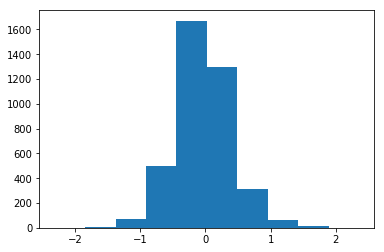

In [98]:
plt.hist(df_train["bias_score_after"])

The decrease is smaller than expected: perhaps more training is necessary?

In [99]:
df_train["original_bias_score"].abs().mean()

0.5740941524840664

In [100]:
df_train["bias_score_after"].abs().mean()

0.3282451266545908

In [101]:
df_val["bias_score_after"] = df_val.progress_apply(compute_bias_score, axis=1)

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 2/444 [00:00<00:26, 16.44it/s]

  1%|          | 4/444 [00:00<00:28, 15.23it/s]

  1%|▏         | 6/444 [00:00<00:30, 14.35it/s]

  2%|▏         | 8/444 [00:00<00:30, 14.12it/s]

  2%|▏         | 10/444 [00:00<00:32, 13.45it/s]

  3%|▎         | 12/444 [00:00<00:32, 13.42it/s]

  3%|▎         | 14/444 [00:01<00:32, 13.22it/s]

  4%|▎         | 16/444 [00:01<00:31, 13.61it/s]

  4%|▍         | 18/444 [00:01<00:31, 13.73it/s]

  5%|▍         | 20/444 [00:01<00:30, 13.88it/s]

  5%|▍         | 22/444 [00:01<00:30, 13.71it/s]

  5%|▌         | 24/444 [00:01<00:31, 13.32it/s]

  6%|▌         | 26/444 [00:01<00:32, 12.98it/s]

  6%|▋         | 28/444 [00:02<00:32, 12.94it/s]

  7%|▋         | 30/444 [00:02<00:32, 12.91it/s]

  7%|▋         | 32/444 [00:02<00:31, 13.09it/s]

  8%|▊         | 34/444 [00:02<00:31, 12.89it/s]

  8%|▊         | 36/444 [00:02<00:31, 13.12it/s]

  9%|▊         | 38/444 [00:02<00:31, 13.06it/s]

  9%|▉         | 40/444 [00:03<00:30, 13.05it/s]

  9%|▉         | 42/444 [00:03<00:29, 13.57it/s]

 10%|▉         | 44/444 [00:03<00:29, 13.73it/s]

 10%|█         | 46/444 [00:03<00:28, 13.81it/s]

 11%|█         | 48/444 [00:03<00:29, 13.51it/s]

 11%|█▏        | 50/444 [00:03<00:31, 12.42it/s]

 12%|█▏        | 52/444 [00:03<00:32, 12.25it/s]

 12%|█▏        | 54/444 [00:04<00:30, 12.71it/s]

 13%|█▎        | 56/444 [00:04<00:29, 13.34it/s]

 13%|█▎        | 58/444 [00:04<00:27, 14.02it/s]

 14%|█▎        | 60/444 [00:04<00:26, 14.60it/s]

 14%|█▍        | 62/444 [00:04<00:26, 14.52it/s]

 14%|█▍        | 64/444 [00:04<00:25, 15.03it/s]

 15%|█▍        | 66/444 [00:04<00:24, 15.39it/s]

 15%|█▌        | 68/444 [00:04<00:24, 15.35it/s]

 16%|█▌        | 70/444 [00:05<00:24, 15.52it/s]

 16%|█▌        | 72/444 [00:05<00:24, 15.11it/s]

 17%|█▋        | 74/444 [00:05<00:25, 14.76it/s]

 17%|█▋        | 76/444 [00:05<00:25, 14.70it/s]

 18%|█▊        | 78/444 [00:05<00:26, 13.66it/s]

 18%|█▊        | 80/444 [00:05<00:26, 13.64it/s]

 18%|█▊        | 82/444 [00:05<00:25, 14.06it/s]

 19%|█▉        | 84/444 [00:06<00:25, 14.31it/s]

 19%|█▉        | 86/444 [00:06<00:25, 14.09it/s]

 20%|█▉        | 88/444 [00:06<00:24, 14.32it/s]

 20%|██        | 90/444 [00:06<00:24, 14.63it/s]

 21%|██        | 92/444 [00:06<00:24, 14.50it/s]

 21%|██        | 94/444 [00:06<00:24, 14.30it/s]

 22%|██▏       | 96/444 [00:06<00:24, 14.43it/s]

 22%|██▏       | 98/444 [00:07<00:24, 14.35it/s]

 23%|██▎       | 100/444 [00:07<00:23, 14.68it/s]

 23%|██▎       | 102/444 [00:07<00:23, 14.68it/s]

 23%|██▎       | 104/444 [00:07<00:23, 14.60it/s]

 24%|██▍       | 106/444 [00:07<00:23, 14.40it/s]

 24%|██▍       | 108/444 [00:07<00:23, 14.61it/s]

 25%|██▍       | 110/444 [00:07<00:23, 14.39it/s]

 25%|██▌       | 112/444 [00:08<00:23, 14.24it/s]

 26%|██▌       | 114/444 [00:08<00:23, 13.81it/s]

 26%|██▌       | 116/444 [00:08<00:23, 13.92it/s]

 27%|██▋       | 118/444 [00:08<00:22, 14.32it/s]

 27%|██▋       | 120/444 [00:08<00:22, 14.17it/s]

 27%|██▋       | 122/444 [00:08<00:23, 13.78it/s]

 28%|██▊       | 124/444 [00:08<00:23, 13.88it/s]

 28%|██▊       | 126/444 [00:09<00:22, 14.21it/s]

 29%|██▉       | 128/444 [00:09<00:21, 14.54it/s]

 29%|██▉       | 130/444 [00:09<00:22, 14.15it/s]

 30%|██▉       | 132/444 [00:09<00:22, 13.60it/s]

 30%|███       | 134/444 [00:09<00:23, 13.23it/s]

 31%|███       | 136/444 [00:09<00:22, 13.62it/s]

 31%|███       | 138/444 [00:09<00:22, 13.73it/s]

 32%|███▏      | 140/444 [00:10<00:21, 13.86it/s]

 32%|███▏      | 142/444 [00:10<00:22, 13.33it/s]

 32%|███▏      | 144/444 [00:10<00:22, 13.52it/s]

 33%|███▎      | 146/444 [00:10<00:22, 13.46it/s]

 33%|███▎      | 148/444 [00:10<00:24, 12.21it/s]

 34%|███▍      | 150/444 [00:10<00:23, 12.58it/s]

 34%|███▍      | 152/444 [00:11<00:22, 13.18it/s]

 35%|███▍      | 154/444 [00:11<00:21, 13.73it/s]

 35%|███▌      | 156/444 [00:11<00:22, 12.91it/s]

 36%|███▌      | 158/444 [00:11<00:25, 11.36it/s]

 36%|███▌      | 160/444 [00:11<00:25, 11.36it/s]

 36%|███▋      | 162/444 [00:11<00:24, 11.57it/s]

 37%|███▋      | 164/444 [00:12<00:24, 11.51it/s]

 37%|███▋      | 166/444 [00:12<00:23, 11.88it/s]

 38%|███▊      | 168/444 [00:12<00:23, 12.00it/s]

 38%|███▊      | 170/444 [00:12<00:23, 11.71it/s]

 39%|███▊      | 172/444 [00:12<00:23, 11.75it/s]

 39%|███▉      | 174/444 [00:12<00:22, 11.90it/s]

 40%|███▉      | 176/444 [00:13<00:22, 12.14it/s]

 40%|████      | 178/444 [00:13<00:21, 12.24it/s]

 41%|████      | 180/444 [00:13<00:21, 12.55it/s]

 41%|████      | 182/444 [00:13<00:21, 12.42it/s]

 41%|████▏     | 184/444 [00:13<00:21, 12.17it/s]

 42%|████▏     | 186/444 [00:13<00:21, 11.95it/s]

 42%|████▏     | 188/444 [00:14<00:20, 12.22it/s]

 43%|████▎     | 190/444 [00:14<00:20, 12.13it/s]

 43%|████▎     | 192/444 [00:14<00:20, 12.25it/s]

 44%|████▎     | 194/444 [00:14<00:20, 12.17it/s]

 44%|████▍     | 196/444 [00:14<00:19, 12.75it/s]

 45%|████▍     | 198/444 [00:14<00:19, 12.75it/s]

 45%|████▌     | 200/444 [00:14<00:19, 12.67it/s]

 45%|████▌     | 202/444 [00:15<00:18, 13.04it/s]

 46%|████▌     | 204/444 [00:15<00:18, 12.97it/s]

 46%|████▋     | 206/444 [00:15<00:18, 13.08it/s]

 47%|████▋     | 208/444 [00:15<00:17, 13.39it/s]

 47%|████▋     | 210/444 [00:15<00:16, 13.78it/s]

 48%|████▊     | 212/444 [00:15<00:16, 13.97it/s]

 48%|████▊     | 214/444 [00:15<00:16, 14.28it/s]

 49%|████▊     | 216/444 [00:16<00:15, 14.64it/s]

 49%|████▉     | 218/444 [00:16<00:15, 14.91it/s]

 50%|████▉     | 220/444 [00:16<00:14, 15.25it/s]

 50%|█████     | 222/444 [00:16<00:14, 15.22it/s]

 50%|█████     | 224/444 [00:16<00:14, 15.30it/s]

 51%|█████     | 226/444 [00:16<00:14, 15.12it/s]

 51%|█████▏    | 228/444 [00:16<00:14, 15.21it/s]

 52%|█████▏    | 230/444 [00:17<00:13, 15.38it/s]

 52%|█████▏    | 232/444 [00:17<00:13, 15.51it/s]

 53%|█████▎    | 234/444 [00:17<00:13, 15.65it/s]

 53%|█████▎    | 236/444 [00:17<00:13, 15.77it/s]

 54%|█████▎    | 238/444 [00:17<00:12, 15.99it/s]

 54%|█████▍    | 240/444 [00:17<00:12, 16.01it/s]

 55%|█████▍    | 242/444 [00:17<00:12, 15.99it/s]

 55%|█████▍    | 244/444 [00:17<00:12, 15.96it/s]

 55%|█████▌    | 246/444 [00:18<00:12, 15.99it/s]

 56%|█████▌    | 248/444 [00:18<00:12, 16.02it/s]

 56%|█████▋    | 250/444 [00:18<00:12, 15.53it/s]

 57%|█████▋    | 252/444 [00:18<00:12, 15.51it/s]

 57%|█████▋    | 254/444 [00:18<00:12, 15.12it/s]

 58%|█████▊    | 256/444 [00:18<00:12, 14.97it/s]

 58%|█████▊    | 258/444 [00:18<00:12, 14.49it/s]

 59%|█████▊    | 260/444 [00:18<00:12, 14.17it/s]

 59%|█████▉    | 262/444 [00:19<00:13, 13.88it/s]

 59%|█████▉    | 264/444 [00:19<00:14, 12.48it/s]

 60%|█████▉    | 266/444 [00:19<00:14, 12.26it/s]

 60%|██████    | 268/444 [00:19<00:14, 12.10it/s]

 61%|██████    | 270/444 [00:19<00:14, 12.11it/s]

 61%|██████▏   | 272/444 [00:20<00:17,  9.86it/s]

 62%|██████▏   | 274/444 [00:20<00:15, 10.67it/s]

 62%|██████▏   | 276/444 [00:20<00:14, 11.46it/s]

 63%|██████▎   | 278/444 [00:20<00:13, 11.98it/s]

 63%|██████▎   | 280/444 [00:20<00:13, 12.48it/s]

 64%|██████▎   | 282/444 [00:20<00:12, 13.15it/s]

 64%|██████▍   | 284/444 [00:20<00:11, 13.48it/s]

 64%|██████▍   | 286/444 [00:21<00:11, 13.85it/s]

 65%|██████▍   | 288/444 [00:21<00:11, 13.94it/s]

 65%|██████▌   | 290/444 [00:21<00:11, 13.71it/s]

 66%|██████▌   | 292/444 [00:21<00:11, 13.58it/s]

 66%|██████▌   | 294/444 [00:21<00:11, 13.56it/s]

 67%|██████▋   | 296/444 [00:21<00:11, 13.39it/s]

 67%|██████▋   | 298/444 [00:22<00:11, 12.85it/s]

 68%|██████▊   | 300/444 [00:22<00:11, 13.01it/s]

 68%|██████▊   | 302/444 [00:22<00:11, 12.41it/s]

 68%|██████▊   | 304/444 [00:22<00:11, 11.77it/s]

 69%|██████▉   | 306/444 [00:22<00:10, 12.58it/s]

 69%|██████▉   | 308/444 [00:22<00:11, 11.74it/s]

 70%|██████▉   | 310/444 [00:23<00:11, 12.00it/s]

 70%|███████   | 312/444 [00:23<00:11, 11.73it/s]

 71%|███████   | 314/444 [00:23<00:11, 11.12it/s]

 71%|███████   | 316/444 [00:23<00:11, 11.59it/s]

 72%|███████▏  | 318/444 [00:23<00:10, 11.71it/s]

 72%|███████▏  | 320/444 [00:23<00:10, 11.43it/s]

 73%|███████▎  | 322/444 [00:24<00:11, 10.19it/s]

 73%|███████▎  | 324/444 [00:24<00:11, 10.68it/s]

 73%|███████▎  | 326/444 [00:24<00:11, 10.73it/s]

 74%|███████▍  | 328/444 [00:24<00:10, 11.33it/s]

 74%|███████▍  | 330/444 [00:24<00:09, 11.72it/s]

 75%|███████▍  | 332/444 [00:25<00:11, 10.10it/s]

 75%|███████▌  | 334/444 [00:25<00:10, 10.75it/s]

 76%|███████▌  | 336/444 [00:25<00:09, 11.01it/s]

 76%|███████▌  | 338/444 [00:25<00:09, 11.43it/s]

 77%|███████▋  | 340/444 [00:25<00:08, 11.80it/s]

 77%|███████▋  | 342/444 [00:25<00:08, 12.45it/s]

 77%|███████▋  | 344/444 [00:26<00:07, 12.76it/s]

 78%|███████▊  | 346/444 [00:26<00:07, 12.91it/s]

 78%|███████▊  | 348/444 [00:26<00:07, 13.16it/s]

 79%|███████▉  | 350/444 [00:26<00:07, 13.42it/s]

 79%|███████▉  | 352/444 [00:26<00:06, 13.20it/s]

 80%|███████▉  | 354/444 [00:26<00:06, 13.27it/s]

 80%|████████  | 356/444 [00:26<00:06, 13.42it/s]

 81%|████████  | 358/444 [00:27<00:06, 13.27it/s]

 81%|████████  | 360/444 [00:27<00:06, 13.06it/s]

 82%|████████▏ | 362/444 [00:27<00:06, 12.91it/s]

 82%|████████▏ | 364/444 [00:27<00:06, 12.91it/s]

 82%|████████▏ | 366/444 [00:27<00:05, 13.40it/s]

 83%|████████▎ | 368/444 [00:27<00:05, 13.52it/s]

 83%|████████▎ | 370/444 [00:27<00:05, 13.86it/s]

 84%|████████▍ | 372/444 [00:28<00:05, 14.38it/s]

 84%|████████▍ | 374/444 [00:28<00:04, 14.92it/s]

 85%|████████▍ | 376/444 [00:28<00:04, 15.00it/s]

 85%|████████▌ | 378/444 [00:28<00:04, 15.35it/s]

 86%|████████▌ | 380/444 [00:28<00:04, 15.16it/s]

 86%|████████▌ | 382/444 [00:28<00:04, 15.38it/s]

 86%|████████▋ | 384/444 [00:28<00:03, 15.62it/s]

 87%|████████▋ | 386/444 [00:28<00:03, 15.54it/s]

 87%|████████▋ | 388/444 [00:29<00:03, 15.31it/s]

 88%|████████▊ | 390/444 [00:29<00:03, 15.03it/s]

 88%|████████▊ | 392/444 [00:29<00:03, 15.05it/s]

 89%|████████▊ | 394/444 [00:29<00:03, 15.04it/s]

 89%|████████▉ | 396/444 [00:29<00:03, 15.00it/s]

 90%|████████▉ | 398/444 [00:29<00:03, 14.94it/s]

 90%|█████████ | 400/444 [00:29<00:02, 15.13it/s]

 91%|█████████ | 402/444 [00:30<00:02, 15.01it/s]

 91%|█████████ | 404/444 [00:30<00:02, 15.19it/s]

 91%|█████████▏| 406/444 [00:30<00:02, 15.23it/s]

 92%|█████████▏| 408/444 [00:30<00:02, 15.35it/s]

 92%|█████████▏| 410/444 [00:30<00:02, 15.06it/s]

 93%|█████████▎| 412/444 [00:30<00:02, 15.06it/s]

 93%|█████████▎| 414/444 [00:30<00:01, 15.11it/s]

 94%|█████████▎| 416/444 [00:30<00:01, 15.05it/s]

 94%|█████████▍| 418/444 [00:31<00:01, 15.00it/s]

 95%|█████████▍| 420/444 [00:31<00:01, 15.09it/s]

 95%|█████████▌| 422/444 [00:31<00:01, 14.74it/s]

 95%|█████████▌| 424/444 [00:31<00:01, 14.05it/s]

 96%|█████████▌| 426/444 [00:31<00:01, 13.99it/s]

 96%|█████████▋| 428/444 [00:31<00:01, 13.89it/s]

 97%|█████████▋| 430/444 [00:31<00:00, 14.03it/s]

 97%|█████████▋| 432/444 [00:32<00:00, 13.84it/s]

 98%|█████████▊| 434/444 [00:32<00:00, 13.77it/s]

 98%|█████████▊| 436/444 [00:32<00:00, 14.20it/s]

 99%|█████████▊| 438/444 [00:32<00:00, 14.41it/s]

 99%|█████████▉| 440/444 [00:32<00:00, 14.53it/s]

100%|█████████▉| 442/444 [00:32<00:00, 14.65it/s]

100%|██████████| 444/444 [00:32<00:00, 14.63it/s]

In [102]:
df_val["original_bias_score"].abs().mean()

0.5749167273542634

In [103]:
df_val["bias_score_after"].abs().mean()

0.3604625289974449

# Export Weights

As PyTorch state dict

In [104]:
torch.save(masked_lm.state_dict(), MODEL_SAVE_DIR / "state_dict.pth")

TODO: Export as tensorflow checkpoint?